# Predicción de Series Temporales 

by Alina Martinez - [Github](https://github.com/martinezalina/illia-p4)

## Objetivos

Este proyecto consta de dos objetivos, por un lado el objetivo académico solicitado. Y por otro, el objetivo práctico para el cual se crean y entrenan los modelos. 

A continuación describo desarrollo ambos objetivos.

### Objetivo Académico

El desafío académico consta de varias partes. Veamos cuáles son.


####  Elegir como punto de partida un proyecto anterior

Mi elección tomar como punto de partida el Proyecto 3, al cual pueden acceder [aquí]( https://github.com/martinezalina/illia-p3).

#### Formula una nueva pregunta, problema o desafío para explorar

Dado que es posible elegir como desafío probar un modelo que no se haya trabajado en la carrera, y que la ganancia no necesariamente tiene que ser en desempeño, sino también puede ser en interpretabilidad o aplicabilidad, decido experimentar con redes neuronales para medir su desempeño en la predicción de series de tiempo.

Como interrogantes, me planteo ¿Cuál será la curva de aprendizaje de este tipo de tecnología? ¿Cuánto tiempo se demora en encontrar, y entrenar un modelo óptimo? ¿Son modelos aplicables para ser implementados a corto plazo o es conveniente elegirlos cuando la proyección del resultado es a largo plazo?


#### Probar un modelo de Machine Learning nuevo que no se haya visto en la carrera

Luego de investigar qué tipo de red se utiliza para estos casos, voy a trabajar con la LSTM con tres variantes: univariable, multivariable y con autoencoders.

#### Agrega al proyecto información de otra fuente de datos

- Tomando como punto de partida la relación que existe entre el precio de la nafta, y la afluencia de vehículos en la autopista, incorporo un nuevo dataset, el cual se trabaja en principio en el notebook anexo `precios-surtidor.ipynb` ubicado en este repositorio, para luego utilizarse como variable predictora en este notebook principal.
- En el notebook anexo `flujo-vehicular-2020.ipynb`, incorporo el dataset del flujo vehicular 2020, el cual ya está disponible, y de la misma forma que con el otro dataset, lo trabajo para luego incorporarlo en este notebook principal.

#### Continuar el Análisis Exploratorio de Datos

Se realiza en profundidad el análisis exploratorio de datos del flujo vehicular del 2020, el cual no estaba disponible en el Proyecto 3.


### Objetivo Práctico

Generar un modelo de predicción del último trimestre del 2019, del flujo vehicular en la Autopista Illia, modalidad pago en efectivo. Y con el mejor modelo obtenido, predecir el 2020.

### Dataset: Flujo Vehicular por Unidades de Peaje AUSA

Dataset: Flujo Vehicular por Unidades de Peaje AUSA. 
**[Link](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa)**

### Procedimiento

Se realizará un **análisis exploratorio de datos** y resampleo en diferentes unidades de tiempo.
Incorporaremos **dos nuevos datasets** los cuales fueron trabajados en notebooks a parte:
  - Flujo vehicular de AU Illia 2020.
  - Precio promedio de litro de nafta en surtidor en Argentina.

**Predicción** a futuro:
  - Haremos las transformaciones de datos necesarias.
  - Definiremos un modelo benckmark y compararemos los resultados con otros modelos.
  - Evaluaremos cómo funciona el modelo para predecir el 2020.


# Seteos iniciales

## Instalación de Librerías extras

In [1]:
#pip install plotly==4.11.0

In [2]:
#pip install tensorflow

In [3]:
#pip install keras

## Importamos las Librerías que vamos a utilizar

In [4]:
from IPython.display import display, Markdown
import datetime, warnings, itertools

#Warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import numpy as np
#from numpy import concatenate
#import matplotlib.pylab as plt

%matplotlib inline

from math import sqrt

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from plotly import express as px
from plotly import graph_objects as go
from plotly import figure_factory as ff
from plotly.subplots import make_subplots

import seaborn as sns

from statsmodels import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa import stattools

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

from keras.models import Sequential
from keras.layers import Dense,Activation,LSTM, RepeatVector, TimeDistributed


## Configuro Notebook

In [6]:
# Format round off to two decimal places in pandas 
pd.options.display.float_format = '{: .2f}'.format

# Gerenal Plots
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

## Funciones

In [7]:
def missing_zero_values_table(df):
    zero_val=df.isin([0]).sum(axis=0)
    mis_val=df.isnull().sum()
    l=len(df)
    mis_val_percent=100*df.isnull().sum()/l
    zero_val_percent=100*df.isin([0]).sum()/l
    mz_table=pd.concat([zero_val,zero_val_percent,mis_val,mis_val_percent],axis=1)
    mz_table=mz_table.rename(
        columns={
            0:'Zero Values', 
            1:'% of Zero Values', 
            2:'Missing Values', 
            3:'% of Missing Values'}
    )
    mz_table['Total Missing Values']=mz_table['Zero Values']+mz_table['Missing Values']
    mz_table['% Total Missing Values']=100*mz_table['Total Missing Values']/l
    mz_table=mz_table[mz_table.iloc[:,4] != 0].sort_values(
    '% Total Missing Values', ascending=False).round(1)
    tc=str(df.shape[1])
    tr=str(df.shape[0])
    tcm=str(mz_table.shape[0])
    txt='Your selected dataframe has '+str(tc)+' columns and '+str(tr)+' Rows.'
    txt+='\nThere are '+str(tcm)+' columns that have missing values.'
    display(mz_table)
    return txt

def explore_var(df,var,limit=20):
    cant=df.nunique()
    df_full = df.value_counts().rename_axis('unique_values').reset_index(name='counts')
    df_full = df_full.sort_values(by=['counts'],ascending=False)
    total = df_full['counts'].sum()
    topLimit= df_full[0:limit]
    df_full = df_full.append({'unique_values':'Total','counts':total},ignore_index=True) 
    t1='\nThere are **'+str(cant)+'** different value in the **'+str(var)+'** variable of the dataframe.'
    if cant<=1:
        t1='\nThere is **only one** different value in the **'+str(var)+'** variable of the dataframe.'
        t2 ='The value is:'  
    elif cant>=limit:
        t2='The list of the first **'+str(limit)+'**  values:'
        df_full = topLimit
    else:
        t2 ='The list of the **'+str(cant)+'**  values:'    
    display(Markdown(t1))
    display(Markdown(t2))
    return df_full

def print_columns(df):
    display(Markdown('#### List of columns:'))
    text = '| '
    for x in range(0, df.shape[1]):
        text = text + df.columns.values[x] + ' | '
    return text


# Carga de Dataset

## Lectura de datasets oficiales

**Aclaración:**
Para la obtención del dataset del 2020, se generó una unificación de los 3 datasets que ofrece el sitio oficial.
Este proceso se llevó a cabo en el notebook `flujo-vehicular-2020.ipynb` que se encuentra también en el repositorio de github.


In [8]:
# Se simplifica la carga de forma local. 

data_2016 = pd.read_csv('./datasets/flujo-vehicular-2016.csv')
data_2017 = pd.read_csv('./datasets/flujo-vehicular-2017.csv')
data_2018 = pd.read_csv('./datasets/flujo-vehicular-2018.csv')
data_2019 = pd.read_csv('./datasets/flujo-vehicular-2019.csv')
data_2020_S1 = pd.read_csv('./datasets/flujo-vehicular-2020-S1.csv')
data_2020_S2 = pd.read_csv('./datasets/flujo-vehicular-2020-S2.csv')


## Chequeo carga

In [9]:
data_2016

periodo       fecha  hora_inicio  hora_fin      dia   estacion  \
0           2016  2016-01-01            0         1  Viernes    Alberdi   
1           2016  2016-01-01            0         1  Viernes    Alberdi   
2           2016  2016-01-01            1         2  Viernes    Alberdi   
3           2016  2016-01-01            1         2  Viernes    Alberdi   
4           2016  2016-01-01            1         2  Viernes    Alberdi   
...          ...         ...          ...       ...      ...        ...   
1379438     2016  2016-12-31           21        22   Sábado  Sarmiento   
1379439     2016  2016-12-31           22        23   Sábado  Sarmiento   
1379440     2016  2016-12-31           22        23   Sábado  Sarmiento   
1379441     2016  2016-12-31           23         0   Sábado  Sarmiento   
1379442     2016  2016-12-31           23         0   Sábado  Sarmiento   

           sentido tipo_vehiculo  forma_pago  cantidad_pasos  
0           Centro       Liviano  NO COBRADO              32  
1           Centro       Liviano      AUPASS               9  
2           Centro       Liviano  NO COBRADO               1  
3           Centro       Liviano    EFECTIVO               4  
4           Centro       Liviano      EXENTO               3  
...            ...           ...         ...             ...  
1379438  Provincia       Liviano      AUPASS              77  
1379439  Provincia       Liviano  NO COBRADO               2  
1379440  Provincia       Liviano      AUPASS               6  
1379441  Provincia       Liviano  NO COBRADO               1  
1379442  Provincia       Liviano      AUPASS               3  

[1379443 rows x 10 columns]

In [10]:
data_2017

periodo       fecha  hora_inicio  hora_fin      dia   estacion  \
0           2017  2017-01-01            0         1  Domingo    Alberdi   
1           2017  2017-01-01            0         1  Domingo    Alberdi   
2           2017  2017-01-01            1         2  Domingo    Alberdi   
3           2017  2017-01-01            1         2  Domingo    Alberdi   
4           2017  2017-01-01            1         2  Domingo    Alberdi   
...          ...         ...          ...       ...      ...        ...   
1372640     2017  2017-12-31           22        23  Domingo  Sarmiento   
1372641     2017  2017-12-31           22        23  Domingo  Sarmiento   
1372642     2017  2017-12-31           22        23  Domingo  Sarmiento   
1372643     2017  2017-12-31           23         0  Domingo  Sarmiento   
1372644     2017  2017-12-31           23         0  Domingo  Sarmiento   

           sentido tipo_vehiculo  forma_pago  cantidad_pasos  
0           Centro       Liviano  NO COBRADO              25  
1           Centro       Liviano    TELEPASE               7  
2           Centro       Liviano  NO COBRADO               5  
3           Centro       Liviano    EFECTIVO               2  
4           Centro       Liviano    EFECTIVO              94  
...            ...           ...         ...             ...  
1372640  Provincia       Liviano  NO COBRADO               3  
1372641  Provincia       Liviano    TELEPASE              10  
1372642  Provincia        Pesado    TELEPASE               1  
1372643  Provincia       Liviano  NO COBRADO               1  
1372644  Provincia       Liviano    TELEPASE               4  

[1372645 rows x 10 columns]

In [11]:
data_2018

periodo       fecha  hora_inicio  hora_fin    dia   estacion  \
0           2018  2018-01-01            0         1  Lunes    Alberdi   
1           2018  2018-01-01            0         1  Lunes    Alberdi   
2           2018  2018-01-01            1         2  Lunes    Alberdi   
3           2018  2018-01-01            1         2  Lunes    Alberdi   
4           2018  2018-01-01            2         3  Lunes    Alberdi   
...          ...         ...          ...       ...    ...        ...   
1375903     2018  2018-12-31           21        22  Lunes  Sarmiento   
1375904     2018  2018-12-31           21        22  Lunes  Sarmiento   
1375905     2018  2018-12-31           22        23  Lunes  Sarmiento   
1375906     2018  2018-12-31           22        23  Lunes  Sarmiento   
1375907     2018  2018-12-31           23         0  Lunes  Sarmiento   

           sentido tipo_vehiculo  forma_pago  cantidad_pasos  
0           Centro       Liviano  NO COBRADO              29  
1           Centro       Liviano    TELEPASE               9  
2           Centro       Liviano  NO COBRADO              73  
3           Centro       Liviano    TELEPASE              39  
4           Centro       Liviano  NO COBRADO             115  
...            ...           ...         ...             ...  
1375903  Provincia       Liviano    TELEPASE              62  
1375904  Provincia        Pesado    TELEPASE               1  
1375905  Provincia       Liviano  NO COBRADO               3  
1375906  Provincia       Liviano    TELEPASE              13  
1375907  Provincia       Liviano  NO COBRADO               3  

[1375908 rows x 10 columns]

In [12]:
data_2019

periodo       fecha  hora_inicio  hora_fin     dia    estacion  \
0          2019  2019-01-01            0         1  Martes     Alberti   
1          2019  2019-01-01            0         1  Martes     Alberti   
2          2019  2019-01-01            0         1  Martes     Alberti   
3          2019  2019-01-01            0         1  Martes     Alberti   
4          2019  2019-01-01            0         1  Martes  Avellaneda   
...         ...         ...          ...       ...     ...         ...   
812148     2019  2019-12-31           23         0  Martes    Salguero   
812149     2019  2019-12-31           23         0  Martes    Salguero   
812150     2019  2019-12-31           23         0  Martes    Salguero   
812151     2019  2019-12-31           23         0  Martes   Sarmiento   
812152     2019  2019-12-31           23         0  Martes   Sarmiento   

          sentido tipo_vehiculo  forma_pago  cantidad_pasos  
0          Centro       Liviano  NO COBRADO              22  
1          Centro       Liviano    TELEPASE               6  
2       Provincia       Liviano  NO COBRADO              53  
3       Provincia       Liviano    TELEPASE              18  
4          Centro       Liviano    EFECTIVO              16  
...           ...           ...         ...             ...  
812148  Provincia       Liviano  NO COBRADO               7  
812149  Provincia       Liviano    TELEPASE               4  
812150  Provincia        Pesado  NO COBRADO               1  
812151  Provincia       Liviano  NO COBRADO               7  
812152  Provincia       Liviano    TELEPASE               7  

[812153 rows x 10 columns]

In [13]:
data_2020 = pd.concat([data_2020_S1,data_2020_S2])
data_2020

estacion   tipo_vehiculo    forma_pago    sentido  cantidad_pasos  \
0               PDB  Pesados 4 Ejes      TELEPASE  Provincia            3.00   
1        Dellepiane            Auto        EXENTO  Provincia            6.00   
2        Dellepiane            Auto      EFECTIVO  Provincia          443.00   
3        Dellepiane            Auto      TELEPASE     Centro            2.00   
4        Dellepiane            Auto      TELEPASE     Centro            7.00   
...             ...             ...           ...        ...             ...   
1328370     Alberdi            Auto      TELEPASE     Centro           18.00   
1328371     Alberdi            Auto  Mercado Pago     Centro            2.00   
1328372     Alberdi            Auto  Mercado Pago  Provincia            1.00   
1328373  Avellaneda            Auto      TELEPASE  Provincia            5.95   
1328374  Dellepiane            Auto  Mercado Pago  Provincia            6.00   

                       fecha  
0        2020-01-01 00:00:00  
1        2020-01-01 00:00:00  
2        2020-01-01 00:00:00  
3        2020-01-01 00:00:00  
4        2020-01-01 00:00:00  
...                      ...  
1328370  2020-12-31 23:00:00  
1328371  2020-12-31 23:00:00  
1328372  2020-12-31 23:00:00  
1328373  2020-12-31 23:00:00  
1328374  2020-12-31 23:00:00  

[2533743 rows x 6 columns]

# Exploración Inicial
Investigo que valores toman los campos `estacion`, `sentido`, `tipo_vehiculo` y `forma_pago`.

## Estaciones

In [14]:
print('Estaciones en 2020')
print(data_2020['estacion'].unique())
print('\nEstaciones en 2019')
print(data_2019['estacion'].unique())
print('\nEstaciones en 2018')
print(data_2018['estacion'].unique())
print('\nEstaciones en 2017')
print(data_2017['estacion'].unique())
print('\nEstaciones en 2016')
print(data_2016['estacion'].unique())

Estaciones en 2020
['PDB' 'Dellepiane' 'Avellaneda' 'Illia' 'Alberdi' 'Salguero' 'Sarmiento'
 'Retiro']

Estaciones en 2019
['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']

Estaciones en 2018
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']

Estaciones en 2017
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']

Estaciones en 2016
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


## Sentido

In [15]:
print('Sentido en 2020')
print(data_2020['sentido'].unique())
print('\nSentido en 2019')
print(data_2019['sentido'].unique())
print('\nSentido en 2018')
print(data_2018['sentido'].unique())
print('\nSentido en 2017')
print(data_2017['sentido'].unique())
print('\nSentido en 2016')
print(data_2016['sentido'].unique())

Sentido en 2020
['Provincia' 'Centro']

Sentido en 2019
['Centro' 'Provincia']

Sentido en 2018
['Centro' 'Provincia']

Sentido en 2017
['Centro' 'Provincia']

Sentido en 2016
['Centro' 'Provincia']


## Tipo de Vehículo

In [16]:
print('Tipo de Vehículo en 2020')
print(data_2020['tipo_vehiculo'].unique())
print('\nTipo de Vehículo en 2019')
print(data_2019['tipo_vehiculo'].unique())
print('\nTipo de Vehículo en 2018')
print(data_2018['tipo_vehiculo'].unique())
print('\nTipo de Vehículo en 2017')
print(data_2017['tipo_vehiculo'].unique())
print('\nTipo de Vehículo en 2016')
print(data_2016['tipo_vehiculo'].unique())

Tipo de Vehículo en 2020
['Pesados 4 Ejes' 'Auto' 'Pesados 2 Ejes' 'Moto' 'N/D' 'Auto con trailer'
 'Pesados 5 Ejes' 'Pesados 3 Ejes' 'Pesados 6 Ejes' 'Pago Doble Auto'
 'Pago doble Moto' 'Pago Doble Auto con trailer / Pesado 2 Ejes']

Tipo de Vehículo en 2019
['Liviano' 'Pesado']

Tipo de Vehículo en 2018
['Liviano' 'Pesado']

Tipo de Vehículo en 2017
['Liviano' 'Pesado']

Tipo de Vehículo en 2016
['Liviano' 'Pesado']


## Forma de Pago

In [17]:
print('Forma de Pago en 2020')
print(data_2020['forma_pago'].unique())
print('\nForma de Pago en 2019')
print(data_2019['forma_pago'].unique())
print('\nForma de Pago en 2018')
print(data_2018['forma_pago'].unique())
print('\nForma de Pago en 2017')
print(data_2017['forma_pago'].unique())
print('\nForma de Pago en 2016')
print(data_2016['forma_pago'].unique())

Forma de Pago en 2020
['TELEPASE' 'EXENTO' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'INFRACCION'
 'Violación' 'CPP' 'Mercado Pago']

Forma de Pago en 2019
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']

Forma de Pago en 2018
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']

Forma de Pago en 2017
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']

Forma de Pago en 2016
['NO COBRADO' 'AUPASS' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION' 'MONEDERO']


## Campos de los datasets

Podemos decir entonces que los años 2016, 2017, 2018, 2019  y 2020 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dataset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: Estaciones de peaje. 

Difieren levemente entre los años 2016 a 2019 (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB). 

En 2020, cambian PDB por PB1, PB2, PB3 y PB4. También agregan ILP. A su vez, separan Dellepiane en DELLEPIANE LINIERSLEPIANE CENTRO y DELLEPIANE LINIERS. (Para esto, se realiza el tratamiento previo de los datos en el otro notebook.)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Desde 2016 a 2019 se divide en Liviano o Pesado. A partir del 2020, se agregan varias categorías para ser más específicos:
- Auto
- Auto con trailer
- Moto
- N/D
- Pago Doble Auto
- Pago Doble Auto con trailer / Pesado 2 Ejes
- Pago doble Moto
- Pesados 2 Ejes
- Pesados 3 Ejes
- Pesados 4 Ejes
- Pesados 5 Ejes
- Pesados 6 Ejes

**forma_pago**: Hay varias y varian entre los años. La que se mantiene siempre es Efectivo. El 2020, es el que más difiere de todos los años:
- Efectivo
- Infracción
- Tarjeta Discapacidad
- Telepase
- Exento
- Violación
- CPP

**cantidad_pasos**: Cantidad de vehiculos


# Unificación de Datasets

In [18]:
data = pd.concat([data_2016,data_2017,data_2018,data_2019])
data

periodo       fecha  hora_inicio  hora_fin      dia   estacion  \
0          2016  2016-01-01            0         1  Viernes    Alberdi   
1          2016  2016-01-01            0         1  Viernes    Alberdi   
2          2016  2016-01-01            1         2  Viernes    Alberdi   
3          2016  2016-01-01            1         2  Viernes    Alberdi   
4          2016  2016-01-01            1         2  Viernes    Alberdi   
...         ...         ...          ...       ...      ...        ...   
812148     2019  2019-12-31           23         0   Martes   Salguero   
812149     2019  2019-12-31           23         0   Martes   Salguero   
812150     2019  2019-12-31           23         0   Martes   Salguero   
812151     2019  2019-12-31           23         0   Martes  Sarmiento   
812152     2019  2019-12-31           23         0   Martes  Sarmiento   

          sentido tipo_vehiculo  forma_pago  cantidad_pasos  
0          Centro       Liviano  NO COBRADO              32  
1          Centro       Liviano      AUPASS               9  
2          Centro       Liviano  NO COBRADO               1  
3          Centro       Liviano    EFECTIVO               4  
4          Centro       Liviano      EXENTO               3  
...           ...           ...         ...             ...  
812148  Provincia       Liviano  NO COBRADO               7  
812149  Provincia       Liviano    TELEPASE               4  
812150  Provincia        Pesado  NO COBRADO               1  
812151  Provincia       Liviano  NO COBRADO               7  
812152  Provincia       Liviano    TELEPASE               7  

[4940149 rows x 10 columns]

## Transformación a datetime
Con los datos del dataframe, generamos una columna de tipo datetime.

In [19]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data['fecha2'] = pd.to_datetime(data.fecha) + pd.to_timedelta(data.hora_fin, unit = 'h')

#Quitamos las columnas que ya no vamos a utilizar
data.drop(columns=['periodo', 'dia','fecha','hora_inicio','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
data.rename(columns = {'fecha2':'fecha'}, inplace = True) 

# Al concatenar data_2020 es necesario volver a definir a `fecha` como `datetime`.
datasets = pd.concat([data, data_2020])
datasets['fecha'] = pd.to_datetime(datasets['fecha'])

#Reordenamos el dataset por fecha
datasets.sort_values('fecha', inplace = True)
datasets.reset_index(drop=True, inplace = True)

## Exploración de resultado

Inspeccionamos los tipos de datos del dataset resultante:

In [20]:
datasets.dtypes

estacion                  object
sentido                   object
tipo_vehiculo             object
forma_pago                object
cantidad_pasos           float64
fecha             datetime64[ns]
dtype: object

In [21]:
datasets

estacion    sentido tipo_vehiculo            forma_pago  \
0        Avellaneda     Centro       Liviano            NO COBRADO   
1        Avellaneda  Provincia       Liviano            INFRACCION   
2        Avellaneda  Provincia       Liviano  TARJETA DISCAPACIDAD   
3        Avellaneda  Provincia       Liviano              EFECTIVO   
4         Sarmiento  Provincia       Liviano            NO COBRADO   
...             ...        ...           ...                   ...   
7473887       Illia     Centro          Auto              TELEPASE   
7473888       Illia  Provincia          Auto              TELEPASE   
7473889       Illia     Centro          Auto              TELEPASE   
7473890  Avellaneda     Centro          Moto              TELEPASE   
7473891  Dellepiane  Provincia          Auto          Mercado Pago   

         cantidad_pasos               fecha  
0                 18.00 2016-01-01 00:00:00  
1                  7.00 2016-01-01 00:00:00  
2                 18.00 2016-01-01 00:00:00  
3                969.00 2016-01-01 00:00:00  
4                  7.00 2016-01-01 00:00:00  
...                 ...                 ...  
7473887            1.00 2020-12-31 23:00:00  
7473888            1.00 2020-12-31 23:00:00  
7473889            1.00 2020-12-31 23:00:00  
7473890            1.98 2020-12-31 23:00:00  
7473891            6.00 2020-12-31 23:00:00  

[7473892 rows x 6 columns]

## Tratamiendo modalidades de pago

In [22]:
# Exploro modalidades de pago
datasets['forma_pago'].unique()

array(['NO COBRADO', 'INFRACCION', 'TARJETA DISCAPACIDAD', 'EFECTIVO',
       'AUPASS', 'EXENTO', 'MONEDERO', 'TELEPASE', 'Otros',
       'T. DISCAPACIDAD', 'Violación', 'CPP', 'Mercado Pago'],
      dtype=object)

In [23]:
# Modifico Naming de forma de pago
datasets['forma_pago'] = datasets['forma_pago'].replace({
    'T. DISCAPACIDAD':'TARJETA DISCAPACIDAD',
})

In [24]:
# Verifico cambio
datasets['forma_pago'].unique()

array(['NO COBRADO', 'INFRACCION', 'TARJETA DISCAPACIDAD', 'EFECTIVO',
       'AUPASS', 'EXENTO', 'MONEDERO', 'TELEPASE', 'Otros', 'Violación',
       'CPP', 'Mercado Pago'], dtype=object)

## Tratamiento estaciones

In [25]:
# Exploro estaciones
datasets['estacion'].unique()

array(['Avellaneda', 'Sarmiento', 'Illia', 'Retiro', 'Alberdi',
       'Salguero', 'Dellepiane Centro', 'Dellepiane Liniers',
       'Dellepiane', 'Alberti', 'PDB'], dtype=object)

In [26]:
# Modifico Naming de estaciones
datasets['estacion'] = datasets['estacion'].replace({
    'Alberti':'Alberdi',
    'Dellepiane Centro':'Dellepiane',
    'Dellepiane Liniers':'Dellepiane',
})

In [27]:
# Verifico cambio
datasets['estacion'].unique()

array(['Avellaneda', 'Sarmiento', 'Illia', 'Retiro', 'Alberdi',
       'Salguero', 'Dellepiane', 'PDB'], dtype=object)

## Muestra de dataset final

In [28]:
datasets

estacion    sentido tipo_vehiculo            forma_pago  \
0        Avellaneda     Centro       Liviano            NO COBRADO   
1        Avellaneda  Provincia       Liviano            INFRACCION   
2        Avellaneda  Provincia       Liviano  TARJETA DISCAPACIDAD   
3        Avellaneda  Provincia       Liviano              EFECTIVO   
4         Sarmiento  Provincia       Liviano            NO COBRADO   
...             ...        ...           ...                   ...   
7473887       Illia     Centro          Auto              TELEPASE   
7473888       Illia  Provincia          Auto              TELEPASE   
7473889       Illia     Centro          Auto              TELEPASE   
7473890  Avellaneda     Centro          Moto              TELEPASE   
7473891  Dellepiane  Provincia          Auto          Mercado Pago   

         cantidad_pasos               fecha  
0                 18.00 2016-01-01 00:00:00  
1                  7.00 2016-01-01 00:00:00  
2                 18.00 2016-01-01 00:00:00  
3                969.00 2016-01-01 00:00:00  
4                  7.00 2016-01-01 00:00:00  
...                 ...                 ...  
7473887            1.00 2020-12-31 23:00:00  
7473888            1.00 2020-12-31 23:00:00  
7473889            1.00 2020-12-31 23:00:00  
7473890            1.98 2020-12-31 23:00:00  
7473891            6.00 2020-12-31 23:00:00  

[7473892 rows x 6 columns]

# Volumen de datos por año

In [29]:
display(Markdown('**Cantidad de vehículos registrados en Au.Illia**'))

print('\nAño 2016:')
all_2016 = "{:,}".format(data_2016[data_2016["estacion"] == "Illia"].cantidad_pasos.sum())
mdp_cash_2016 = "{:,}".format(
    data_2016[(data_2016["estacion"] == "Illia") & (data_2016["forma_pago"] == "EFECTIVO")].cantidad_pasos.sum()
)
print('- Todos los medios de pago:', all_2016)
print('- Pago Efectivo:', mdp_cash_2016,'\n')

print('Año 2017:')
all_2017 = "{:,}".format(data_2017[data_2017["estacion"] == "Illia"].cantidad_pasos.sum())
mdp_cash_2017 = "{:,}".format(
    data_2017[(data_2017["estacion"] == "Illia") & (data_2017["forma_pago"] == "EFECTIVO")].cantidad_pasos.sum()
)
print('- Todos los medios de pago:', all_2017)
print('- Pago Efectivo:', mdp_cash_2017,'\n')

print('Año 2018:')
all_2018 = "{:,}".format(data_2018[data_2018["estacion"] == "Illia"].cantidad_pasos.sum())
mdp_cash_2018 = "{:,}".format(
    data_2018[(data_2018["estacion"] == "Illia") & (data_2018["forma_pago"] == "EFECTIVO")].cantidad_pasos.sum()
)
print('- Todos los medios de pago:', all_2018)
print('- Pago Efectivo:', mdp_cash_2018,'\n')

print('Año 2019:')
all_2019 = "{:,}".format(data_2019[data_2019["estacion"] == "Illia"].cantidad_pasos.sum())
mdp_cash_2019 = "{:,}".format(
    data_2019[(data_2019["estacion"] == "Illia") & (data_2019["forma_pago"] == "EFECTIVO")].cantidad_pasos.sum()
)
print('- Todos los medios de pago:',all_2019)
print('- Pago Efectivo:',mdp_cash_2019,'\n')

print('Año 2020:')
all_2020 = "{:,}".format(data_2020[data_2020["estacion"] == "Illia"].cantidad_pasos.sum())
mdp_cash_2020 = "{:,}".format(
    data_2020[(data_2020["estacion"] == "Illia") & (data_2020["forma_pago"] == "EFECTIVO")].cantidad_pasos.sum()
)
print('- Todos los medios de pago:',all_2020)
print('- Pago Efectivo:',mdp_cash_2020)

**Cantidad de vehículos registrados en Au.Illia**


Año 2016:
- Todos los medios de pago: 33,924,611
- Pago Efectivo: 19,221,423 

Año 2017:
- Todos los medios de pago: 33,570,584
- Pago Efectivo: 17,783,512 

Año 2018:
- Todos los medios de pago: 34,490,038
- Pago Efectivo: 15,966,944 

Año 2019:
- Todos los medios de pago: 34,155,167
- Pago Efectivo: 14,115,125 

Año 2020:
- Todos los medios de pago: 21,393,060.0
- Pago Efectivo: 4,882,387.0


Si observamos la sumatoria de los pasos en el año, se puede apreciar como de 2016 a 2019 se mantiene con algunas variaciones la cantidad de pasos en todos los medios de pago. 
Ahora, ya se denota una caída año tras año, en la modalidad pago en efectivo.

En el 2020, hay una caída generalizada para todos los medios de pago. Respecto al medio de pago "EFECTIVO" hay dos grandes circunstancias que hacen que baje 10 millones de pasos respecto al año pasado:
- La pandemia, que restringió el paso.
- La nueva [normativa](https://www.buenosaires.gob.ar/jefaturadegabinete/movilidad/noticias/por-el-alto-numero-de-adhesiones-diarias-habra-tiempo-hasta-el) que obliga a pagar con Telepase.

# Illia Efectivo
A partir de este momento, nos focalizaremos en el estudio de cantidad de vehículos de la estación de los años **2016 a 2020**, en la Autopista **Illia** y la forma de pago **Efectivo**.

## Dataset Illia
Generamos un dataframe para AU Illia, medio de pago Efectivo.

### Sólo efectivo

In [30]:
datasets.shape

(7473892, 6)

In [31]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
dataset_illia_ef = pd.DataFrame()
dataset_illia_ef = datasets[
    (datasets.estacion == 'Illia') &
    (datasets.forma_pago =='EFECTIVO')
]

#Quitamos las columnas que no vamos a utilizar
#dataset_illia_ef.drop(columns = ['forma_pago','estacion','sentido','tipo_vehiculo'], inplace = True)

dataset_illia_ef

estacion    sentido   tipo_vehiculo forma_pago  cantidad_pasos  \
11         Illia  Provincia         Liviano   EFECTIVO            8.00   
13         Illia  Provincia         Liviano   EFECTIVO          385.00   
17         Illia  Provincia          Pesado   EFECTIVO            4.00   
19         Illia  Provincia          Pesado   EFECTIVO            1.00   
20         Illia  Provincia         Liviano   EFECTIVO           66.00   
...          ...        ...             ...        ...             ...   
7473403    Illia     Centro  Pesados 2 Ejes   EFECTIVO            2.00   
7473503    Illia     Centro            Moto   EFECTIVO            5.00   
7473504    Illia  Provincia            Moto   EFECTIVO            1.00   
7473578    Illia     Centro            Auto   EFECTIVO          103.00   
7473579    Illia  Provincia            Auto   EFECTIVO          106.00   

                      fecha  
11      2016-01-01 00:00:00  
13      2016-01-01 00:00:00  
17      2016-01-01 00:00:00  
19      2016-01-01 00:00:00  
20      2016-01-01 00:00:00  
...                     ...  
7473403 2020-12-31 20:00:00  
7473503 2020-12-31 21:00:00  
7473504 2020-12-31 21:00:00  
7473578 2020-12-31 21:00:00  
7473579 2020-12-31 21:00:00  

[398940 rows x 6 columns]

### Todos los medios de pago

También generamos un dataset con todos los medios de pago.

In [32]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
dataset_illia = datasets[datasets.estacion=='Illia']
dataset_illia

estacion    sentido tipo_vehiculo  forma_pago  cantidad_pasos  \
9          Illia  Provincia       Liviano  NO COBRADO            2.00   
10         Illia  Provincia       Liviano      EXENTO            2.00   
11         Illia  Provincia       Liviano    EFECTIVO            8.00   
12         Illia  Provincia       Liviano      EXENTO            1.00   
13         Illia  Provincia       Liviano    EFECTIVO          385.00   
...          ...        ...           ...         ...             ...   
7473885    Illia     Centro          Auto    TELEPASE            3.00   
7473886    Illia  Provincia          Auto    TELEPASE            3.00   
7473887    Illia     Centro          Auto    TELEPASE            1.00   
7473888    Illia  Provincia          Auto    TELEPASE            1.00   
7473889    Illia     Centro          Auto    TELEPASE            1.00   

                      fecha  
9       2016-01-01 00:00:00  
10      2016-01-01 00:00:00  
11      2016-01-01 00:00:00  
12      2016-01-01 00:00:00  
13      2016-01-01 00:00:00  
...                     ...  
7473885 2020-12-31 23:00:00  
7473886 2020-12-31 23:00:00  
7473887 2020-12-31 23:00:00  
7473888 2020-12-31 23:00:00  
7473889 2020-12-31 23:00:00  

[1646770 rows x 6 columns]

## Exploración de datos

### Estadísticos

In [33]:
display(dataset_illia.describe())

cantidad_pasos
count      1646770.00
mean            95.66
std            316.51
min              1.00
25%              2.00
50%              5.00
75%             21.00
max           5330.00

### Promedio y Desviación estandar
Almacenamos el promedio y la desviación estandar en variables.

In [34]:
mean_illia_ef = dataset_illia_ef.cantidad_pasos.mean()
print(mean_illia_ef)
std_illia_ef = dataset_illia_ef.cantidad_pasos.std()
display(std_illia_ef)

180.4015415852008


390.25593421878506

El **promedio** de vechiculos por hora es de 180, y la **desviación estandar** 390. Al incorporar el 2020, disminuye el promedio y la desviación estandar que manejábamos en el otro proyecto.

## Serie de tiempo - EDA - Frecuencia Diaria
Para poder observar los datos agrupados por día, creamos una serie de tiempo, resampleada por esa unidad de tiempo.

### Solo efectivo

In [35]:
#Resampleo nuestros datos para agrupar por dia
dataset_illia_ef_st_d = pd.DataFrame()
dataset_illia_ef_st_d = dataset_illia_ef.resample('D', on = 'fecha').sum()
print(dataset_illia_ef_st_d.shape)
dataset_illia_ef_st_d

(1827, 1)


cantidad_pasos
fecha                     
2016-01-01        25602.00
2016-01-02        36136.00
2016-01-03        37225.00
2016-01-04        50312.00
2016-01-05        49907.00
...                    ...
2020-12-27         8434.00
2020-12-28        10311.00
2020-12-29        12036.00
2020-12-30        12527.00
2020-12-31         6553.00

[1827 rows x 1 columns]

In [36]:
dataset_illia_ef_st_d.describe()

cantidad_pasos
count         1827.00
mean         39392.11
std          16361.65
min              0.00
25%          34829.50
50%          42592.00
75%          50951.50
max          70203.00

In [37]:
# Reseteo index para graficar

df_ef_d = dataset_illia_ef_st_d.reset_index()

# Plot 
fig_ef_d = go.Figure()
fig_ef_d.add_trace(go.Scatter(x=df_ef_d['fecha'], y=df_ef_d['cantidad_pasos'],
                    mode='lines',
                    name='Illia'))

fig_ef_d.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_ef_d.update_layout(
    title="Cantidad de Vehículos por día - AU Illia - Pago en efectivo",
    width=1000,
    height=500,
)
fig_ef_d.show()

### Todos los medios de pago

In [38]:
#Resampleo nuestros datos para agrupar por dia
dataset_illia_st_d = pd.DataFrame()
dataset_illia_st_d = dataset_illia.resample('D', on = 'fecha').sum()
print(dataset_illia_st_d.shape)
dataset_illia_st_d

(1827, 1)


cantidad_pasos
fecha                     
2016-01-01        37975.00
2016-01-02        49483.00
2016-01-03        50502.00
2016-01-04        88914.00
2016-01-05        89811.00
...                    ...
2020-12-27        43738.00
2020-12-28        85596.00
2020-12-29        94132.00
2020-12-30        90687.00
2020-12-31        48121.00

[1827 rows x 1 columns]

In [39]:
dataset_illia_st_d.describe()

cantidad_pasos
count         1827.00
mean         86225.21
std          27297.77
min            387.00
25%          64555.50
50%          96874.00
75%         108490.00
max         126609.00

In [40]:
# Reseteo index para graficar

df_d = dataset_illia_st_d.reset_index()

# Plot 
fig_d = go.Figure()
fig_d.add_trace(go.Scatter(x=df_d['fecha'], y=df_d['cantidad_pasos'],
                    mode='lines',
                    name='Illia'))

fig_d.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_d.update_layout(
    title="Cantidad de Vehículos por día - AU Illia - Todos los medios de pago",
    width=1000,
    height=500,
)
fig_d.show()

### Comparacion

In [41]:
# Plot 
fig_d_t = go.Figure()
fig_d_t.add_trace(go.Scatter(x=df_ef_d['fecha'], y=df_ef_d['cantidad_pasos'],
                    mode='lines',
                    name='Solo Efectivo'))
fig_d_t.add_trace(go.Scatter(x=df_d['fecha'], y=df_d['cantidad_pasos'],
                    mode='lines',
                    name='Todos los Medios'))

fig_d_t.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_d_t.update_layout(
    title="Cantidad de Vehículos por día - AU Illia - Efectivo vs Todos los Medios de Pago",
    width=1000,
    height=500,
)
fig_d_t.show()

## Valores Faltantes
Exploramos los valores faltantes de la serie. 

Con la función `isna().sum()` evaluamos si existen valores nulos.

In [42]:
dataset_illia_ef_st_d.isna().sum()

cantidad_pasos    0
dtype: int64

Obtenemos que **no hay valores nulos**.

Con la función `.diff().value_counts()` evaluamos la cantidad de datos existentes entre fecha y fecha.

Como no tiene una fecha anterior para comparar la primer fecha registrada, nos devuelve 1 instacia menos de la que tiene el dataframe. 

In [43]:
dataset_illia_ef_st_d.index.to_series().diff().value_counts()

1 days    1826
Name: fecha, dtype: int64

Obtenemos **1826 instancias**. 


Como conclusión, **no hay Valores Faltantes** dado que:

* No hay valores nulos.
* Se registra una diferencia de 1 dia entre fecha y fecha, lo cual es correcto dado que nuestra frecuencia es diaria. 

## Valores atípicos

Dado que los valores atípicos ya fueron tratados en el proyecto anterior, ahora nos focalizaremos en el 2020.

In [44]:
fig_ef_d.update_xaxes(range=['2020-01-01', '2020-12-31'])
fig_ef_d.show()

**Observaciones:**

En el 2020, se genera una meseta desde el 20 de marzo al 18 de mayo, donde no hay circulación con modalidad EFECTIVO.


**¿Cuál puede ser la causa? ¿Deberíamos atribuirlo a la cuarentena dispuesta en Argentina?**

Recordemos que los picos negativos se presentan en la autopista Illia con la modalidad de pago sólo EFECTIVO. 

Como **interrogantes** principales, nos planteamos:

1. ¿Existen otros puntos negativos que no sean tan extremos?
2. ¿Cuáles serán los valores de "forma_pago" en las fechas que hay 0 registros en EFECTIVO? ¿Y en las cercanas a cero?
3. ¿Los puntos negativos, se presentarán también en todas las formas de pago?

Para acotar las hipótesis podríamos explorar qué sucede en esas fechas, con las otras modalidades de pago.

Comencemos por obtener el promedio:

In [45]:
dataset_illia_ef_st_d.describe()

cantidad_pasos
count         1827.00
mean         39392.11
std          16361.65
min              0.00
25%          34829.50
50%          42592.00
75%          50951.50
max          70203.00

Como se puede observar, el promedio de vehículos por día es de 39900. El cual fue afectado al incorporar en la muestra el año 2020 (que tuvo tan pocos pasos).

A continuación, nos focalizaremos en la detección de atípicos del 2020. Para ello **acotaremos la búsqueda** sólo a ese año. 

In [46]:
dataset_illia_ef_st_d_2020 = dataset_illia_ef_st_d[dataset_illia_ef_st_d.index > '2019-12-31']
dataset_illia_ef_st_d_2020.describe()

cantidad_pasos
count          366.00
mean         13339.86
std          12222.64
min              0.00
25%           5357.75
50%           9871.00
75%          15598.50
max          45488.00

Ahora si, teniendo en cuenta el **promedio del 2020**, que es 13400 pasos, buscamos días donde la cantidad de vehículos sea menor a 6.000: 

In [47]:
atypical_discovery = dataset_illia_ef_st_d[
    (dataset_illia_ef_st_d.index > '2019-12-31') &
    (dataset_illia_ef_st_d.cantidad_pasos < 6000)
]
atypical_discovery

cantidad_pasos
fecha                     
2020-03-20            0.00
2020-03-21            0.00
2020-03-22            0.00
2020-03-23            0.00
2020-03-24            0.00
...                    ...
2020-10-22         5492.00
2020-10-24         5311.00
2020-10-25         2708.00
2020-10-29         5720.00
2020-11-01         5518.00

[113 rows x 1 columns]

Filtrando los días donde se registran menos de 6.000 vehículos, obtenemos 113 días. Un tercio del año.

In [48]:
atypical_discovery = dataset_illia_ef_st_d[
    (dataset_illia_ef_st_d.index > '2019-12-31') &
    (dataset_illia_ef_st_d.cantidad_pasos > 2000) &
    (dataset_illia_ef_st_d.cantidad_pasos < 4000)
]
atypical_discovery

cantidad_pasos
fecha                     
2020-05-24         3327.00
2020-05-25         3702.00
2020-05-31         3159.00
2020-06-07         3714.00
2020-06-14         3683.00
2020-07-05         3376.00
2020-07-12         3626.00
2020-09-27         3987.00
2020-10-04         2767.00
2020-10-11         3315.00
2020-10-12         3440.00
2020-10-25         2708.00

Buscando **valores negativos que no sean tan extremos**, encontramos dos fechas que en la modalidad efectivo rondan los 2700 pasos. El domingo 4 de octubre y el domingo 25 de octubre.

Es probable que tengan valores bajos por la modalidad de pago o, por ser domingo, que al ser un día no laboral disminuye naturalmente los traslados. 

Veamos qué sucede si hay ingresos con **otras formas de pago**:

In [49]:
discovery_list = ['2020-10-04','2020-10-25']
for date in discovery_list:
    display(Markdown('AU Illia - Pasos por Medio de pago - Día '+date))
          
    re = dataset_illia[
        (dataset_illia["fecha"] >= date+' 00:00:00') &
        (dataset_illia["fecha"] <= date+' 23:00:00')
    ].loc[:,["forma_pago","cantidad_pasos"]].groupby("forma_pago").sum()
          
    display(re)
    print('\nTotal: ')
    display(re["cantidad_pasos"].sum())
    print('\n')

AU Illia - Pasos por Medio de pago - Día 2020-10-04

cantidad_pasos
forma_pago                          
EFECTIVO                     2767.00
EXENTO                         50.00
INFRACCION                    144.00
TARJETA DISCAPACIDAD           35.00
TELEPASE                    18584.00
Violación                    2558.00


Total: 


24138.0

AU Illia - Pasos por Medio de pago - Día 2020-10-25

cantidad_pasos
forma_pago                          
EFECTIVO                     2708.00
EXENTO                         49.00
INFRACCION                     98.00
TARJETA DISCAPACIDAD           35.00
TELEPASE                    17576.00
Violación                    3064.00


Total: 


23530.0

Teniendo en cuenta todas las modalidades de pago, vemos que hay una gran cantidad de pasos para ambas fechas. 
Podríamos inferir entonces que aparecen como las dos fechas más proximas a cero sólo por haber filtrado en la modalidad EFECTIVO.

Para validar esa hipótesis, evaluemos directamente el gráfico para esa fecha y podremos identificar si coincide que son las más bajas o, es por el filtro de "sólo efectivo".

In [50]:
fig_d_t.update_xaxes(range=['2020-10-01','2020-10-30'])
fig_d_t.show()

Por lo que se observa en el gráfico es una bajada más bien estacionaria. Si bien coinciden los picos negativos, se mantiene con el mismo comportamiento todos los domingos.
Recordemos que es un día no laboral y los hábitos de traslado disminuyen, más en cuarentena donde el traslado está muy sumeditado a fuerza mayor o trabajo.

Como para finalizar, exploremos los valores más cernanos a cero:

In [51]:
atypical_discovery = dataset_illia_ef_st_d[
    (dataset_illia_ef_st_d.index > '2019-12-31') &
    (dataset_illia_ef_st_d.cantidad_pasos < 2000)
]
atypical_discovery

cantidad_pasos
fecha                     
2020-03-20            0.00
2020-03-21            0.00
2020-03-22            0.00
2020-03-23            0.00
2020-03-24            0.00
2020-03-25            0.00
2020-03-26            0.00
2020-03-27            0.00
2020-03-28            0.00
2020-03-29            0.00
2020-03-30            0.00
2020-03-31            0.00
2020-04-01            0.00
2020-04-02            0.00
2020-04-03            0.00
2020-04-04            0.00
2020-04-05            0.00
2020-04-06            0.00
2020-04-07            0.00
2020-04-08            0.00
2020-04-09            0.00
2020-04-10            0.00
2020-04-11            0.00
2020-04-12            0.00
2020-04-13            0.00
2020-04-14            0.00
2020-04-15            0.00
2020-04-16            0.00
2020-04-17            0.00
2020-04-18            0.00
2020-04-19            0.00
2020-04-20            0.00
2020-04-21            0.00
2020-04-22            0.00
2020-04-23            0.00
2020-04-24            0.00
2020-04-25            0.00
2020-04-26            0.00
2020-04-27            0.00
2020-04-28            0.00
2020-04-29            0.00
2020-04-30            0.00
2020-05-01            0.00
2020-05-02            0.00
2020-05-03            0.00
2020-05-04            0.00
2020-05-05            0.00
2020-05-06            0.00
2020-05-07            0.00
2020-05-08            0.00
2020-05-09            0.00
2020-05-10            0.00
2020-05-11            1.00
2020-05-12            0.00
2020-05-13            0.00
2020-05-14            0.00
2020-05-15            0.00
2020-05-16            0.00
2020-05-17            0.00
2020-05-18            0.00

In [52]:
atypical_discovery.count()

cantidad_pasos    60
dtype: int64

Disminuimos el **rango a 2.000**, encontramos **60 fechas en cero**. Todas las fechas son consecutivas, comenzando el **20 de marzo** y finalizando el **18 de mayo**.

A su vez, nos muestra claramente que **no hay valores cercanos a cero** que no sean cero.

Ahora, ¿cuáles son los valores en las **otras modalidades de pago**, en las fechas que hay **0 registros en EFECTIVO**?

Véamoslo:

In [53]:
fig_d_t.update_xaxes(range=['2020-03-01','2020-05-31'])
fig_d_t.show()

##### **Conclusión**


Analizando las fechas donde "forma_pago" = "EFECTIVO" es 0, existen otras entradas con otros medios de pago.

Esos días registran se vehículos con otras modalidades. Seguramente por la restricción de la pandemia, no estuvieron habilitadas las cabinas de peaje para poder cobrar en efectivo durante esas fechas.

Por lo tanto, **los Valores Atipicos del 2020, son consecuencia de la cuarentena dispuesta**. 

Es decir, que las restricciones que impuso el gobierno, impactó directamente con la afluencia de vehículos.


##### **Noticias relacionadas**

Si buscamos **noticias relacionadas** a las fechas analizadas encontramos que la hipótesis es correcta.


**Se decreta la cuarentena en Argentina:**
* A partir del 18 de marzo del 2020.

**Vuelve el cobro de peajes:**
* A partir del 19 de mayo del 2020.

Fuentes: 

https://www.infobae.com/politica/2020/03/20/alberto-fernandez-anuncio-que-la-cuarentena-obligatoria-comienza-esta-medianoche-y-se-extendera-hasta-el-31-de-marzo/

https://www.cronista.com/economia-politica/Coronavirus-el-Gobierno-decreto-la-cuarentena-total-en-la-Argentina-20200319-0082.html

https://www.cronista.com/economia-politica/Vuelve-el-cobro-de-peajes-en-CABA-y-rutas-nacionales-desde-hoy-cuales-son-las-excepciones-20200519-0002.html

https://www.telam.com.ar/notas/202005/465594-rige-nuevamente-el-cobro-de-peajes-en-las-autopistas-de-acceso-a-buenos-aires.html



### Interpolando Valores Atípicos

La interpolación consiste en hallar un dato dentro de un intervalo en el que conocemos los valores en los extremos. 

A continuación, creamos aplicamos el método Nearest ya que anteriormente analiozamos otros métodos y éste resultó el más óptimo.

In [54]:
dataset_illia_ef_st_d3 = dataset_illia_ef_st_d.copy() 

Graficamos la serie con valores atípicos

In [55]:
fig_ef_d.update_xaxes(range=['2016-01-01', '2019-12-31'])
fig_ef_d.show()

### Método Nearest

Este método utiliza los valores numéricos más cercanos del índice. Es decir, asigna el valor al punto de datos más cercano.

In [56]:
# Genero filtro de atípicos y le asigno NaN
dataset_illia_ef_st_d3[
  (dataset_illia_ef_st_d3.cantidad_pasos == 0) | (dataset_illia_ef_st_d3.cantidad_pasos <= 6000)
] = np.NaN

# Cantidad de dias totales
print(dataset_illia_ef_st_d3.shape)

# Cantidad de dias con NaN
print(dataset_illia_ef_st_d3.isna().sum())

# Aplico Método Nearest
dataset_illia_ef_st_d3 = dataset_illia_ef_st_d3.interpolate(method='nearest', k=3)
print(dataset_illia_ef_st_d3.isna().sum())


(1827, 1)
cantidad_pasos    119
dtype: int64
cantidad_pasos    0
dtype: int64


In [57]:
methods = pd.DataFrame()
methods['Original'] = dataset_illia_ef_st_d['cantidad_pasos']
methods['Nearest'] = dataset_illia_ef_st_d3['cantidad_pasos']
methods

Original   Nearest
fecha                         
2016-01-01  25602.00  25602.00
2016-01-02  36136.00  36136.00
2016-01-03  37225.00  37225.00
2016-01-04  50312.00  50312.00
2016-01-05  49907.00  49907.00
...              ...       ...
2020-12-27   8434.00   8434.00
2020-12-28  10311.00  10311.00
2020-12-29  12036.00  12036.00
2020-12-30  12527.00  12527.00
2020-12-31   6553.00   6553.00

[1827 rows x 2 columns]

In [58]:
# Plot 
fig_efe_d_va_selected = px.line(methods,title='Vehículos por día (con y sin Valores Atípicos) - AU Illia - Pago en efectivo')
fig_efe_d_va_selected.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_efe_d_va_selected.update_layout(
    width=1000,
    height=500,)
fig_efe_d_va_selected.show()


Veamos más de cerca como se comportan los métodos en el período de la cuarentena estricta:

In [59]:
fig_efe_d_va_selected.update_xaxes(range=['2020-03-15', '2020-06-01'])
fig_efe_d_va_selected.show()

Se puede apreciar como la interpolación entiende el cambio y lo aplica, pero sin llegar al cero que sucedió a causa de un factor externo, el cual excede a una predicción. Dado que fue un decreto presidencial.

In [60]:
fig_efe_d_va_selected.update_xaxes(range=['2016-01-01', '2020-12-31'])
fig_efe_d_va_selected.show()

Con los **Valores Atipicos** de la serie ya interpolados,  se aprecia mejor la tendencia y estacionalidad de cada año.

**La tendencia** de la serie es definitivamente **negativa** a partir dicembre de 2017.


### Autocorrelación

Los gráficos de autocorrelación son muy utilizados en el análisis y la predicción de series de tiempo.

Podemos calcular la correlación de las observaciones de series de tiempo con observaciones con pasos de tiempo anteriores, llamados retrasos. Debido a que la correlación de las observaciones de la serie temporal se calcula con valores de la misma serie en momentos anteriores, esto se denomina correlación en serie o autocorrelación.

El coeficiente de correlación es un número negativo o positivo que describe una correlación negativa o positiva respectivamente. Un valor de cero indica que no hay correlación.


#### Un año

A continuación utilizaremos función plot_acf () de la biblioteca statsmodels para calcular y trazar la gráfica de autocorrelación para los pasos de vehículos.

In [61]:
dataset_illia_ef_st_d3

cantidad_pasos
fecha                     
2016-01-01        25602.00
2016-01-02        36136.00
2016-01-03        37225.00
2016-01-04        50312.00
2016-01-05        49907.00
...                    ...
2020-12-27         8434.00
2020-12-28        10311.00
2020-12-29        12036.00
2020-12-30        12527.00
2020-12-31         6553.00

[1827 rows x 1 columns]

In [62]:
days = 365 # Cantidad de días en 1 año.
years = 1 # Cantidad de años observados.

nlags= days*years           
autocorr = stattools.acf(dataset_illia_ef_st_d, nlags= nlags)
autocorr.shape

(366,)

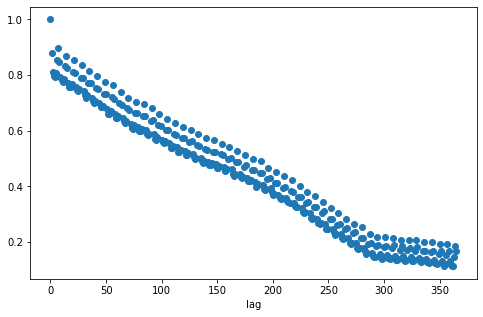

In [63]:
# Plot Autorcorrelación
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

<Figure size 1080x1080 with 0 Axes>

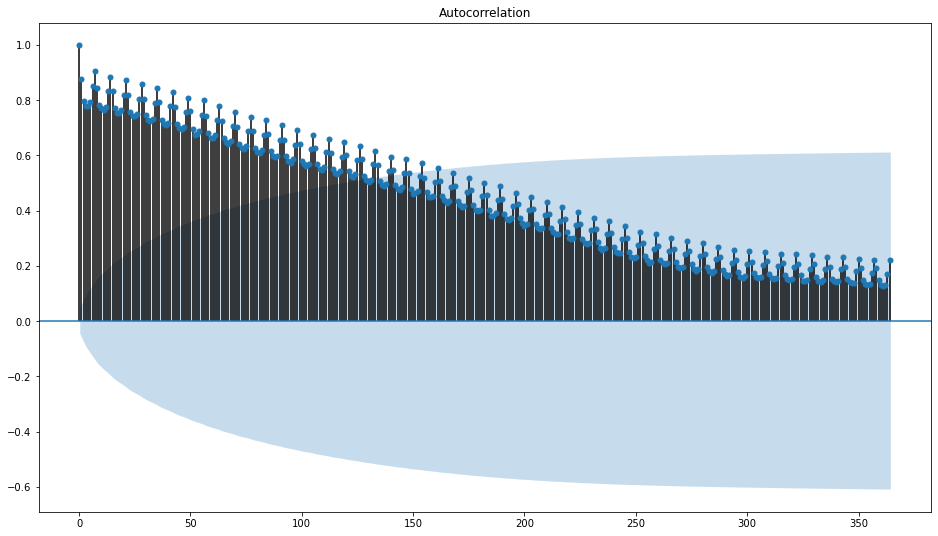

In [64]:
# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_d3, lags = np.arange(nlags))
plt.show()

La ejecución del ejemplo crea una gráfica 2D que muestra el valor de retraso a lo largo del eje xy la correlación en el eje y entre -1 y 1.

Los intervalos de confianza se dibujan como un cono. De forma predeterminada, se establece en un intervalo de confianza del 95%, lo que sugiere que los valores de correlación fuera de este cono son muy probablemente una correlación y no una casualidad estadística.

#### Dos años

In [65]:
days = 365 # Cantidad de días en 1 año.
years = 2 # Cantidad de años observados.

nlags= days*years           
autocorr = stattools.acf(dataset_illia_ef_st_d3, nlags= nlags)
autocorr.shape

(731,)

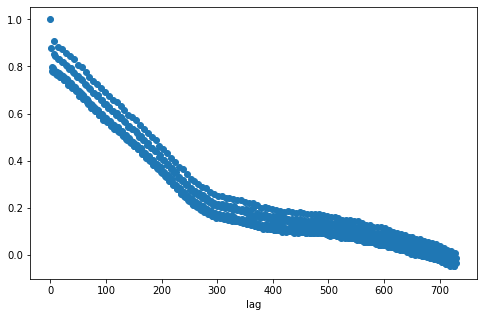

<Figure size 1080x1080 with 0 Axes>

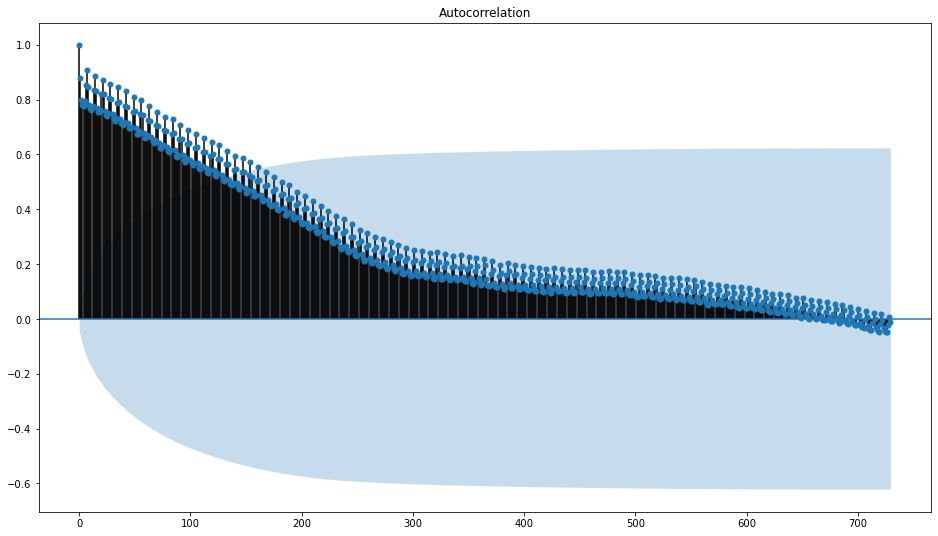

In [66]:
# Plot Autorcorrelación
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_d3, lags = np.arange(nlags))
plt.show()

#### Tres años

In [67]:
days = 365 # Cantidad de días en 1 año.
years = 3 # Cantidad de años observados.

nlags= days*years           
autocorr = stattools.acf(dataset_illia_ef_st_d3, nlags= nlags)
autocorr.shape

(1096,)

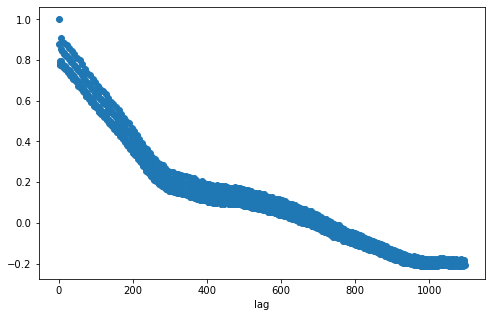

<Figure size 1080x1080 with 0 Axes>

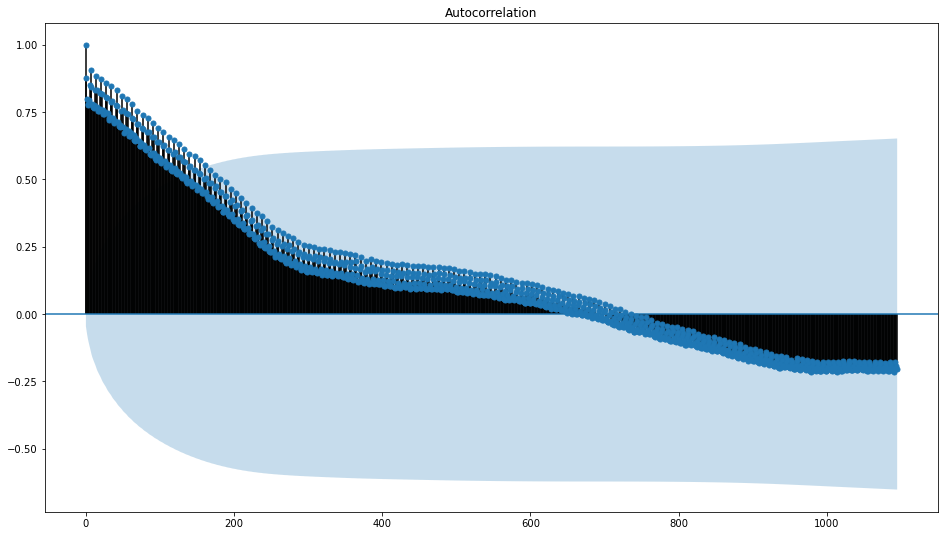

In [68]:
# Plot Autorcorrelación
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_d3, lags = np.arange(nlags))
plt.show()

#### Cuatro años

In [69]:
days = 365 # Cantidad de días en 1 año.
years = 4 # Cantidad de años observados.

nlags= days*years           
autocorr = stattools.acf(dataset_illia_ef_st_d3, nlags= nlags)
autocorr.shape

(1461,)

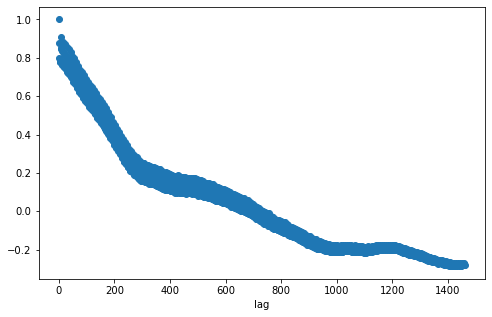

<Figure size 1080x1080 with 0 Axes>

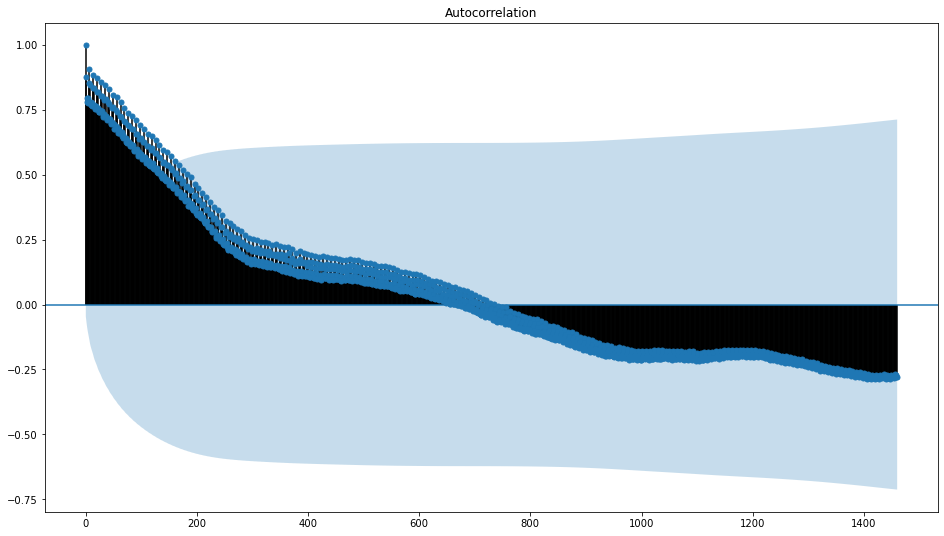

In [70]:
# Plot Autorcorrelación
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_d3, lags = np.arange(nlags))
plt.show()

#### **Conclusión Autocorrelaciones**

Por el tipo de dataset con el que trabajamos, entiendo que es muy difícil poder apreciar y graficar la Autocorrelacion en una frecuencia diaria. 

Es muy notorio como los datos de interés (zona no sombreada) se reducen a una pequeña parte. 


### Descomposición la Serie

La descomposición proporciona un modelo abstracto útil para **comprender** mejor los problemas durante el **análisis** y la **predicción** de series de tiempo.

Una **abstracción** útil para seleccionar métodos de pronóstico es dividir una serie de tiempo en **componentes**:
- **Sistemáticos**: Componentes de la serie temporal que tienen consistencia o recurrencia y pueden describirse y modelarse.
- **No sistemáticos**: componentes de la serie temporal que no se pueden modelar directamente.

Una serie de tiempo **consta de tres componentes sistemáticos** que incluyen **nivel, tendencia, estacionalidad y un** componente **no sistemático** llamado **ruido**.

Estos componentes se definen como:
- **Nivel**: el valor medio de la serie.
- **Tendencia**: el valor creciente o decreciente de la serie.
- **Estacionalidad**: el ciclo a corto plazo que se repite en la serie.
- **Ruido**: la variación aleatoria en la serie.


Es necesario pensar y abordar cada uno de estos componentes durante la preparación de datos, la selección del modelo y el ajuste del modelo. 

Se puede abordar explícitamente en términos de modelar la tendencia y restarla en los datos, o implícitamente proporcionando suficiente historial para que un algoritmo modele una tendencia, si es que existe.

Un **modelo aditivo** sugiere que los componentes se sumen de la siguiente manera:
	
`y(t) = Level + Trend + Seasonality + Noise`

Un modelo aditivo es lineal en el que los cambios a lo largo del tiempo se realizan constantemente en la misma cantidad.

Una tendencia lineal es una línea recta.

Una estacionalidad lineal tiene la misma frecuencia (ancho de ciclos) y amplitud (altura de ciclos).



Un **modelo multiplicativo** sugiere que los componentes se multipliquen de la siguiente manera:

`y(t) = Level * Trend * Seasonality * Noise`

Un modelo multiplicativo no es lineal, como cuadrático o exponencial. Los cambios aumentan o disminuyen con el tiempo.

Una tendencia no lineal es una línea curva.

Una estacionalidad no lineal tiene una frecuencia y / o amplitud creciente o decreciente a lo largo del tiempo.

Los problemas del mundo real son complicados y ruidosos. Puede haber componentes aditivos y multiplicativos. Puede haber una tendencia creciente seguida de una tendencia decreciente. Puede haber ciclos no repetidos mezclados con los componentes de estacionalidad repetidos.


Es por ello que quizá se pueda pueda o no, catalogar la serie de tiempo como un modelo aditivo o multiplicativo.

Veamos qué sucede con nuestra serie. Para ello, utilizaremos la función season_decompose (). El objeto resultante contiene las matrices para acceder a los cuatro datos de la descomposición.

In [71]:
decomp_diaria_add = tsa.seasonal.seasonal_decompose(
    dataset_illia_ef_st_d3.cantidad_pasos, model='additive', extrapolate_trend='freq'
)

decomp_diaria_mltp = tsa.seasonal.seasonal_decompose(
    dataset_illia_ef_st_d3.cantidad_pasos, model='multiplicative', extrapolate_trend='freq'
)

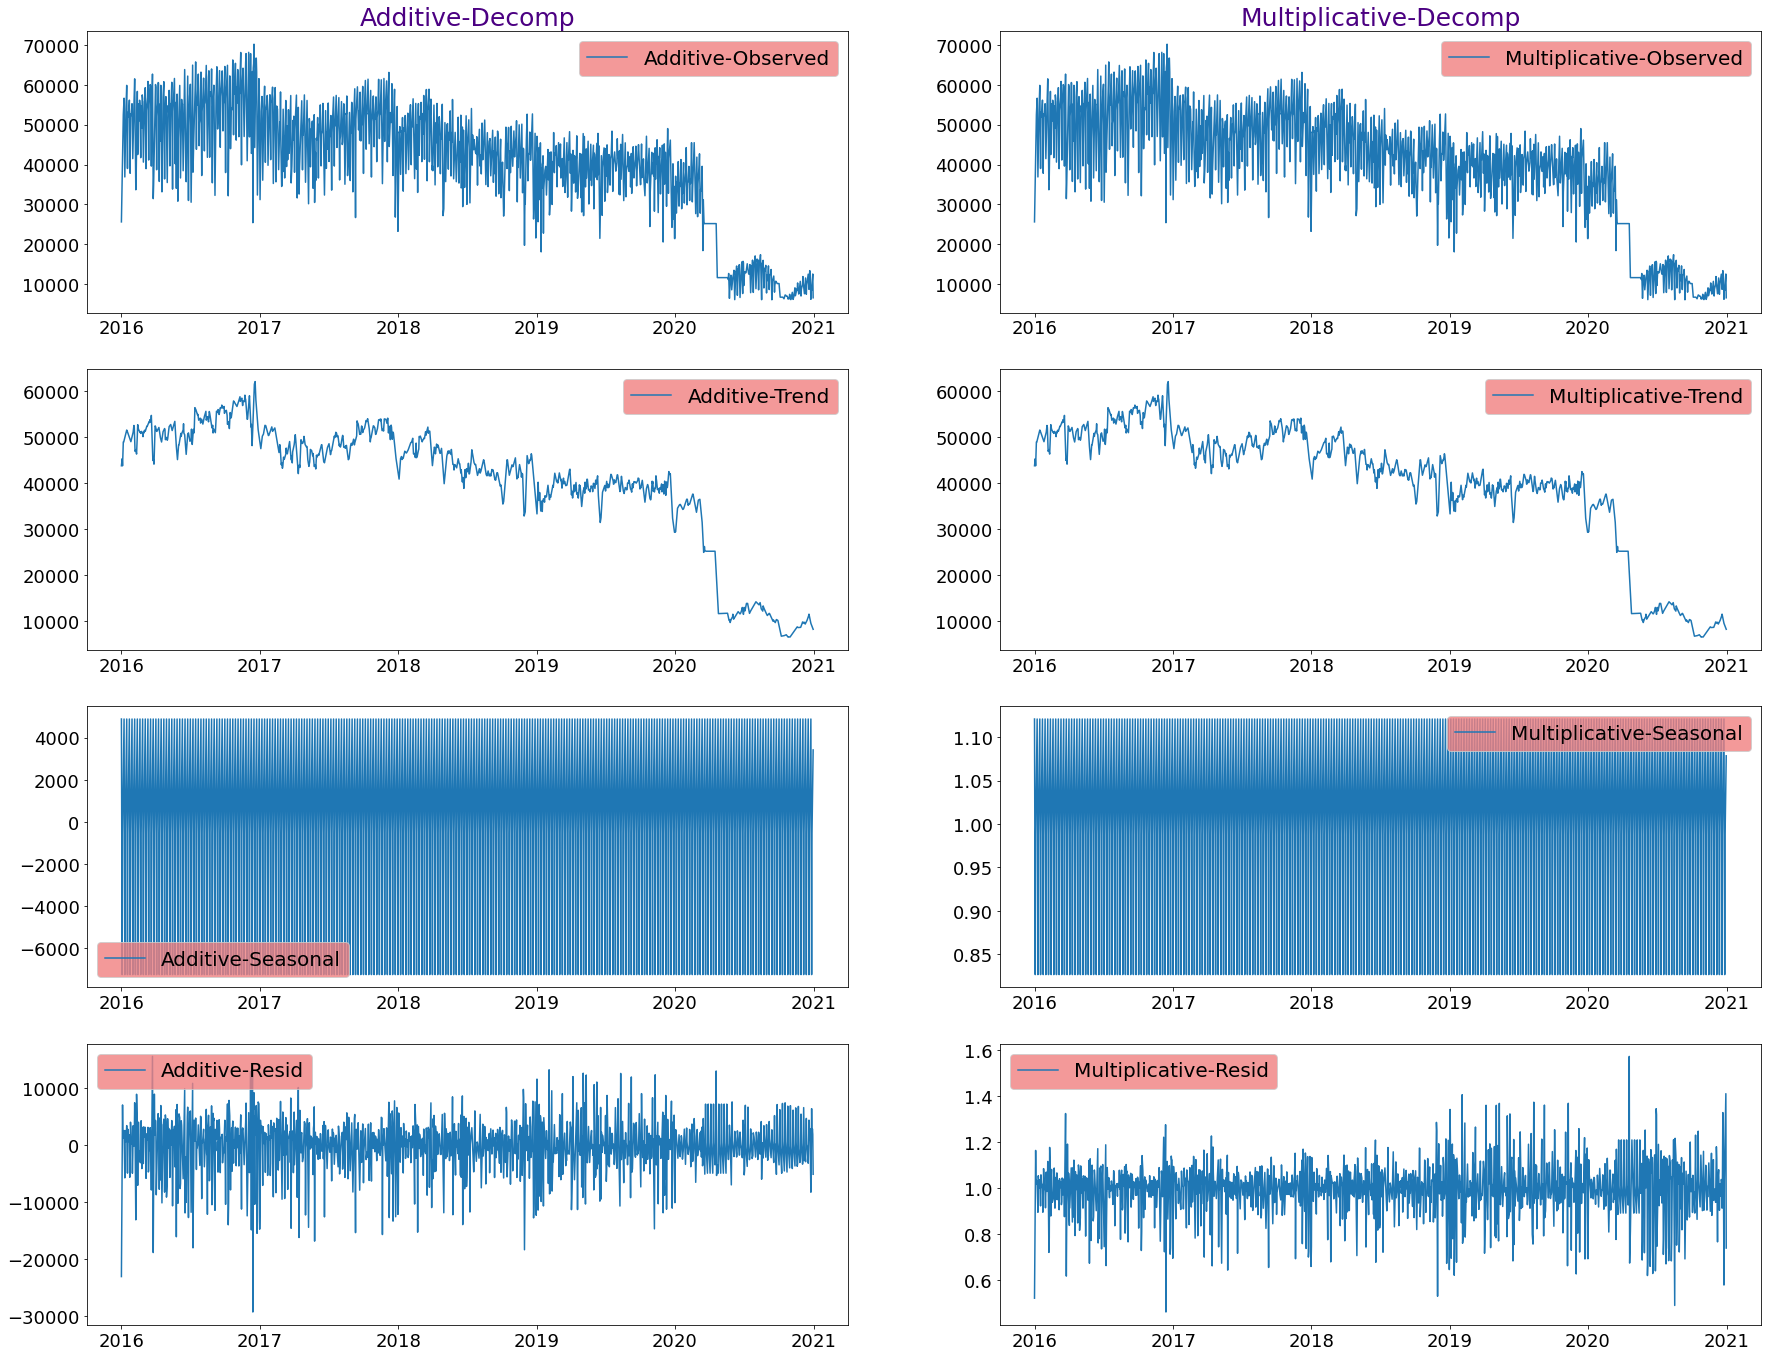

In [72]:
plt.figure(figsize=(30,30))

Gs= gs.GridSpec(5,2)
ax1= plt.subplot(Gs[0])
plt.title("Additive-Decomp", fontsize=25, color= "indigo")
plt.plot(decomp_diaria_add.observed, label= "Additive-Observed")
plt.legend(fontsize=20, facecolor= 'lightcoral')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax2= plt.subplot(Gs[1])
plt.title("Multiplicative-Decomp", fontsize=25, color= "indigo")
plt.plot(decomp_diaria_mltp.observed, label= "Multiplicative-Observed")
plt.legend(fontsize=20, facecolor= 'lightcoral')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax3= plt.subplot(Gs[2])
plt.plot(decomp_diaria_add.trend, label= "Additive-Trend")
plt.legend(fontsize=20, facecolor= 'lightcoral')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax4= plt.subplot(Gs[3])
plt.plot(decomp_diaria_mltp.trend, label= "Multiplicative-Trend")
plt.legend(fontsize=20, facecolor= 'lightcoral')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax5= plt.subplot(Gs[4])
plt.plot(decomp_diaria_add.seasonal, label= "Additive-Seasonal")
plt.legend(fontsize=20, facecolor= 'lightcoral')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax6= plt.subplot(Gs[5])
plt.plot(decomp_diaria_mltp.seasonal, label= "Multiplicative-Seasonal")
plt.legend(fontsize=20, facecolor= 'lightcoral', loc= 1)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)


ax7= plt.subplot(Gs[6])
plt.plot(decomp_diaria_add.resid, label= "Additive-Resid")
plt.legend(fontsize=20, facecolor= 'lightcoral', loc= 2)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax8= plt.subplot(Gs[7])
plt.plot(decomp_diaria_mltp.resid, label= "Multiplicative-Resid")
plt.legend(fontsize=20, facecolor= 'lightcoral')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

plt.show()

Al descomponer la serie con ambos modelos, observados que los gráficos son similares. 

Con la diferencia que en el modelo 'Aditivo' los "resids" tienen un comportamiento completamente aleatorio y una media en 0. 

Este indicio indica que podríamos estar ante la presencia de "White Noise", al contrario de los "resids" devueltos con el modelo "Multiplicativo".

Podemos ver que la información de tendencia y estacionalidad extraída de la serie sí parece razonable. Los residuales también son interesantes, mostrando períodos de alta variabilidad en el primer semestre de 2016, a inicios de 2017 (el más notorio) y en el último año de la serie.

#### Modelo Aditivo

`Value = Level + Trend + Seasonality + Noise`

In [73]:
serie_aditiva_check = pd.concat(
    [
     decomp_diaria_add.seasonal, 
     decomp_diaria_add.trend, 
     decomp_diaria_add.resid, 
     decomp_diaria_add.observed
    ], axis=1)
serie_aditiva_check.columns = ['seasonal', 'trend', 'resid', 'actual_values']
serie_aditiva_check.head()

seasonal     trend     resid  actual_values
fecha                                                  
2016-01-01   4883.51  43746.11 -23027.62       25602.00
2016-01-02  -3168.58  44511.41  -5206.84       36136.00
2016-01-03  -7250.37  45276.71   -801.34       37225.00
2016-01-04   -526.67  43741.14   7097.53       50312.00
2016-01-05    491.62  48175.86   1239.52       49907.00

Si los datos observados son correctos, la adición de 'seasonal' + 'trend' + 'resid' = 'actual_values'.

In [74]:
fecha_random = datetime.datetime.strftime(
    pd.to_datetime(
        np.random.choice(serie_aditiva_check.index)
        ),'%Y-%m-%d')

trend = float(serie_aditiva_check[serie_aditiva_check.index == fecha_random].trend.values)
seasonal = float(serie_aditiva_check[serie_aditiva_check.index == fecha_random].seasonal.values)
resid = float(serie_aditiva_check[serie_aditiva_check.index == fecha_random].resid.values)

actual_value = float(serie_aditiva_check[serie_aditiva_check.index == fecha_random].actual_values.values)

if round(trend + seasonal + resid) == actual_value :
    print("Es un modelo aditivo")
else:
    print("No es un modelo aditivo")

Es un modelo aditivo


#### Histograma de los Residuales

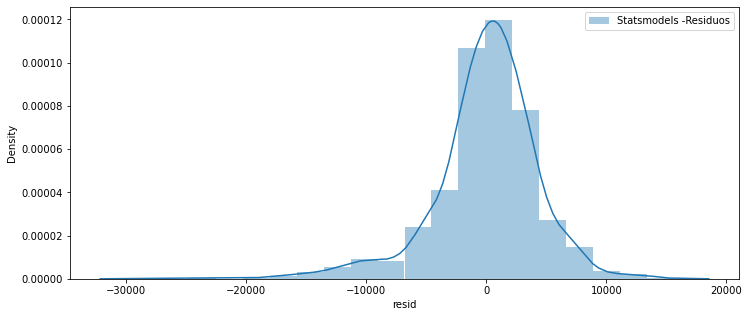

In [75]:
plt.rcParams['figure.figsize'] = [12,5]
sns.distplot(decomp_diaria_add.resid, bins=20, label="Statsmodels -Residuos")
plt.legend()
plt.show()

#### **Conclusión de la descomposición**

- En el primer gráfico se observa la serie en sí.

- El segundo gráfico devuelve la tendencia de la serie, la cual destacamos su negatividad.

- El tercer gráfico representa la estacionalidad. Es decir, que se pueden apreciar las fluctuaciones internas que suceden por dentro de la serie.

- El grafico "Resid", devuelve el ruido de la serie. Al observar que los residuales, se encuentran sin correlacion alguna y el promedio en general se encuentra fijo en 0, nos lleva a pensar que el rudio de nuestra serie es "White Noise" y estamos ante una serie apta para su modelado.

## Serie de tiempo - EDA - Frecuencia Semanal
Para poder observar los datos agrupados por semana, creamos una serie de tiempo, resampleada por esa unidad de tiempo.

### Resampleo por sumatoria

In [76]:
#Resampleo nuestros datos para agrupar por semana

dataset_illia_ef_st_w3 = pd.DataFrame()
display(Markdown('### DF sin Valores Atípicos')) 
dataset_illia_ef_st_w3 = dataset_illia_ef_st_d3.resample("w").sum()
display(dataset_illia_ef_st_w3)

### DF sin Valores Atípicos

cantidad_pasos
fecha                     
2016-01-03        98963.00
2016-01-10       342201.00
2016-01-17       359649.00
2016-01-24       346217.00
2016-01-31       348221.00
...                    ...
2020-12-06        68580.00
2020-12-13        65435.00
2020-12-20        73578.00
2020-12-27        67434.00
2021-01-03        41427.00

[262 rows x 1 columns]

Como se puede observar, la semana inicial y final de la serie, no cuenta con los 7 días. Es por ello, que hay una baja sustancial en la cantidad de pases.

### Resampleo por promedio

Con el objetivo de **equilibrar** la desproporción registrada en la **primer y última semana**, volvemos a resamplear los objetos creados pero ésta vez con el promedio. 

In [77]:
# Genero la serie con VA

dataset_illia_ef_st_w_mean = pd.DataFrame()
dataset_illia_ef_st_w_mean = dataset_illia_ef_st_d.resample("w").mean()
display(Markdown('### DF con Valores Atípicos')) 
display(dataset_illia_ef_st_w_mean)


# Genero la serie sin VA

dataset_illia_ef_st_w3_mean = pd.DataFrame()
dataset_illia_ef_st_w3_mean = dataset_illia_ef_st_d3.resample("w").mean()
display(Markdown('### DF sin Valores Atípicos')) 
display(dataset_illia_ef_st_w3_mean)


### DF con Valores Atípicos

cantidad_pasos
fecha                     
2016-01-03        32987.67
2016-01-10        48885.86
2016-01-17        51378.43
2016-01-24        49459.57
2016-01-31        49745.86
...                    ...
2020-12-06         9797.14
2020-12-13         9347.86
2020-12-20        10511.14
2020-12-27         9633.43
2021-01-03        10356.75

[262 rows x 1 columns]

### DF sin Valores Atípicos

cantidad_pasos
fecha                     
2016-01-03        32987.67
2016-01-10        48885.86
2016-01-17        51378.43
2016-01-24        49459.57
2016-01-31        49745.86
...                    ...
2020-12-06         9797.14
2020-12-13         9347.86
2020-12-20        10511.14
2020-12-27         9633.43
2021-01-03        10356.75

[262 rows x 1 columns]

In [78]:
# reseteo index para graficar
dataset_illia_ef_w3_mean = dataset_illia_ef_st_w3_mean.reset_index()
dataset_illia_ef_w_mean = dataset_illia_ef_st_w_mean.reset_index()

# Plot 
fig_efe_w_va= go.Figure()
fig_efe_w_va.add_trace(go.Scatter(x=dataset_illia_ef_w3_mean['fecha'], y=dataset_illia_ef_w3_mean['cantidad_pasos'],
                    mode='lines',
                    name='Original Mean'))
fig_efe_w_va.add_trace(go.Scatter(x=dataset_illia_ef_w_mean['fecha'], y=dataset_illia_ef_w_mean['cantidad_pasos'],
                    mode='lines',
                    name='Con VA Mean'))

fig_efe_w_va.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_efe_w_va.update_layout(
    title="Vehículos por semana (con y sin valores atípicos) - AU Illia - Pago en efectivo",
    width=1000,
    height=500,
)
fig_efe_w_va.show()


In [79]:
display(Markdown('### Estadísticos - DF Mean sin Valores Atípicos')) 
display(dataset_illia_ef_st_w3_mean.describe())

### Estadísticos - DF Mean sin Valores Atípicos

cantidad_pasos
count          262.00
mean         40168.79
std          13690.60
min           6509.86
25%          37295.64
50%          43891.86
75%          49710.79
max          58119.57

### Valores Faltantes

In [80]:
dataset_illia_ef_st_w_mean.index.to_series().diff().value_counts()

7 days    261
Name: fecha, dtype: int64

Diferencia de 7 días, por lo cual no hay Valores Faltantes.


### Graficamos la serie por años

In [81]:
fig_efe_w_va.update_xaxes(range=['2016-01-01', '2016-12-31'])
fig_efe_w_va.show()

In [82]:
fig_efe_w_va.update_xaxes(range=['2017-01-01', '2017-12-31'])
fig_efe_w_va.show()

In [83]:
fig_efe_w_va.update_xaxes(range=['2018-01-01', '2018-12-31'])
fig_efe_w_va.show()

In [84]:
fig_efe_w_va.update_xaxes(range=['2019-01-01', '2019-12-31'])
fig_efe_w_va.show()

In [85]:
fig_efe_w_va.update_xaxes(range=['2020-01-01', '2020-12-31'])
fig_efe_w_va.show()

### Último trimestre 2019

In [86]:
fig_efe_w_va.update_xaxes(range=['2019-10-01', '2019-12-31'])
fig_efe_w_va.show()

Se puede apreciar la caída en el registro de vehiculos para fines del año 2019.

### Autocorrelación

#### Un año

In [87]:
weeks = 52 # Cantidad de semanas en 1 año.
years = 1 # Cantidad de años observados.

nlags= weeks*years           
autocorr = stattools.acf(dataset_illia_ef_st_w3_mean, nlags = nlags)
autocorr.shape

(53,)

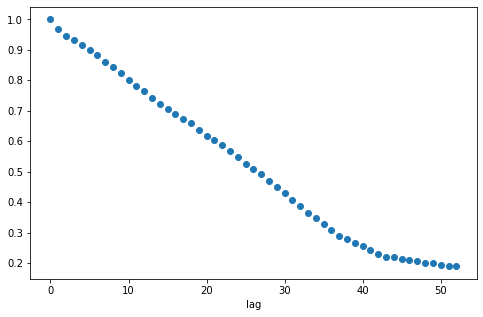

<Figure size 1080x1080 with 0 Axes>

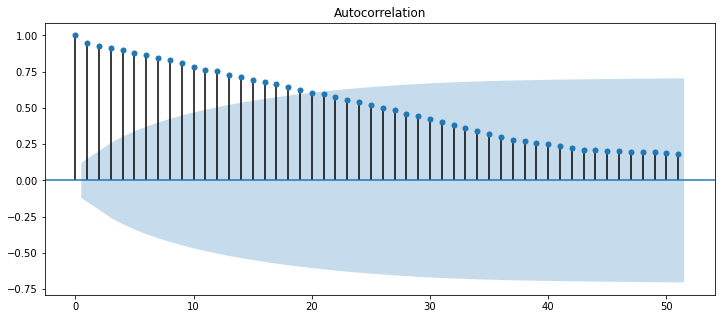

In [88]:
# Plot Autorcorrelación
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_w3, lags = np.arange(nlags))
plt.show()

#### Dos años

In [89]:
weeks = 52 # Cantidad de semanas en 1 año.
years = 2 # Cantidad de años observados.

nlags= weeks*years           
autocorr = stattools.acf(dataset_illia_ef_st_w3_mean, nlags= nlags)
autocorr.shape

(105,)

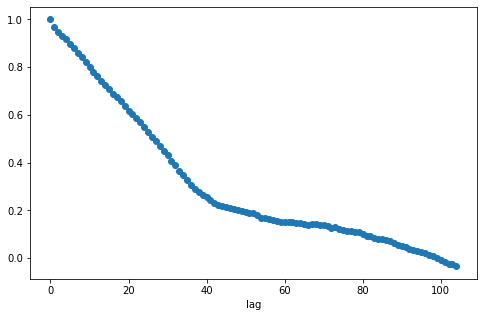

<Figure size 1080x1080 with 0 Axes>

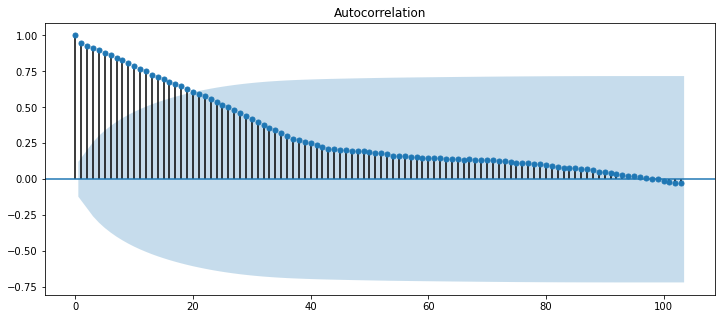

In [90]:
# Plot Autorcorrelación
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_w3, lags = np.arange(nlags))
plt.show()

#### Tres años

In [91]:
weeks = 52 # Cantidad de semanas en 1 año.
years = 3 # Cantidad de años observados.

nlags= weeks*years           
autocorr = stattools.acf(dataset_illia_ef_st_w3_mean, nlags= nlags)
autocorr.shape

(157,)

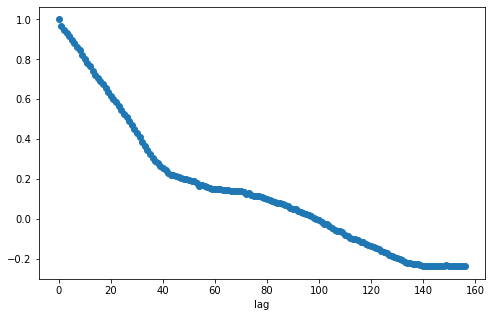

<Figure size 1080x1080 with 0 Axes>

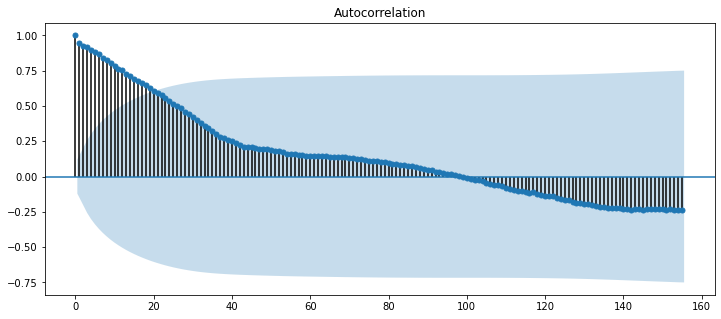

In [92]:
# Plot Autorcorrelación
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_w3, lags = np.arange(nlags))
plt.show()

#### Cuatro años

In [93]:
weeks = 52 # Cantidad de semanas en 1 año.
years = 4 # Cantidad de años observados.

nlags= weeks*years           
autocorr = stattools.acf(dataset_illia_ef_st_w3_mean, nlags= nlags)
autocorr.shape

(209,)

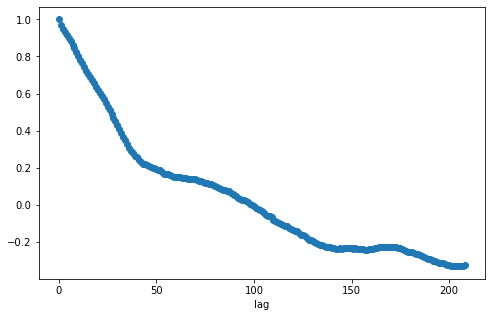

<Figure size 1080x1080 with 0 Axes>

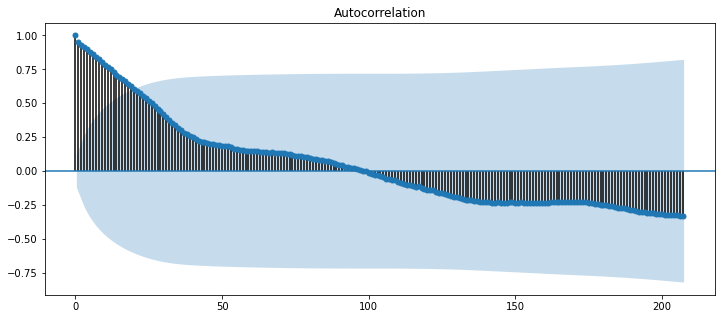

In [94]:
# Plot Autorcorrelación
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_w3, lags = np.arange(nlags))
plt.show()

#### **Conclusión Autocorrelaciones**


La observacion de los intervalos de confianza en los datos no cambia significativamente cuando los observamos en una frecuncia semanal.

### Descomposición la Serie

#### Modelo aditivo

In [95]:
decomp_semanal_add = tsa.seasonal.seasonal_decompose(
    dataset_illia_ef_st_w3_mean.cantidad_pasos, model='additive', extrapolate_trend='freq'
)

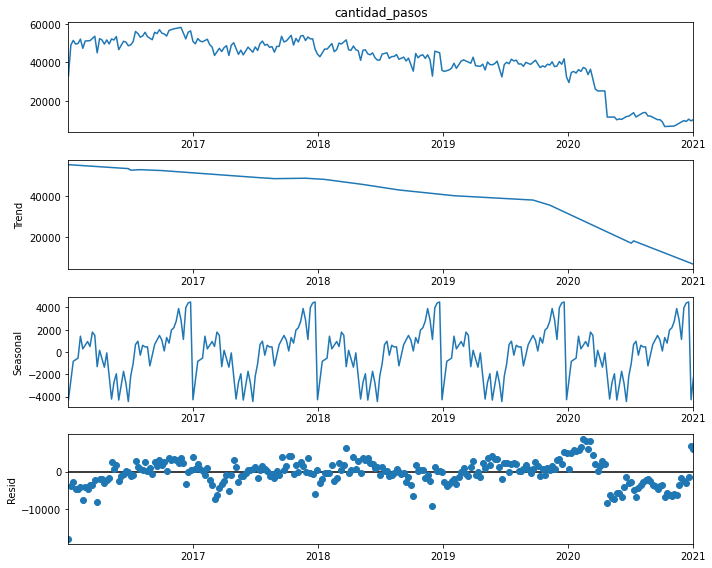

In [96]:
plt.rcParams['figure.figsize'] = [10,8]
decomp_semanal_add.plot()
plt.show()

#### **Conclusión de la descomposición**

- Trend devuelve la tendencia semanal, la cual expone mejor aún la tendencia negativa de la serie.

- Seasonal muestra las fluctuaciones internas de la serie. En esta frecuencia se puede apreciar mejor la estacionalidad. Está bien marcada, los picos (tanto negativos como positivos) se presentan en los mismos períodos de tiempo a lo largo de los 4 años.

- Resid refiere al ruido de la serie. Se sigue apreciando un comportamiento completamenta aletarorio en los datos.

#### Histograma de los Residuales

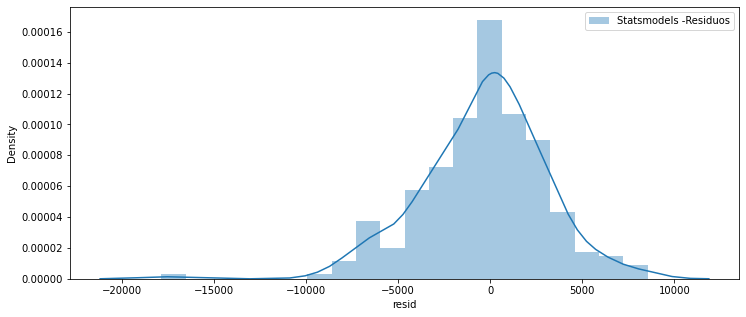

In [97]:
plt.rcParams['figure.figsize'] = [12,5]
sns.distplot(decomp_semanal_add.resid, bins=20, label="Statsmodels -Residuos")
plt.legend()
plt.show()

### **Conclusión de resampleo Frecuencia Semanal**

Como era de esperarse, dado que el año 2016 fue el que más vehículos registró, al buscar las semanas con mayor flujo vehicular obtenemos que las 10 más concurridas, son del año 2016.

Por otro lado, la descomosición de la serie mostró gráficos clarificadores.

Podríamos decir que la frecuencia semanal es la más atinada para el modelado y predicción del último trimestre del 2019 y el año 2020.

## Conclusión EDA

La serie no cuenta con **valores faltantes**, hemos detectado **valores atípicos**, y los mismos fueron tratados. La serie es apta para su modelado dado que es una serie **estacionaria** y los resids se consideran **white noise**.

Por otro lado, nos encontramos con un dataset con **tendencia** claramente **negativa**. Esto nos lleva a buscar explicaciones por fuera del dataset.

Realizando una investigación, encontramos notas periodísticas que apuntan al **aumento del combustible y de las tarifas de los peajes** como principal causa en la reducción del uso del automovil. Generando un incremento en el uso de trenes, colectivos y subtes.


En conclusión, los registros en la autopista Illia se ven directamente **afectados por**: 

- Las restricciones de circulación por la **pandemia**. 
- Los **aumentos** de tarifas de combustible y peajes. 
- **Medidas** del gobierno para promover el uso de menos autos para ir a la ciudad.
- Inauguración del **Paseo del Bajo** el cual condiciona a los vehículos pesados a transitar por otras vías.
- Incorporación de **Telepase**.
- **Obligatoriedad** de uso de telepase a partir del 28 de Septiembre del 2020.

Como mejoras de **implementación a futuro**, se podría agregar al dataset:

- La variable "precio de **combustible**". Para observar que a medida que el precio del combustible asciende el flujo de vehículos desciende. 
- La variable "tarifa de **peaje**". Para observar que a medida que aumenta, produce un descenso de vehículos en la autopista.

Por último, se define utilizar una **frecuencia semanal** para la predición de datos. Dado que es la frecuencia que pierde menos información sin sobre exigir a los modelos, conclusión a la que se llegó en el análisis exploratorio de datos del proyecto anterior.

# Preparacion de datos para entrenar modelos

La métrica de **evaluación** elegida para medir el error de los modelos es **RMSE**. Dado que la serie fue curada de valores atípicos.

Para poder entrenar los diferentes modelos, vamos a generar datasets según los objetivos que tenemos. Recordemos cuales son:

- Objetivo 1: predecir el último trimestre del 2019
- Objetivo 2: con el mejor modelo obtenido, predecir el 2020

## Datos para obj 1

### Datos Entrenamiento

In [98]:
# Divido mis dados para objetivo 1
st_train = dataset_illia_ef_st_w3_mean['2016-01-03':'2019-10-01']
st_train

cantidad_pasos
fecha                     
2016-01-03        32987.67
2016-01-10        48885.86
2016-01-17        51378.43
2016-01-24        49459.57
2016-01-31        49745.86
...                    ...
2019-09-01        39967.86
2019-09-08        39467.29
2019-09-15        38941.71
2019-09-22        39989.57
2019-09-29        41081.14

[196 rows x 1 columns]

### Datos Test

In [99]:
st_test_obj1 = dataset_illia_ef_st_w3_mean['2019-10-06':'2019-12-29']
df_test_obj1 = st_test_obj1.reset_index()
st_test_obj1

cantidad_pasos
fecha                     
2019-10-06        38926.14
2019-10-13        37262.86
2019-10-20        38163.86
2019-10-27        37564.29
2019-11-03        39018.43
2019-11-10        38648.00
2019-11-17        40255.71
2019-11-24        37785.71
2019-12-01        38079.29
2019-12-08        40413.00
2019-12-15        38994.29
2019-12-22        41840.14
2019-12-29        32341.43

## Datos para objetivo 2

In [100]:
st_test_obj2 = dataset_illia_ef_st_w3_mean['2020-01-05':'2021-01-03']
df_test_obj2 = st_test_obj2.reset_index()
st_test_obj2

cantidad_pasos
fecha                     
2020-01-05        29513.29
2020-01-12        34765.57
2020-01-19        35259.71
2020-01-26        34456.00
2020-02-02        36190.71
2020-02-09        35306.43
2020-02-16        37351.14
2020-02-23        36728.00
2020-03-01        33641.00
2020-03-08        36415.71
2020-03-15        31827.57
2020-03-22        26196.71
2020-03-29        25174.00
2020-04-05        25174.00
2020-04-12        25174.00
2020-04-19        25174.00
2020-04-26        11616.00
2020-05-03        11616.00
2020-05-10        11616.00
2020-05-17        11616.00
2020-05-24        10211.14
2020-05-31        10655.86
2020-06-07        10408.71
2020-06-14        11421.14
2020-06-21        11883.29
2020-06-28        12070.00
2020-07-05        12964.71
2020-07-12        13868.43
2020-07-19        11667.14
2020-07-26        12521.29
2020-08-02        13750.29
2020-08-09        13879.00
2020-08-16        14010.29
2020-08-23        12162.43
2020-08-30        12143.14
2020-09-06        11446.86
2020-09-13        11162.43
2020-09-20        10248.86
2020-09-27        10283.14
2020-10-04         9149.71
2020-10-11         6709.00
2020-10-18         6766.43
2020-10-25         6875.86
2020-11-01         6509.86
2020-11-08         6977.14
2020-11-15         7577.14
2020-11-22         8740.14
2020-11-29         8290.00
2020-12-06         9797.14
2020-12-13         9347.86
2020-12-20        10511.14
2020-12-27         9633.43
2021-01-03        10356.75

# Predicciones a futuro

## Benchmark: XGBoostR Optimizado

Para el modelo Benchmark, tomaremos el XGBoostR Optimizado que obtuvimos el en proyecto anterior.


La idea del XGBoost, es ir entrenando modelos simples y que cada uno vaya aprendiendo de los errores del anterior, por lo que, para seguir con la simplicidad de los modelos, no vamos a entrenar un XGBoost con profundidad mayor a 4 para y evitar la complejización del modelo.

### Preparación de datos

Para el modelo XGBoost, tendremos que preparar los datos. Realizar el train/test split, entrenar el modelo, predecir y calcular el error.

In [101]:
data_XGB = st_train.cantidad_pasos
N = data_XGB.shape[0]
print(N)

196


In [102]:
look_back = 12 # Numero de semanas anteriores para predecir el valor siguiente.

X = np.zeros((N - look_back - 1, look_back))
Y = np.zeros(N - look_back - 1)

print(X.shape, Y.shape)

(183, 12) (183,)


In [103]:
# Llenado de datos
for i in range(X.shape[0]):
    X[i,:] = data_XGB.iloc[i:i+look_back]
    Y[i] = data_XGB.iloc[i+look_back]

In [104]:
print('Tamaño de X')
print(X.shape)
print()
print('Valores de X')
print(X)

Tamaño de X
(183, 12)

Valores de X
[[32987.66666667 48885.85714286 51378.42857143 ... 51234.28571429
  52603.71428571 53537.57142857]
 [48885.85714286 51378.42857143 49459.57142857 ... 52603.71428571
  53537.57142857 44919.42857143]
 [51378.42857143 49459.57142857 49745.85714286 ... 53537.57142857
  44919.42857143 52280.28571429]
 ...
 [37277.14285714 32446.14285714 38837.85714286 ... 39216.14285714
  37942.         39967.85714286]
 [32446.14285714 38837.85714286 40022.85714286 ... 37942.
  39967.85714286 39467.28571429]
 [38837.85714286 40022.85714286 39264.57142857 ... 39967.85714286
  39467.28571429 38941.71428571]]


In [105]:
print('Tamaño de Y')
print(Y.shape)
print()
print('Valores de Y')
print(Y)

Tamaño de Y
(183,)

Valores de Y
[44919.42857143 52280.28571429 51581.57142857 49467.14285714
 51625.42857143 49531.57142857 52121.85714286 51574.28571429
 53385.28571429 46565.71428571 49113.85714286 50931.71428571
 50490.         48575.         49060.85714286 50644.71428571
 56011.14285714 54911.57142857 53023.         53691.57142857
 55578.14285714 53296.14285714 52524.28571429 51713.71428571
 55606.71428571 54884.71428571 56933.14285714 55136.14285714
 54740.71428571 53638.71428571 56525.71428571 57130.57142857
 57371.         57738.         57847.42857143 58119.57142857
 54914.         52161.28571429 55605.42857143 56308.
 50852.57142857 49601.71428571 52344.71428571 51030.71428571
 50654.42857143 51343.         51967.71428571 49125.28571429
 47913.57142857 43558.28571429 45927.71428571 47256.28571429
 45583.28571429 47613.85714286 48639.57142857 43558.85714286
 48889.28571429 50135.14285714 46553.57142857 44153.14285714
 46320.         43864.85714286 45705.28571429 47878.14285714

### Train / Test Split

In [106]:
N_train = Y.shape[0] - look_back        # Cantidad de semanas que uso para entrenar
N_test = look_back                   # Cantidad de semanas que uso para evaluar.

N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
Y_train = Y[:N_train]
print(X_train.shape, Y_train.shape)

X_test = X[N_train:N_train+N_test,:]
Y_test = Y[N_train:N_train+N_test]
print(X_test.shape, Y_test.shape)

(171, 12) (171,)
(12, 12) (12,)


### Entrenamiento con Hiperparámetros

In [107]:
# Asigno los parámetros obtenidos en el proyecto anterior 
colsample_bytree = 0.7
learning_rate = 0.4
max_depth = 3
n_estimators = 10
objective = 'reg:squarederror'

In [108]:
xgbr = XGBRegressor(
                  colsample_bytree = colsample_bytree,
                  learning_rate = learning_rate,
                  max_depth = max_depth,
                  n_estimators = n_estimators,
                  objective = objective,
                  eval_metric= 'rmse')

xgbr.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.4, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [109]:
# Cross Validation
tss = TimeSeriesSplit(n_splits=2)

In [110]:
best_score_train = abs(cross_val_score(
    xgbr, X_train, Y_train, cv=tss, scoring="neg_root_mean_squared_error")
)
best_score_test = abs(cross_val_score(
    xgbr, X_test, Y_test, cv=tss,  scoring="neg_root_mean_squared_error"))

print("Mejor Score en Train (CV = 10) %0.2f (+/- %0.2f)" %
      (best_score_train.mean(), best_score_train.std()))

print("Mejor Score en Test (CV = 10) %0.2f (+/- %0.2f)" %
      (best_score_test.mean(), best_score_test.std()))

Mejor Score en Train (CV = 10) 3786.80 (+/- 1275.15)
Mejor Score en Test (CV = 10) 956.32 (+/- 292.18)


### Predicción

In [111]:
Y_train_pred_xgb = xgbr.predict(X_train)
Y_test_pred_xgb = xgbr.predict(X_test)

In [112]:
xgb_results_pred = pd.DataFrame()
xgb_results_pred['fecha'] = data_XGB.index[N_train+look_back: length_total]
xgb_results_pred['Pred XGB'] = Y_test_pred_xgb

### RMSE

In [113]:
rmse_train_xgbr = np.sqrt(mean_squared_error(Y_train, Y_train_pred_xgb))
rmse_test_xgbr = np.sqrt(mean_squared_error(Y_test, Y_test_pred_xgb))

print(f"XGBRegressor en Train")
print("-----------------------")
print(f"RMSE-Train: ", rmse_train_xgbr)
print("\n")
print(f"XGBRegressor en Test")
print("-----------------------")
print(f"RMSE-Test: ", rmse_test_xgbr)

XGBRegressor en Train
-----------------------
RMSE-Train:  1879.3137449821686


XGBRegressor en Test
-----------------------
RMSE-Test:  1642.2158369463286


### Gráfico

In [114]:
# Plot 
text_title = 'XGBoost con Hiperparámetros - AU Illia - Predicción Pago en efectivo - RMSE ' + str(round(rmse_test_xgbr,2))
fig_predict = px.line()
fig_predict.add_scatter(x=data_XGB.index[:length_total], y=data_XGB, mode='lines+markers', name="Real")
fig_predict.add_scatter(x=data_XGB.index[look_back: look_back + N_train], y=Y_train_pred_xgb, mode='lines+markers', name="Train-Pred")
fig_predict.add_scatter(x=data_XGB.index[N_train+look_back: length_total], y=Y_test_pred_xgb, mode='lines+markers', name="Test-pred")
fig_predict.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_predict.update_layout(
    width=1000,
    height=500,)
fig_predict.show()

In [115]:
fig_predict.update_xaxes(range=['2019-07-01', '2019-09-22'])
fig_predict.show()

### Importance Features

¿Qué variables fueron relevantes para el modelo para hacer la predicción?

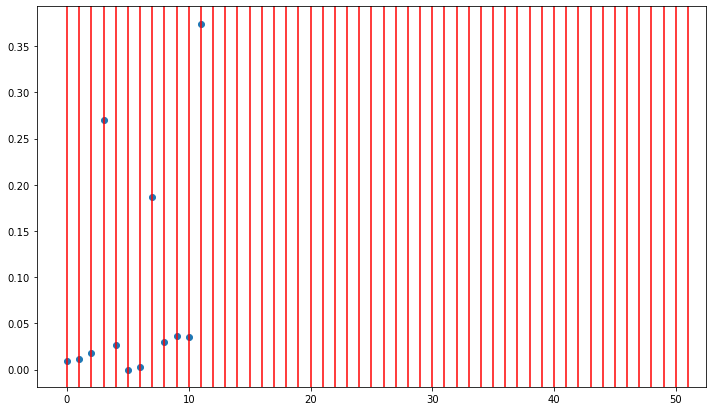

In [116]:
plt.figure(figsize = (12,7))

plt.scatter(np.arange(xgbr.feature_importances_.size),xgbr.feature_importances_)

for x in range(52):
    plt.axvline(x, linestyle ='-', color= 'r')
    
plt.show()

De las 12 semanas utilizadas para predecir el valor siguiente, XGBoost Regressor le otorga mayor "importancia" a las que se encuentran al final. La más importante es la semana 11 del trimestre.

### Conclusión

El modelo **XGBoost optimizado**  fue el modelo que tuvo **mejor desempeño** en el proyecto anterior. Devuelve un error RMSE inferior (1642 aprox.) 

Si bien se acerca a los valores e incluso acierta a los puntos, mi desafío en este proyecto es experimentar con otros modelos de machine learning.

## Predicción último trimestre de 2019

Para predecir el último trimestre del 2019, utilizaremos nuestro modelo XGBoost regressor optimizado. 

Crearemos nuestros datos de entrenamiento y luego mediante la estrategia Multi-Step prediction, realizaremos la predicción de las 12 semanas restantes.

Es decir, se predicen las semanas de a una, incorporando la última predicha como dato para predecir la siguiente. 

Este método puede llegar a tener una gran desventaja. Si el modelo no es preciso, arrastraremos los errores en cada predicción.

### Preparación de datos

In [117]:
start_date = '2019-07-14'
end_date = '2019-09-29'

XGB_predict = dataset_illia_ef_st_w3_mean[
  (dataset_illia_ef_st_w3_mean.index >= start_date) & 
  (dataset_illia_ef_st_w3_mean.index <= end_date)
].values
XGB_predict.shape

(12, 1)

In [118]:
XGB_predict

array([[39264.57142857],
       [41633.        ],
       [40688.85714286],
       [41110.42857143],
       [39123.85714286],
       [39216.14285714],
       [37942.        ],
       [39967.85714286],
       [39467.28571429],
       [38941.71428571],
       [39989.57142857],
       [41081.14285714]])

In [119]:
XGB_predict = XGB_predict.reshape(1,-1)
XGB_predict.shape

(1, 12)

### Predicción

In [120]:
i = 0
result_predict = []
    
while (i <=12):
    val_predict = xgbr.predict(XGB_predict)
    #print('val_predict:', val_predict)
    new_predict = XGB_predict
    new_predict = np.append(new_predict, val_predict) #agregar la predicción al último elemento
    new_predict = np.delete(new_predict, 0) #eliminar el primer elemento
    new_predict = new_predict.reshape(1,-1)
    result_predict.append(val_predict.tolist())
    XGB_predict = new_predict
    i = i+1  

In [121]:
#result_predict

In [122]:
resultados = np.asarray(result_predict)
resultados.shape

(13, 1)

In [123]:
st_test_obj1

cantidad_pasos
fecha                     
2019-10-06        38926.14
2019-10-13        37262.86
2019-10-20        38163.86
2019-10-27        37564.29
2019-11-03        39018.43
2019-11-10        38648.00
2019-11-17        40255.71
2019-11-24        37785.71
2019-12-01        38079.29
2019-12-08        40413.00
2019-12-15        38994.29
2019-12-22        41840.14
2019-12-29        32341.43

In [124]:
df_result_2019 = pd.DataFrame(pd.date_range('2019-10-06','2019-12-29', freq='W'))
df_result_2019.rename(columns = {0:'Fecha'}, inplace = True) 
df_result_2019['Pred XGB'] = resultados

In [125]:
st_result_2019 = df_result_2019.set_index(['Fecha'])
st_result_2019['Real'] = st_test_obj1['cantidad_pasos']
st_result_2019

Pred XGB      Real
Fecha                         
2019-10-06  38975.43  38926.14
2019-10-13  39160.40  37262.86
2019-10-20  39058.61  38163.86
2019-10-27  38504.88  37564.29
2019-11-03  38504.88  39018.43
2019-11-10  37998.48  38648.00
2019-11-17  38504.88  40255.71
2019-11-24  38504.88  37785.71
2019-12-01  37998.48  38079.29
2019-12-08  38654.00  40413.00
2019-12-15  37998.48  38994.29
2019-12-22  37998.48  41840.14
2019-12-29  37998.48  32341.43

### RMSE

In [126]:
rmse_xgbr_2019 = np.sqrt(mean_squared_error(st_result_2019['Real'], st_result_2019['Pred XGB']))

print(f"XGBRegressor Predicción Último Trimestre del 2019")
print("-----------------------")
print(f"RMSE-Test: %.3f" %  rmse_xgbr_2019)


XGBRegressor Predicción Último Trimestre del 2019
-----------------------
RMSE-Test: 2155.663


### Grafico

In [127]:
df_result_2019 = st_result_2019.reset_index()

In [128]:
# Plot 
fig_predict_2019 = go.Figure()
fig_predict_2019.add_trace(go.Scatter(x=df_result_2019['Fecha'], y=df_result_2019['Real'],
                    mode='lines+markers',
                    name='Real'))
fig_predict_2019.add_trace(go.Scatter(x=df_result_2019['Fecha'], y=df_result_2019['Pred XGB'],
                    mode='lines+markers',
                    name='XGBoost'))

fig_predict_2019.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_predict_2019.update_layout(
    title="AU Illia - Predicción Efectivo - Último trimestre 2019",
    width=800,
    height=500,
)
fig_predict_2019.show()

## Predicción año 2020

Para predecir el 2020, utilizaremos nuestro modelo XGBoost regressor optimizado. 

Cargaremos nuestros datos de entrada y luego mediante la estrategia Multi-Step prediction, realizaremos la predicción de las 52 semanas del 2020.

Es decir, se predicen las semanas de a una, incorporando la última predicha como dato para predecir la siguiente. 

Recordemos que este método puede llegar a tener una gran desventaja. Si el modelo no es preciso, arrastraremos los errores en cada predicción.

### Preparación de datos

In [129]:
start_date = '2019-10-07'
end_date = '2019-12-29'

XGB_predict = dataset_illia_ef_st_w3_mean[
  (dataset_illia_ef_st_w3_mean.index >= start_date) & 
  (dataset_illia_ef_st_w3_mean.index <= end_date)
].values
XGB_predict.shape

(12, 1)

In [130]:
XGB_predict

array([[37262.85714286],
       [38163.85714286],
       [37564.28571429],
       [39018.42857143],
       [38648.        ],
       [40255.71428571],
       [37785.71428571],
       [38079.28571429],
       [40413.        ],
       [38994.28571429],
       [41840.14285714],
       [32341.42857143]])

In [131]:
XGB_predict = XGB_predict.reshape(1,-1)
XGB_predict.shape

(1, 12)

### Predicción

In [132]:
i = 0
result_predict = []
    
while (i <=51):
    val_predict = xgbr.predict(XGB_predict)
    #print('val_predict:', val_predict)
    new_predict = XGB_predict
    new_predict = np.append(new_predict, val_predict) #agregar la predicción al último elemento
    new_predict = np.delete(new_predict, 0) #eliminar el primer elemento
    new_predict = new_predict.reshape(1,-1)
    result_predict.append(val_predict.tolist())
    XGB_predict = new_predict
    i = i+1  

In [133]:
#result_predict

In [134]:
resultados_2020 = np.asarray(result_predict)
resultados_2020.shape

(52, 1)

In [135]:
df_result_2020 = pd.DataFrame(pd.date_range('2020-01','2021-01', freq='W'))
df_result_2020.rename(columns = {0:'Fecha'}, inplace = True) 
df_result_2020['Pred XGB'] = resultados_2020
st_result_2020 = df_result_2020.set_index(['Fecha'])
st_result_2020['Real'] = st_test_obj2['cantidad_pasos']
st_result_2020

Pred XGB      Real
Fecha                         
2020-01-05  38611.94  29513.29
2020-01-12  39565.01  34765.57
2020-01-19  37998.48  35259.71
2020-01-26  37998.48  34456.00
2020-02-02  38504.88  36190.71
2020-02-09  37998.48  35306.43
2020-02-16  38504.88  37351.14
2020-02-23  36318.31  36728.00
2020-03-01  38654.00  33641.00
2020-03-08  38504.88  36415.71
2020-03-15  37998.48  31827.57
2020-03-22  37998.48  26196.71
2020-03-29  37998.48  25174.00
2020-04-05  37998.48  25174.00
2020-04-12  37998.48  25174.00
2020-04-19  37998.48  25174.00
2020-04-26  37998.48  11616.00
2020-05-03  37998.48  11616.00
2020-05-10  37998.48  11616.00
2020-05-17  37998.48  11616.00
2020-05-24  37998.48  10211.14
2020-05-31  37998.48  10655.86
2020-06-07  37998.48  10408.71
2020-06-14  37998.48  11421.14
2020-06-21  37998.48  11883.29
2020-06-28  37998.48  12070.00
2020-07-05  37998.48  12964.71
2020-07-12  37998.48  13868.43
2020-07-19  37998.48  11667.14
2020-07-26  37998.48  12521.29
2020-08-02  37998.48  13750.29
2020-08-09  37998.48  13879.00
2020-08-16  37998.48  14010.29
2020-08-23  37998.48  12162.43
2020-08-30  37998.48  12143.14
2020-09-06  37998.48  11446.86
2020-09-13  37998.48  11162.43
2020-09-20  37998.48  10248.86
2020-09-27  37998.48  10283.14
2020-10-04  37998.48   9149.71
2020-10-11  37998.48   6709.00
2020-10-18  37998.48   6766.43
2020-10-25  37998.48   6875.86
2020-11-01  37998.48   6509.86
2020-11-08  37998.48   6977.14
2020-11-15  37998.48   7577.14
2020-11-22  37998.48   8740.14
2020-11-29  37998.48   8290.00
2020-12-06  37998.48   9797.14
2020-12-13  37998.48   9347.86
2020-12-20  37998.48  10511.14
2020-12-27  37998.48   9633.43

In [136]:
df_result_2020 = st_result_2020.reset_index()

### RMSE

In [137]:
rmse_xgbr_2020 = np.sqrt(mean_squared_error(df_result_2020['Real'], df_result_2020['Pred XGB']))

print(f"XGBRegressor Predicción 2020")
print("-----------------------")
print(f"RMSE-Test: %.3f" %  rmse_xgbr_2020)

XGBRegressor Predicción 2020
-----------------------
RMSE-Test: 23318.825


### Graficamos

In [138]:
# Plot 
fig_predict_2020 = go.Figure()
fig_predict_2020.add_trace(go.Scatter(x=df_result_2020['Fecha'], y=df_result_2020['Real'],
                    mode='lines+markers',
                    name='Real'))
fig_predict_2020.add_trace(go.Scatter(x=df_result_2020['Fecha'], y=df_result_2020['Pred XGB'],
                    mode='lines+markers',
                    name='Pred XGB'))

fig_predict_2020.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_predict_2020.update_layout(
    title="AU Illia - Predicción Efectivo - Año 2020",
    width=800,
    height=500,
)
fig_predict_2020.show()

Como se puede observar, el año 2020 fue atípico en la historia de la humanidad. Nos atravesó una pandemia que generó tomar medidas tales como restricciones en la circularión tanto de personas como vehículos.

El modelo elegido, predice sobre las predicciones anteriores obtenidas. Esto genera que no aprenda mientras fluye el tiempo y si hay errores en la predicción, los arrastra.

Como **conclución** para poder generar una predicción más atinada para el 2020, deberiamos implementar seguramente modelos más complejos y que **contengan más parametros** en cuenta.

# Redes Neuronales

Mi objetivo académico para este proyecto, es experimentar con diferentes modelos de redes neuronales y comparar los resultados de esos modelos.

En estos meses me propuse indagar, aprender, entender y experimentar lo más posible con redes neuronales.
Si algo aprendí en este camino de aprendizaje es que es un tema super extenso, complejo, y hay infinitas viariantes para diseñar y entrenar una red.

Una vez que pude internalizar los conceptos, me propuse crear y entrenar 3 tipos de redes:
- LSTM univariable
- LSTM multivariable
- LSTM con autoencoders

Para hacer más justa la comparación de modelos, la constante que decidí adoptar es:
- Todos los modelos son entrenados con series de tiempo resampleados en semandas.
- Todos los modelos toman datos de las 12 semanas anteriores, para predecir la siguiente.
- Todos los modelos se entrenan 50 épocas.

El desafío no sólo fue comprender los modelos, las capas, sino realizar las transformaciones de datos que se necesitaron tanto para la preparación de la entrada como para descifrar la salida.
En cada una de las variantes desarrolladas hay un gran trabajo de preparación tanto de inputs, como de outputs para poder medir realmente los modelos.

Sin hacer más spolier de lo que vendrá, sólo me resta mencionar que todas ellas se basan el las librerías de Keras y TensorFlow.

## Intro

Red Neuronal LSTM (Long Short Term Memory)

>Son un tipo especial de red neuronal recurrente capaz de aprender dependencias temporales largas, ya que conservan el error y además lo pueden propagar a través del tiempo y las capas. 
>
>Las neuronas de las LSTMs contienen información fuera del flujo normal de la red recurrente en una celda cerrada. 
>
>Esta información se puede almacenar, escribir o leer en una celda. La celda toma decisiones sobre qué almacenar, y cuándo permitir lecturas, escrituras y borrados a través de puertas que se abren y cierran. 
>
>Estas puertas son analógicas, implementadas con la multiplicación de elementos por los sigmoides (están todos en el rango de 0-1). 
>
>Las puertas actúan sobre las señales que reciben, y similares a los nodos de la red neuronal, bloquean o transmiten información basada en su fuerza e importación, que filtran con sus propios conjuntos de pesos. 
>
>Estos pesos, como los pesos que modulan la entrada y los estados ocultos, se ajustan a través del proceso de aprendizaje de las redes recurrentes. 
>Es decir, las celdas aprenden cuándo permitir que los datos entren, salgan o se eliminen a través del proceso iterativo de hacer conjeturas, error de retropropagación y ajustar pesos a través del descenso de gradiente.

## Preprocesamiento

Para trabajar con RRNN, tendremos que convertir los datos de entrada en un dataframe que pueda alimentar la red, y que la misma pueda ser entrenada con **backpropagation**. 

Para hacer esta transformación usaré una función llamada series_to_supervised()


In [139]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## LSTM1

En principio vamos a crear un modelo de red muy sencilla que ingresando 12 semanas previas, predice la semana siguiente.

La única variable utilizada para el modelo es la cantidad de pasos de vehículos.

### Preprocesado de Datos

In [140]:
PASOS = 12

# load dataset
values = st_train.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

Entonces aqui vemos cómo queda nuestro set de datos de entrada.

In [141]:
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  \
12         0.02        0.64        0.74       0.66       0.67       0.76   
13         0.64        0.74        0.66       0.67       0.76       0.58   
14         0.74        0.66        0.67       0.76       0.58       0.72   
15         0.66        0.67        0.76       0.58       0.72       0.72   
16         0.67        0.76        0.58       0.72       0.72       0.73   
..          ...         ...         ...        ...        ...        ...   
191        0.32        0.19        0.00       0.25       0.30       0.27   
192        0.19        0.00        0.25       0.30       0.27       0.36   
193        0.00        0.25        0.30       0.27       0.36       0.32   
194        0.25        0.30        0.27       0.36       0.32       0.34   
195        0.30        0.27        0.36       0.32       0.34       0.26   

     var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)  
12        0.58       0.72       0.72       0.73       0.79       0.82     0.49  
13        0.72       0.72       0.73       0.79       0.82       0.49     0.77  
14        0.72       0.73       0.79       0.82       0.49       0.77     0.75  
15        0.73       0.79       0.82       0.49       0.77       0.75     0.66  
16        0.79       0.82       0.49       0.77       0.75       0.66     0.75  
..         ...        ...        ...        ...        ...        ...      ...  
191       0.36       0.32       0.34       0.26       0.26       0.21     0.29  
192       0.32       0.34       0.26       0.26       0.21       0.29     0.27  
193       0.34       0.26       0.26       0.21       0.29       0.27     0.25  
194       0.26       0.26       0.21       0.29       0.27       0.25     0.29  
195       0.26       0.21       0.29       0.27       0.25       0.29     0.34  

[184 rows x 13 columns]

Utilizo como **entradas** las columnas encabezadas como var1(t-12) a (t-1) y nuestra **salida** (lo que sería el valor “Y” de la función) será el var1(t) -la última columna-.

### Train/Test Split

In [142]:
# split into train and test sets
values = reframed.values

# Obtengo la cantidad de semandas a restar (son 13)
n_train_weeks = st_test_obj1.shape[0] 

# Tomo la serie del 2016-01-03 al 2019-10-01 y le saco las semanas del test
train = values[:n_train_weeks, :]

# Tomo la serie del 2016-01-03 al 2019-10-01 y me quedo sólo con las ultimas 13 semanas 
test = values[n_train_weeks:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(13, 1, 12) (13,) (171, 1, 12) (171,)


### Creamos el Modelo

Utilizaremos una Red Feedforward. Como entradas son 12 columnas (12 pasos por 1 variable).

La arquitectura de la red neuronal será:

- Entrada 12 inputs
- La salida será 1 sola neurona
- Como función de activación utilizamos tangente hiperbólica dado que utilizaremos valores entre -1 y 1.
- Optimizador Adam
- Métrica de pérdida (loss) Mean Squared Error

Para saber si mejora con el entrenamiento se debería ir reduciendo con las EPOCHS.

In [143]:
# design network
model = Sequential()
model.add(LSTM(50, activation="tanh", input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Entrenamos 
Veamos cómo se comporta nuestra red al cabo de ciertas épocas.

In [144]:

EPOCHS = 50

# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=EPOCHS, 
    batch_size=72, 
    validation_data=(test_X, test_y), 
    verbose=2, 
    shuffle=False
)


Epoch 1/50
1/1 - 3s - loss: 0.5964 - val_loss: 0.3801
Epoch 2/50
1/1 - 0s - loss: 0.5591 - val_loss: 0.3555
Epoch 3/50
1/1 - 0s - loss: 0.5230 - val_loss: 0.3316
Epoch 4/50
1/1 - 0s - loss: 0.4881 - val_loss: 0.3087
Epoch 5/50
1/1 - 0s - loss: 0.4545 - val_loss: 0.2866
Epoch 6/50
1/1 - 0s - loss: 0.4221 - val_loss: 0.2653
Epoch 7/50
1/1 - 0s - loss: 0.3908 - val_loss: 0.2449
Epoch 8/50
1/1 - 0s - loss: 0.3608 - val_loss: 0.2253
Epoch 9/50
1/1 - 0s - loss: 0.3320 - val_loss: 0.2066
Epoch 10/50
1/1 - 0s - loss: 0.3043 - val_loss: 0.1888
Epoch 11/50
1/1 - 0s - loss: 0.2779 - val_loss: 0.1718
Epoch 12/50
1/1 - 0s - loss: 0.2527 - val_loss: 0.1557
Epoch 13/50
1/1 - 0s - loss: 0.2287 - val_loss: 0.1404
Epoch 14/50
1/1 - 0s - loss: 0.2060 - val_loss: 0.1261
Epoch 15/50
1/1 - 0s - loss: 0.1846 - val_loss: 0.1126
Epoch 16/50
1/1 - 0s - loss: 0.1644 - val_loss: 0.1001
Epoch 17/50
1/1 - 0s - loss: 0.1454 - val_loss: 0.0884
Epoch 18/50
1/1 - 0s - loss: 0.1277 - val_loss: 0.0776
Epoch 19/50
1/1 - 0

En pocos segundos vemos una reducción del valor de pérdida tanto del set de entrenamiento como del de validación.

### Resultados

In [145]:
#history.history

### Loss

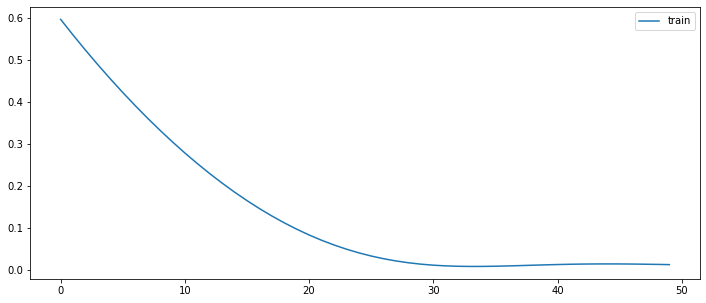

In [146]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

Puedo observar cómo disminuye el LOSS a medida que avanzan las épocas, tanto en el conjunto de train como en el conjunto de test. Esto es bueno ya que indica que el modelo está aprendiendo. 

A su vez pareciera no haber overfitting, pues las curvas de train y validate son distintas.

### Predicción

In [147]:
test_X.shape

(171, 1, 12)

In [148]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [149]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [150]:
inv_y

array([48575.   , 49060.855, 50644.715, 56011.145, 54911.57 , 53023.   ,
       53691.57 , 55578.145, 53296.145, 52524.285, 51713.715, 55606.715,
       54884.72 , 56933.14 , 55136.145, 54740.715, 53638.715, 56525.715,
       57130.57 , 57371.004, 57738.   , 57847.434, 58119.574, 54914.   ,
       52161.285, 55605.43 , 56308.   , 50852.57 , 49601.715, 52344.715,
       51030.715, 50654.43 , 51343.   , 51967.715, 49125.285, 47913.57 ,
       43558.285, 45927.715, 47256.285, 45583.285, 47613.855, 48639.57 ,
       43558.855, 48889.285, 50135.145, 46553.57 , 44153.145, 46320.   ,
       43864.855, 45705.285, 47878.145, 46874.57 , 45235.855, 47985.715,
       46165.57 , 49681.43 , 51022.285, 48891.43 , 49309.145, 47749.285,
       48177.57 , 45283.855, 48237.   , 48276.145, 53502.85 , 50571.285,
       51095.855, 52845.43 , 53976.004, 48938.715, 52378.57 , 50563.855,
       53663.434, 53894.715, 51293.285, 53138.574, 52141.57 , 52151.86 ,
       46800.285, 44241.715, 42891.715, 45111.43 , 

In [151]:
inv_yhat.shape[0]

171

In [152]:
rta = st_train.copy()
rta = rta.tail(inv_y.shape[0])
rta['Real'] = inv_y
rta['Predict'] = inv_yhat
rta['diff'] = inv_y - inv_yhat
rta

cantidad_pasos      Real   Predict     diff
fecha                                                  
2016-06-26        48575.00  48575.00  52142.68 -3567.68
2016-07-03        49060.86  49060.86  51679.14 -2618.28
2016-07-10        50644.71  50644.71  51769.34 -1124.62
2016-07-17        56011.14  56011.14  52118.16  3892.98
2016-07-24        54911.57  54911.57  52267.29  2644.28
...                    ...       ...       ...      ...
2019-09-01        39967.86  39967.86  39998.99   -31.14
2019-09-08        39467.29  39467.29  40273.71  -806.42
2019-09-15        38941.71  38941.71  40752.68 -1810.96
2019-09-22        39989.57  39989.57  41423.18 -1433.61
2019-09-29        41081.14  41081.14  41531.03  -449.88

[171 rows x 4 columns]

In [153]:
rta.reset_index(inplace=True)

### RMSE

In [154]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3516.480


### Grafico

In [155]:
# Plot 
fig_predict = go.Figure()
fig_predict.add_trace(go.Scatter(x=rta['fecha'], y=rta['Real'],
                    mode='lines+markers',
                    name='Real'))
fig_predict.add_trace(go.Scatter(x=rta['fecha'], y=rta['Predict'],
                    mode='lines+markers',
                    name='Prediccion'))

fig_predict.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_predict.update_layout(
    title="LSTM1 - AU Illia - Predicción Efectivo - Train / Test",
    width=800,
    height=500,
)
fig_predict.show()

### Conclusiones LSTM univariable

El el modelo más sencillo de red neuronal que se utiliza para este tipo de predicciones. La curva de aprendizaje fue alta, sobre todo para comprender la transformación de los datos.

Su performance no supera al XGBoost Regressor, pero capitalizo el camino recorrido hasta el momento.
Veremos qué sucede con los otros modelos.

### Predicción 2019

A partir de las últimas 12 semanas previas, predigo el último trimestre del 2019.

In [156]:
ultimasSemanas_train_st = pd.DataFrame()

ultimasSemanas_train_st = dataset_illia_ef_st_w3_mean['2019-07-14':'2019-10-06']
ultimasSemanas_train_st

cantidad_pasos
fecha                     
2019-07-14        39264.57
2019-07-21        41633.00
2019-07-28        40688.86
2019-08-04        41110.43
2019-08-11        39123.86
2019-08-18        39216.14
2019-08-25        37942.00
2019-09-01        39967.86
2019-09-08        39467.29
2019-09-15        38941.71
2019-09-22        39989.57
2019-09-29        41081.14
2019-10-06        38926.14

Y ahora seguiremos el mismo preprocesado de datos que hicimos para el entrenamiento: escalando los valores, llamando a la función series_to_supervised pero esta vez sin incluir la columna de salida “Y” pues es la que queremos hallar. Por eso, verán en el código que hacemos drop() de la última columna.

In [157]:
values = ultimasSemanas_train_st.values
values = values.astype('float32')

# normalize features
values=values.reshape(-1, 1) 
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
reframed

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  \
12        0.36        1.00        0.74       0.86       0.32       0.35   

    var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  
12       0.00       0.55       0.41       0.27       0.55       0.85

In [158]:
reframed.shape

(1, 12)

In [159]:
reframed.values

array([[0.3583231 , 1.        , 0.74420357, 0.8584204 , 0.32019997,
        0.3452034 , 0.        , 0.5488634 , 0.41324425, 0.2708521 ,
        0.5547466 , 0.85048676]], dtype=float32)

De este conjunto ultimasSemanas tomamos sólo la última fila, pues es la que correspondería a las últimas 12 semandas y la dejamos en el formato correcto para la red neuronal con reshape:

In [160]:
reframed_values = reframed.values
x_test = reframed_values[0:, :]
x_test

array([[0.3583231 , 1.        , 0.74420357, 0.8584204 , 0.32019997,
        0.3452034 , 0.        , 0.5488634 , 0.41324425, 0.2708521 ,
        0.5547466 , 0.85048676]], dtype=float32)

In [161]:
x_test.shape

(1, 12)

In [162]:
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test.shape

(1, 1, 12)

In [163]:
x_test

array([[[0.3583231 , 1.        , 0.74420357, 0.8584204 , 0.32019997,
         0.3452034 , 0.        , 0.5488634 , 0.41324425, 0.2708521 ,
         0.5547466 , 0.85048676]]], dtype=float32)

Ahora crearemos una función para ir “rellenando” el desplazamiento que hacemos por cada predicción. Esto es porque queremos predecir el último trimestre.

Entonces para la semana del  1 de octubre de 2019, ya tenemos el set con las últimas 7 semanas previas.


Y así hasta el 31 de diciembre del 2019.

In [164]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

In [165]:
results=[]
for i in range(13):
    print(i)
    parcial = model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

0
[[[0.3583231  1.         0.74420357 0.8584204  0.32019997 0.3452034
   0.         0.5488634  0.41324425 0.2708521  0.5547466  0.85048676]]]
1
[[[1.         0.74420357 0.8584204  0.32019997 0.3452034  0.
   0.5488634  0.41324425 0.2708521  0.5547466  0.85048676 0.6381178 ]]]
2
[[[0.74420357 0.8584204  0.32019997 0.3452034  0.         0.5488634
   0.41324425 0.2708521  0.5547466  0.85048676 0.6381178  0.6124782 ]]]
3
[[[0.8584204  0.32019997 0.3452034  0.         0.5488634  0.41324425
   0.2708521  0.5547466  0.85048676 0.6381178  0.6124782  0.5330664 ]]]
4
[[[0.32019997 0.3452034  0.         0.5488634  0.41324425 0.2708521
   0.5547466  0.85048676 0.6381178  0.6124782  0.5330664  0.50467676]]]
5
[[[0.3452034  0.         0.5488634  0.41324425 0.2708521  0.5547466
   0.85048676 0.6381178  0.6124782  0.5330664  0.50467676 0.49618968]]]
6
[[[0.         0.5488634  0.41324425 0.2708521  0.5547466  0.85048676
   0.6381178  0.6124782  0.5330664  0.50467676 0.49618968 0.4792001 ]]]
7
[[[0.5488

#### Re-Convertimos los resultados

Ya casi lo tenemos… Ahora las predicciones están en el dominio del -1 al 1 y nosotros lo queremos en nuestra escala “real” de pasos de vehículos. Entonces vamos a “re-transformar” los datos con el objeto “scaler” que creamos antes.

In [166]:
adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted

array([[40297.29172841],
       [40202.65598403],
       [39909.54699933],
       [39804.76086015],
       [39773.43506277],
       [39710.72648782],
       [39852.64754429],
       [40097.9721452 ],
       [40169.39715002],
       [40294.38221844],
       [40365.46996211],
       [40326.01524687],
       [40256.44198839]])

#### Visualizamos el pronóstico

In [167]:
prediccion = pd.DataFrame(inverted)
prediccion.columns = ['pronostico']
prediccion

pronostico
0     40297.29
1     40202.66
2     39909.55
3     39804.76
4     39773.44
5     39710.73
6     39852.65
7     40097.97
8     40169.40
9     40294.38
10    40365.47
11    40326.02
12    40256.44

In [168]:
df_result_2019['Pred LSTM1'] = prediccion
df_result_2019

Fecha  Pred XGB      Real  Pred LSTM1
0  2019-10-06  38975.43  38926.14    40297.29
1  2019-10-13  39160.40  37262.86    40202.66
2  2019-10-20  39058.61  38163.86    39909.55
3  2019-10-27  38504.88  37564.29    39804.76
4  2019-11-03  38504.88  39018.43    39773.44
5  2019-11-10  37998.48  38648.00    39710.73
6  2019-11-17  38504.88  40255.71    39852.65
7  2019-11-24  38504.88  37785.71    40097.97
8  2019-12-01  37998.48  38079.29    40169.40
9  2019-12-08  38654.00  40413.00    40294.38
10 2019-12-15  37998.48  38994.29    40365.47
11 2019-12-22  37998.48  41840.14    40326.02
12 2019-12-29  37998.48  32341.43    40256.44

#### RMSE

In [169]:
rmse_lstm1_2019 = np.sqrt(mean_squared_error(df_result_2019['Real'], df_result_2019['Pred LSTM1']))

print(f"LSTM1 Predicción Último Trimestre del 2019")
print("-----------------------")
print(f"RMSE-Test: %.3f" %  rmse_lstm1_2019)

LSTM1 Predicción Último Trimestre del 2019
-----------------------
RMSE-Test: 2731.594


#### Graficamos

In [170]:
# Plot 
fig_predict_2019.add_trace(go.Scatter(x=df_result_2019['Fecha'], y=df_result_2019['Pred LSTM1'],
                    mode='lines+markers',
                    name='Pred LSTM1'))
fig_predict_2019.show()
                             

### Predicción 2020
A partir de las últimas 12 semanas del 2019 predigo el 2020

In [171]:
semanal_st = dataset_illia_ef_st_w_mean.copy()

ultimasSemanas_train_st = pd.DataFrame()
ultimasSemanas_train_st = semanal_st['2019-10-07':'2020-01-05']
ultimasSemanas_train_st

cantidad_pasos
fecha                     
2019-10-13        37262.86
2019-10-20        38163.86
2019-10-27        37564.29
2019-11-03        39018.43
2019-11-10        38648.00
2019-11-17        40255.71
2019-11-24        37785.71
2019-12-01        38079.29
2019-12-08        40413.00
2019-12-15        38994.29
2019-12-22        41840.14
2019-12-29        32341.43
2020-01-05        29513.29

Y ahora seguiremos el mismo preprocesado de datos que hicimos para 2019:
- Escalando los valores
- Utilizamos la función series_to_supervised sin incluir la columna de salida “Y”.

In [172]:
values = ultimasSemanas_train_st.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
reframed

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  \
12        0.63        0.70        0.65       0.77       0.74       0.87   

    var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  
12       0.67       0.69       0.88       0.77       1.00       0.23

In [173]:
reframed.shape

(1, 12)

In [174]:
reframed.values

array([[0.62867355, 0.701766  , 0.6531267 , 0.7710922 , 0.74104166,
        0.87146544, 0.6710899 , 0.6949055 , 0.8842249 , 0.76913357,
        1.0000002 , 0.22942948]], dtype=float32)

De este conjunto “ultimasSemanas” tomamos sólo la última fila, pues es la que correspondería a las últimos 7 semandas y la dejamos en el formato correcto para la red neuronal con reshape:

In [175]:
reframed_values = reframed.values
x_test = reframed_values[0:, :]
x_test

array([[0.62867355, 0.701766  , 0.6531267 , 0.7710922 , 0.74104166,
        0.87146544, 0.6710899 , 0.6949055 , 0.8842249 , 0.76913357,
        1.0000002 , 0.22942948]], dtype=float32)

In [176]:
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test.shape

(1, 1, 12)

In [177]:
x_test

array([[[0.62867355, 0.701766  , 0.6531267 , 0.7710922 , 0.74104166,
         0.87146544, 0.6710899 , 0.6949055 , 0.8842249 , 0.76913357,
         1.0000002 , 0.22942948]]], dtype=float32)

Ahora utilizamos la función para ir “rellenando” el desplazamiento que hacemos por cada predicción. 

In [178]:
results=[]
for i in range(54):
    print(i)
    parcial = model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

0
[[[0.62867355 0.701766   0.6531267  0.7710922  0.74104166 0.87146544
   0.6710899  0.6949055  0.8842249  0.76913357 1.0000002  0.22942948]]]
1
[[[0.701766   0.6531267  0.7710922  0.74104166 0.87146544 0.6710899
   0.6949055  0.8842249  0.76913357 1.0000002  0.22942948 0.7401525 ]]]
2
[[[0.6531267  0.7710922  0.74104166 0.87146544 0.6710899  0.6949055
   0.8842249  0.76913357 1.0000002  0.22942948 0.7401525  0.80410933]]]
3
[[[0.7710922  0.74104166 0.87146544 0.6710899  0.6949055  0.8842249
   0.76913357 1.0000002  0.22942948 0.7401525  0.80410933 0.7615251 ]]]
4
[[[0.74104166 0.87146544 0.6710899  0.6949055  0.8842249  0.76913357
   1.0000002  0.22942948 0.7401525  0.80410933 0.7615251  0.81879187]]]
5
[[[0.87146544 0.6710899  0.6949055  0.8842249  0.76913357 1.0000002
   0.22942948 0.7401525  0.80410933 0.7615251  0.81879187 0.7919369 ]]]
6
[[[0.6710899  0.6949055  0.8842249  0.76913357 1.0000002  0.22942948
   0.7401525  0.80410933 0.7615251  0.81879187 0.7919369  0.8154444 ]]]
7
[

#### Re-Convertimos los resultados

Ya casi lo tenemos… Ahora las predicciones están en el dominio del -1 al 1 y nosotros lo queremos en nuestra escala “real” de unidades vendidas. Entonces vamos a “re-transformar” los datos con el objeto “scaler” que creamos antes.

In [179]:
adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
#inverted

In [180]:
prediccion = pd.DataFrame(inverted)
prediccion.columns = ['pronostico']

In [181]:
df_result_2020['Pred LSTM1'] = prediccion
df_result_2020

Fecha  Pred XGB      Real  Pred LSTM1
0  2020-01-05  38611.94  29513.29    38637.04
1  2020-01-12  39565.01  34765.57    39425.43
2  2020-01-19  37998.48  35259.71    38900.50
3  2020-01-26  37998.48  34456.00    39606.42
4  2020-02-02  38504.88  36190.71    39275.38
5  2020-02-09  37998.48  35306.43    39565.15
6  2020-02-16  38504.88  37351.14    39874.59
7  2020-02-23  36318.31  36728.00    39309.86
8  2020-03-01  38654.00  33641.00    39394.87
9  2020-03-08  38504.88  36415.71    39355.70
10 2020-03-15  37998.48  31827.57    39283.24
11 2020-03-22  37998.48  26196.71    39507.11
12 2020-03-29  37998.48  25174.00    39986.33
13 2020-04-05  37998.48  25174.00    40116.06
14 2020-04-12  37998.48  25174.00    40234.01
15 2020-04-19  37998.48  25174.00    40306.78
16 2020-04-26  37998.48  11616.00    40348.65
17 2020-05-03  37998.48  11616.00    40405.92
18 2020-05-10  37998.48  11616.00    40416.06
19 2020-05-17  37998.48  11616.00    40454.43
20 2020-05-24  37998.48  10211.14    40566.80
21 2020-05-31  37998.48  10655.86    40687.28
22 2020-06-07  37998.48  10408.71    40827.20
23 2020-06-14  37998.48  11421.14    40968.46
24 2020-06-21  37998.48  11883.29    41081.83
25 2020-06-28  37998.48  12070.00    41170.39
26 2020-07-05  37998.48  12964.71    41246.44
27 2020-07-12  37998.48  13868.43    41316.29
28 2020-07-19  37998.48  11667.14    41390.55
29 2020-07-26  37998.48  12521.29    41471.10
30 2020-08-02  37998.48  13750.29    41560.93
31 2020-08-09  37998.48  13879.00    41661.85
32 2020-08-16  37998.48  14010.29    41766.65
33 2020-08-23  37998.48  12162.43    41868.77
34 2020-08-30  37998.48  12143.14    41965.66
35 2020-09-06  37998.48  11446.86    42055.55
36 2020-09-13  37998.48  11162.43    42139.93
37 2020-09-20  37998.48  10248.86    42221.81
38 2020-09-27  37998.48  10283.14    42303.81
39 2020-10-04  37998.48   9149.71    42387.96
40 2020-10-11  37998.48   6709.00    42474.76
41 2020-10-18  37998.48   6766.43    42563.47
42 2020-10-25  37998.48   6875.86    42652.91
43 2020-11-01  37998.48   6509.86    42741.49
44 2020-11-08  37998.48   6977.14    42827.94
45 2020-11-15  37998.48   7577.14    42911.94
46 2020-11-22  37998.48   8740.14    42993.82
47 2020-11-29  37998.48   8290.00    43074.34
48 2020-12-06  37998.48   9797.14    43154.30
49 2020-12-13  37998.48   9347.86    43234.26
50 2020-12-20  37998.48  10511.14    43314.41
51 2020-12-27  37998.48   9633.43    43394.56

#### RMSE

In [182]:
rmse_lstm1_2020 = np.sqrt(mean_squared_error(df_result_2020['Real'], df_result_2020['Pred LSTM1']))

print(f"LSTM1 Predicción 2020")
print("-----------------------")
print(f"RMSE-Test: %.3f" %  rmse_lstm1_2020)

LSTM1 Predicción 2020
-----------------------
RMSE-Test: 26657.932


#### Graficamos

In [183]:
# Plot 
fig_predict_2020.add_trace(go.Scatter(x=df_result_2020['Fecha'], y=df_result_2020['Pred LSTM1'],
                    mode='lines+markers',
                    name='Pred LSTM1'))
fig_predict_2020.show()

Como se puede apreciar, será necesario continuar indagando y trabajando con redes neuronales. 
Si bien fue una primera aproximación, el resultado lejos estuvo del esperado.

Al momento, el mejor modelo obtenido fué el **XGB con optimización de parámetros**.

## LSTMV

Para continuar con la exploración de modelos de redes neuronales, generaremos un LSMT Multivariable. Este tipo de modelos acepta series de tiempo con, como su nombre lo indica, más de una variable.

Para poder probar el modelo, tendremos que incorporar otros datos a nuestra serie de tiempo actual.

### Con variables internas

Existen muchas formas de trabajar las series de tiempo y sus datos. Dado que estamos realizando una comparación de efectividad entre diversos modelos, vamos a respetar el hecho de que en todos los casos se utiliza un resampleo de los datos semanal para que la comparación sea más justa.

Con esta premisa, la forma de incorporar los datos de sentido y tipo de vehículo, se realizará obteniendo los promedios y realizando las transformaciones pertinentes.

In [184]:
dataset_illia_ef

estacion    sentido   tipo_vehiculo forma_pago  cantidad_pasos  \
11         Illia  Provincia         Liviano   EFECTIVO            8.00   
13         Illia  Provincia         Liviano   EFECTIVO          385.00   
17         Illia  Provincia          Pesado   EFECTIVO            4.00   
19         Illia  Provincia          Pesado   EFECTIVO            1.00   
20         Illia  Provincia         Liviano   EFECTIVO           66.00   
...          ...        ...             ...        ...             ...   
7473403    Illia     Centro  Pesados 2 Ejes   EFECTIVO            2.00   
7473503    Illia     Centro            Moto   EFECTIVO            5.00   
7473504    Illia  Provincia            Moto   EFECTIVO            1.00   
7473578    Illia     Centro            Auto   EFECTIVO          103.00   
7473579    Illia  Provincia            Auto   EFECTIVO          106.00   

                      fecha  
11      2016-01-01 00:00:00  
13      2016-01-01 00:00:00  
17      2016-01-01 00:00:00  
19      2016-01-01 00:00:00  
20      2016-01-01 00:00:00  
...                     ...  
7473403 2020-12-31 20:00:00  
7473503 2020-12-31 21:00:00  
7473504 2020-12-31 21:00:00  
7473578 2020-12-31 21:00:00  
7473579 2020-12-31 21:00:00  

[398940 rows x 6 columns]

Crearemos una función para que aplique todas las transformaciones de la serie por cada columna para poder extraer los datos, e ir incluyéndolos como variables en nuestro dataset original. 

In [185]:
def mean_st_transform(df):
    df_st = df.resample('D', on = 'fecha').sum()

    # Genero filtro de atípicos y le asigno NaN
    df_st[
      (df_st.cantidad_pasos == 0) | (df_st.cantidad_pasos <= 1000)
    ] = np.NaN

    # Cantidad de dias totales
    print(df_st.shape)

    # Cantidad de dias con NaN
    print(df_st.isna().sum())

    # Aplico Método Nearest
    df_st = df_st.interpolate(method='nearest', k=3)
    print(df_st.isna().sum())

    df_st = df_st.resample("w").mean()
    df_st = df_st['2016-01-03':'2019-09-29']
    return df_st

In [186]:
#Nos quedamos solamente con sentido provincia
df = pd.DataFrame()
df = dataset_illia_ef[
    (dataset_illia_ef.sentido == 'Provincia') 
]
df

estacion    sentido   tipo_vehiculo forma_pago  cantidad_pasos  \
11         Illia  Provincia         Liviano   EFECTIVO            8.00   
13         Illia  Provincia         Liviano   EFECTIVO          385.00   
17         Illia  Provincia          Pesado   EFECTIVO            4.00   
19         Illia  Provincia          Pesado   EFECTIVO            1.00   
20         Illia  Provincia         Liviano   EFECTIVO           66.00   
...          ...        ...             ...        ...             ...   
7473053    Illia  Provincia  Pesados 2 Ejes   EFECTIVO            2.00   
7473175    Illia  Provincia            Auto   EFECTIVO          222.00   
7473197    Illia  Provincia            Moto   EFECTIVO           12.00   
7473504    Illia  Provincia            Moto   EFECTIVO            1.00   
7473579    Illia  Provincia            Auto   EFECTIVO          106.00   

                      fecha  
11      2016-01-01 00:00:00  
13      2016-01-01 00:00:00  
17      2016-01-01 00:00:00  
19      2016-01-01 00:00:00  
20      2016-01-01 00:00:00  
...                     ...  
7473053 2020-12-31 19:00:00  
7473175 2020-12-31 20:00:00  
7473197 2020-12-31 20:00:00  
7473504 2020-12-31 21:00:00  
7473579 2020-12-31 21:00:00  

[182554 rows x 6 columns]

In [187]:
df_st_provincia = mean_st_transform(df)
df_st_provincia

(1827, 1)
cantidad_pasos    66
dtype: int64
cantidad_pasos    0
dtype: int64


cantidad_pasos
fecha                     
2016-01-03        15395.67
2016-01-10        22371.14
2016-01-17        23727.29
2016-01-24        22643.57
2016-01-31        22916.86
...                    ...
2019-09-01        19291.71
2019-09-08        18912.71
2019-09-15        18466.57
2019-09-22        18759.71
2019-09-29        19500.43

[196 rows x 1 columns]

In [188]:
#Nos quedamos solamente con sentido provincia
df = pd.DataFrame()
df = dataset_illia_ef[
    (dataset_illia_ef.sentido == 'Centro') 
]
df

estacion sentido     tipo_vehiculo forma_pago  cantidad_pasos  \
70         Illia  Centro            Pesado   EFECTIVO            2.00   
98         Illia  Centro            Pesado   EFECTIVO           11.00   
101        Illia  Centro            Pesado   EFECTIVO            3.00   
106        Illia  Centro           Liviano   EFECTIVO          649.00   
108        Illia  Centro           Liviano   EFECTIVO           14.00   
...          ...     ...               ...        ...             ...   
7473211    Illia  Centro  Auto con trailer   EFECTIVO            1.00   
7473213    Illia  Centro              Moto   EFECTIVO           17.00   
7473403    Illia  Centro    Pesados 2 Ejes   EFECTIVO            2.00   
7473503    Illia  Centro              Moto   EFECTIVO            5.00   
7473578    Illia  Centro              Auto   EFECTIVO          103.00   

                      fecha  
70      2016-01-01 00:00:00  
98      2016-01-01 00:00:00  
101     2016-01-01 00:00:00  
106     2016-01-01 00:00:00  
108     2016-01-01 00:00:00  
...                     ...  
7473211 2020-12-31 20:00:00  
7473213 2020-12-31 20:00:00  
7473403 2020-12-31 20:00:00  
7473503 2020-12-31 21:00:00  
7473578 2020-12-31 21:00:00  

[216386 rows x 6 columns]

In [189]:
df_st_centro = mean_st_transform(df)
df_st_centro

(1827, 1)
cantidad_pasos    66
dtype: int64
cantidad_pasos    0
dtype: int64


cantidad_pasos
fecha                     
2016-01-03        17592.00
2016-01-10        26514.71
2016-01-17        27651.14
2016-01-24        26816.00
2016-01-31        26829.00
...                    ...
2019-09-01        20676.14
2019-09-08        20554.57
2019-09-15        20475.14
2019-09-22        21229.86
2019-09-29        21580.71

[196 rows x 1 columns]

In [190]:
#Nos quedamos solamente con sentido provincia
df = pd.DataFrame()
df = dataset_illia_ef[
    (dataset_illia_ef.tipo_vehiculo == 'Liviano') 
]
df

estacion    sentido tipo_vehiculo forma_pago  cantidad_pasos  \
11         Illia  Provincia       Liviano   EFECTIVO            8.00   
13         Illia  Provincia       Liviano   EFECTIVO          385.00   
20         Illia  Provincia       Liviano   EFECTIVO           66.00   
106        Illia     Centro       Liviano   EFECTIVO          649.00   
108        Illia     Centro       Liviano   EFECTIVO           14.00   
...          ...        ...           ...        ...             ...   
4939964    Illia  Provincia       Liviano   EFECTIVO          905.00   
4940076    Illia  Provincia       Liviano   EFECTIVO          556.00   
4940077    Illia     Centro       Liviano   EFECTIVO          580.00   
4940104    Illia     Centro       Liviano   EFECTIVO          214.00   
4940146    Illia  Provincia       Liviano   EFECTIVO          190.00   

                      fecha  
11      2016-01-01 00:00:00  
13      2016-01-01 00:00:00  
20      2016-01-01 00:00:00  
106     2016-01-01 00:00:00  
108     2016-01-01 00:00:00  
...                     ...  
4939964 2019-12-31 21:00:00  
4940076 2019-12-31 22:00:00  
4940077 2019-12-31 22:00:00  
4940104 2019-12-31 23:00:00  
4940146 2019-12-31 23:00:00  

[122725 rows x 6 columns]

In [191]:
df_st_liviano = mean_st_transform(df)
df_st_liviano

(1461, 1)
cantidad_pasos    6
dtype: int64
cantidad_pasos    0
dtype: int64


cantidad_pasos
fecha                     
2016-01-03        32108.33
2016-01-10        46633.00
2016-01-17        48989.43
2016-01-24        47163.14
2016-01-31        47457.71
...                    ...
2019-09-01        39122.00
2019-09-08        38618.14
2019-09-15        38239.00
2019-09-22        39203.43
2019-09-29        40288.71

[196 rows x 1 columns]

In [192]:
#Nos quedamos solamente con sentido provincia
df = pd.DataFrame()
df = dataset_illia_ef[
    (dataset_illia_ef.tipo_vehiculo != 'Liviano') 
]
df

estacion    sentido   tipo_vehiculo forma_pago  cantidad_pasos  \
17         Illia  Provincia          Pesado   EFECTIVO            4.00   
19         Illia  Provincia          Pesado   EFECTIVO            1.00   
70         Illia     Centro          Pesado   EFECTIVO            2.00   
98         Illia     Centro          Pesado   EFECTIVO           11.00   
101        Illia     Centro          Pesado   EFECTIVO            3.00   
...          ...        ...             ...        ...             ...   
7473403    Illia     Centro  Pesados 2 Ejes   EFECTIVO            2.00   
7473503    Illia     Centro            Moto   EFECTIVO            5.00   
7473504    Illia  Provincia            Moto   EFECTIVO            1.00   
7473578    Illia     Centro            Auto   EFECTIVO          103.00   
7473579    Illia  Provincia            Auto   EFECTIVO          106.00   

                      fecha  
17      2016-01-01 00:00:00  
19      2016-01-01 00:00:00  
70      2016-01-01 00:00:00  
98      2016-01-01 00:00:00  
101     2016-01-01 00:00:00  
...                     ...  
7473403 2020-12-31 20:00:00  
7473503 2020-12-31 21:00:00  
7473504 2020-12-31 21:00:00  
7473578 2020-12-31 21:00:00  
7473579 2020-12-31 21:00:00  

[276215 rows x 6 columns]

In [193]:
df_st_no_liviano = mean_st_transform(df)
df_st_no_liviano

(1827, 1)
cantidad_pasos    435
dtype: int64
cantidad_pasos    1
dtype: int64


cantidad_pasos
fecha                     
2016-01-03         1100.50
2016-01-10         2252.86
2016-01-17         2389.00
2016-01-24         2373.14
2016-01-31         2288.14
...                    ...
2019-09-01         1265.00
2019-09-08         1398.14
2019-09-15         1260.71
2019-09-22         1023.00
2019-09-29         1187.00

[196 rows x 1 columns]

In [194]:

semanal_st = st_train.copy()

# Renombramos nuestra variable principal
semanal_st.rename(columns = {'cantidad_pasos': 'total'}, inplace = True) 

# Le incorporamos el mes como dato
semanal_st['month'] = semanal_st.index.month_name()

# Agregamos el sentido provincia
semanal_st['provincia'] = df_st_provincia

# Agregamos el sentido centro
semanal_st['centro'] = df_st_centro

# Agregamos el tipo de vehículo liviano
semanal_st['liviano'] = df_st_liviano

# Agregamos el tipo de vehículo pesado
semanal_st['pesado'] = df_st_no_liviano

semanal_st.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 196 entries, 2016-01-03 to 2019-09-29
Freq: W-SUN
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   total      196 non-null    float64
 1   month      196 non-null    object 
 2   provincia  196 non-null    float64
 3   centro     196 non-null    float64
 4   liviano    196 non-null    float64
 5   pesado     196 non-null    float64
dtypes: float64(5), object(1)
memory usage: 10.7+ KB


Ahora si, logramos obtener **5 variables** más de las que teníamos en el modelo anterior:

In [195]:
semanal_st

total      month  provincia    centro   liviano   pesado
fecha                                                                  
2016-01-03  32987.67    January   15395.67  17592.00  32108.33  1100.50
2016-01-10  48885.86    January   22371.14  26514.71  46633.00  2252.86
2016-01-17  51378.43    January   23727.29  27651.14  48989.43  2389.00
2016-01-24  49459.57    January   22643.57  26816.00  47163.14  2373.14
2016-01-31  49745.86    January   22916.86  26829.00  47457.71  2288.14
...              ...        ...        ...       ...       ...      ...
2019-09-01  39967.86  September   19291.71  20676.14  39122.00  1265.00
2019-09-08  39467.29  September   18912.71  20554.57  38618.14  1398.14
2019-09-15  38941.71  September   18466.57  20475.14  38239.00  1260.71
2019-09-22  39989.57  September   18759.71  21229.86  39203.43  1023.00
2019-09-29  41081.14  September   19500.43  21580.71  40288.71  1187.00

[196 rows x 6 columns]

#### Preprocesado de los datos 

Como paso adicional, utilizaremos el método LabelEncoder para que el modelo interprete la variable categórica `month`.

In [196]:
PASOS = 12

# load dataset
values = semanal_st.values

# integer encode 
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed

var1(t-12)  var2(t-12)  var3(t-12)  var4(t-12)  var5(t-12)  var6(t-12)  \
12         0.02        0.36        0.00        0.08        0.01        0.04   
13         0.64        0.36        0.61        0.68        0.63        0.68   
14         0.74        0.36        0.73        0.75        0.73        0.75   
15         0.66        0.36        0.63        0.70        0.65        0.75   
16         0.67        0.36        0.66        0.70        0.67        0.70   
..          ...         ...         ...         ...         ...         ...   
191        0.32        0.55        0.37        0.31        0.34        0.10   
192        0.19        0.55        0.22        0.20        0.20        0.01   
193        0.00        0.55        0.04        0.02        0.00        0.00   
194        0.25        0.55        0.28        0.26        0.27        0.01   
195        0.30        0.45        0.38        0.26        0.31        0.12   

     var1(t-11)  var2(t-11)  var3(t-11)  var4(t-11)  ...  var3(t-1)  \
12         0.64        0.36        0.61        0.68  ...       0.79   
13         0.74        0.36        0.73        0.75  ...       0.39   
14         0.66        0.36        0.63        0.70  ...       0.73   
15         0.67        0.36        0.66        0.70  ...       0.70   
16         0.76        0.27        0.73        0.79  ...       0.66   
..          ...         ...         ...         ...  ...        ...   
191        0.19        0.55        0.22        0.20  ...       0.20   
192        0.00        0.55        0.04        0.02  ...       0.34   
193        0.25        0.55        0.28        0.26  ...       0.31   
194        0.30        0.45        0.38        0.26  ...       0.27   
195        0.27        0.45        0.32        0.26  ...       0.29   

     var4(t-1)  var5(t-1)  var6(t-1)  var1(t)  var2(t)  var3(t)  var4(t)  \
12        0.85       0.81       0.91     0.49     0.64     0.39     0.58   
13        0.58       0.47       0.55     0.77     0.00     0.73     0.81   
14        0.81       0.76       0.89     0.75     0.00     0.70     0.79   
15        0.79       0.73       0.87     0.66     0.00     0.66     0.68   
16        0.68       0.65       0.79     0.75     0.00     0.70     0.79   
..         ...        ...        ...      ...      ...      ...      ...   
191       0.26       0.23       0.14     0.29     1.00     0.34     0.29   
192       0.29       0.31       0.14     0.27     1.00     0.31     0.28   
193       0.28       0.29       0.21     0.25     1.00     0.27     0.27   
194       0.27       0.27       0.13     0.29     1.00     0.29     0.32   
195       0.32       0.32       0.00     0.34     1.00     0.36     0.35   

     var5(t)  var6(t)  
12      0.47     0.55  
13      0.76     0.89  
14      0.73     0.87  
15      0.65     0.79  
16      0.74     0.83  
..       ...      ...  
191     0.31     0.14  
192     0.29     0.21  
193     0.27     0.13  
194     0.32     0.00  
195     0.36     0.09  

[184 rows x 78 columns]

In [197]:
# drop columns we don't want to predict
reframed.drop(['var6(t)','var5(t)','var4(t)','var3(t)','var2(t)'],axis=1, inplace=True)
reframed

var1(t-12)  var2(t-12)  var3(t-12)  var4(t-12)  var5(t-12)  var6(t-12)  \
12         0.02        0.36        0.00        0.08        0.01        0.04   
13         0.64        0.36        0.61        0.68        0.63        0.68   
14         0.74        0.36        0.73        0.75        0.73        0.75   
15         0.66        0.36        0.63        0.70        0.65        0.75   
16         0.67        0.36        0.66        0.70        0.67        0.70   
..          ...         ...         ...         ...         ...         ...   
191        0.32        0.55        0.37        0.31        0.34        0.10   
192        0.19        0.55        0.22        0.20        0.20        0.01   
193        0.00        0.55        0.04        0.02        0.00        0.00   
194        0.25        0.55        0.28        0.26        0.27        0.01   
195        0.30        0.45        0.38        0.26        0.31        0.12   

     var1(t-11)  var2(t-11)  var3(t-11)  var4(t-11)  ...  var4(t-2)  \
12         0.64        0.36        0.61        0.68  ...       0.81   
13         0.74        0.36        0.73        0.75  ...       0.85   
14         0.66        0.36        0.63        0.70  ...       0.58   
15         0.67        0.36        0.66        0.70  ...       0.81   
16         0.76        0.27        0.73        0.79  ...       0.79   
..          ...         ...         ...         ...  ...        ...   
191        0.19        0.55        0.22        0.20  ...       0.26   
192        0.00        0.55        0.04        0.02  ...       0.26   
193        0.25        0.55        0.28        0.26  ...       0.29   
194        0.30        0.45        0.38        0.26  ...       0.28   
195        0.27        0.45        0.32        0.26  ...       0.27   

     var5(t-2)  var6(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  \
12        0.77       0.87       0.82       0.64       0.79       0.85   
13        0.81       0.91       0.49       0.64       0.39       0.58   
14        0.47       0.55       0.77       0.00       0.73       0.81   
15        0.76       0.89       0.75       0.00       0.70       0.79   
16        0.73       0.87       0.66       0.00       0.66       0.68   
..         ...        ...        ...        ...        ...        ...   
191       0.29       0.23       0.21       0.09       0.20       0.26   
192       0.23       0.14       0.29       1.00       0.34       0.29   
193       0.31       0.14       0.27       1.00       0.31       0.28   
194       0.29       0.21       0.25       1.00       0.27       0.27   
195       0.27       0.13       0.29       1.00       0.29       0.32   

     var5(t-1)  var6(t-1)  var1(t)  
12        0.81       0.91     0.49  
13        0.47       0.55     0.77  
14        0.76       0.89     0.75  
15        0.73       0.87     0.66  
16        0.65       0.79     0.75  
..         ...        ...      ...  
191       0.23       0.14     0.29  
192       0.31       0.14     0.27  
193       0.29       0.21     0.25  
194       0.27       0.13     0.29  
195       0.32       0.00     0.34  

[184 rows x 73 columns]

#### Train / Test Split

In [198]:
# split into train and test sets
values = reframed.values
n_train_weeks = st_test_obj1.shape[0]

# Tomo la serie del 2016-01-03 al 2019-10-01 y le saco las semanas del test
train = values[:n_train_weeks, :]

# Tomo la serie del 2016-01-03 al 2019-10-01 y me quedo sólo con las últimas 13 semanas 
test = values[n_train_weeks:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13, 1, 72) (13,) (171, 1, 72) (171,)


#### Creamos el Modelo

Utilizaremos una Red Feedforward. Como entradas tenemos 12 pasos por cantidad de variables variables.

In [199]:
# design network
model = Sequential()
model.add(LSTM(100, activation="tanh", input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

#### Entrenamos

In [200]:
EPOCHS = 50

# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=EPOCHS, 
    batch_size=72, 
    validation_data=(test_X, test_y), 
    verbose=2, 
    shuffle=False
)


Epoch 1/50
1/1 - 2s - loss: 0.5156 - val_loss: 0.1850
Epoch 2/50
1/1 - 0s - loss: 0.2894 - val_loss: 0.0859
Epoch 3/50
1/1 - 0s - loss: 0.1323 - val_loss: 0.0309
Epoch 4/50
1/1 - 0s - loss: 0.0406 - val_loss: 0.0154
Epoch 5/50
1/1 - 0s - loss: 0.0075 - val_loss: 0.0295
Epoch 6/50
1/1 - 0s - loss: 0.0192 - val_loss: 0.0572
Epoch 7/50
1/1 - 0s - loss: 0.0529 - val_loss: 0.0813
Epoch 8/50
1/1 - 0s - loss: 0.0839 - val_loss: 0.0924
Epoch 9/50
1/1 - 0s - loss: 0.0981 - val_loss: 0.0897
Epoch 10/50
1/1 - 0s - loss: 0.0942 - val_loss: 0.0774
Epoch 11/50
1/1 - 0s - loss: 0.0778 - val_loss: 0.0607
Epoch 12/50
1/1 - 0s - loss: 0.0561 - val_loss: 0.0441
Epoch 13/50
1/1 - 0s - loss: 0.0352 - val_loss: 0.0306
Epoch 14/50
1/1 - 0s - loss: 0.0191 - val_loss: 0.0215
Epoch 15/50
1/1 - 0s - loss: 0.0096 - val_loss: 0.0171
Epoch 16/50
1/1 - 0s - loss: 0.0066 - val_loss: 0.0163
Epoch 17/50
1/1 - 0s - loss: 0.0086 - val_loss: 0.0181
Epoch 18/50
1/1 - 0s - loss: 0.0136 - val_loss: 0.0208
Epoch 19/50
1/1 - 0

 #### Loss

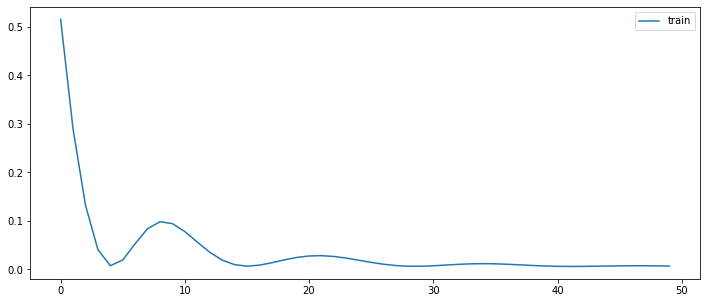

In [201]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

#### Predicción

In [202]:
test_X.shape

(171, 1, 72)

In [203]:
test_X.shape[2]

72

In [204]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [205]:
extra_features = semanal_st.shape[1] - 1

In [206]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -extra_features:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [207]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -extra_features:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [208]:
inv_y

array([48575.   , 49060.855, 50644.715, 56011.145, 54911.57 , 53023.   ,
       53691.57 , 55578.145, 53296.145, 52524.285, 51713.715, 55606.715,
       54884.72 , 56933.14 , 55136.145, 54740.715, 53638.715, 56525.715,
       57130.57 , 57371.004, 57738.   , 57847.434, 58119.574, 54914.   ,
       52161.285, 55605.43 , 56308.   , 50852.57 , 49601.715, 52344.715,
       51030.715, 50654.43 , 51343.   , 51967.715, 49125.285, 47913.57 ,
       43558.285, 45927.715, 47256.285, 45583.285, 47613.855, 48639.57 ,
       43558.855, 48889.285, 50135.145, 46553.57 , 44153.145, 46320.   ,
       43864.855, 45705.285, 47878.145, 46874.57 , 45235.855, 47985.715,
       46165.57 , 49681.43 , 51022.285, 48891.43 , 49309.145, 47749.285,
       48177.57 , 45283.855, 48237.   , 48276.145, 53502.85 , 50571.285,
       51095.855, 52845.43 , 53976.004, 48938.715, 52378.57 , 50563.855,
       53663.434, 53894.715, 51293.285, 53138.574, 52141.57 , 52151.86 ,
       46800.285, 44241.715, 42891.715, 45111.43 , 

In [209]:
inv_yhat

array([50169.48 , 50531.23 , 50166.88 , 49996.61 , 50509.87 , 50783.965,
       50699.945, 50408.086, 50302.246, 51049.445, 51227.816, 51119.316,
       51109.785, 50792.062, 50702.81 , 51024.242, 51493.113, 52048.996,
       52279.523, 52743.785, 52477.7  , 52574.734, 52945.977, 53424.234,
       53174.97 , 53048.15 , 53283.312, 53394.715, 53300.223, 52868.836,
       52233.453, 52091.76 , 51704.957, 51596.664, 51262.996, 50996.69 ,
       51154.996, 50574.38 , 49746.867, 48824.85 , 48451.89 , 48353.33 ,
       48426.996, 48944.68 , 49309.707, 49111.89 , 48262.48 , 47122.582,
       45975.105, 45456.918, 45930.617, 46578.477, 47310.656, 47228.04 ,
       47791.2  , 47932.54 , 47767.35 , 47574.43 , 47492.465, 47774.42 ,
       47599.285, 48112.88 , 48454.17 , 48287.258, 48336.473, 47763.61 ,
       47450.367, 47962.754, 48795.293, 49371.8  , 49226.617, 49736.312,
       49436.8  , 49721.734, 50575.59 , 50667.418, 50856.516, 50879.53 ,
       51291.375, 51475.363, 50377.074, 49312.258, 

In [210]:
rta = st_train.copy()
rta = rta.tail(inv_y.shape[0])
rta['Real'] = inv_y
rta['Predict'] = inv_yhat
rta['diff'] = inv_y - inv_yhat
rta

cantidad_pasos      Real   Predict     diff
fecha                                                  
2016-06-26        48575.00  48575.00  50169.48 -1594.48
2016-07-03        49060.86  49060.86  50531.23 -1470.38
2016-07-10        50644.71  50644.71  50166.88   477.84
2016-07-17        56011.14  56011.14  49996.61  6014.54
2016-07-24        54911.57  54911.57  50509.87  4401.70
...                    ...       ...       ...      ...
2019-09-01        39967.86  39967.86  41011.75 -1043.89
2019-09-08        39467.29  39467.29  40471.42 -1004.14
2019-09-15        38941.71  38941.71  40467.53 -1525.82
2019-09-22        39989.57  39989.57  40247.09  -257.52
2019-09-29        41081.14  41081.14  39876.08  1205.06

[171 rows x 4 columns]

In [211]:
rta.reset_index(inplace=True)

#### RMSE

In [212]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3379.412


#### Graficamos

In [213]:
# Plot 
fig_predict = go.Figure()
fig_predict.add_trace(go.Scatter(x=rta['fecha'], y=rta['Real'],
                    mode='lines+markers',
                    name='Real'))
fig_predict.add_trace(go.Scatter(x=rta['fecha'], y=rta['Predict'],
                    mode='lines+markers',
                    name='Predicción'))

fig_predict.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_predict.update_layout(
    title="LSTMV - AU Illia - Predicción Efectivo - Train / Test",
    width=800,
    height=500,
)
fig_predict.show()

### Incluyendo el precio de la Nafta

Uno de los **desafíos** para este proyecto es **incorporar otros datos** agenos al dataset original para evaluar si mejora la performance del modelo.

En el notebook `precios-surtidor.ipynb` disponible en el repositorio git, pueden observar en detalle el proceso de transformación de datos que se hizo para obtener este dataset.

**¿Qué información contiene?** El precio promedio del litro de nafta en Argentina. 

**¿Por qué elegí incorporar esta información?** En la investigación realizada en el proyecto anterior, las fuentes periodísticas denotaban una relación entre la disminución del tránsito vehicular respecto a el ascenso del valor de la nafta.



In [214]:
# Realizamos la lectura del dataset trabajado en el otro notebook
df_precio_nafta = pd.read_csv('./datasets/nafta_st_w.csv')
df_precio_nafta

#Pasamos la columna fecha a formato datetime
df_precio_nafta['fecha'] = pd.to_datetime(df_precio_nafta.fecha)

# Convertimos en dataframe en serie de tiempo
st_precio_nafta = df_precio_nafta.resample('W', on = 'fecha').mean()
st_precio_nafta

precio
fecha             
2017-02-05   21.95
2017-02-12   21.95
2017-02-19   21.95
2017-02-26   21.27
2017-03-05   21.27
...            ...
2021-03-07   85.08
2021-03-14   85.08
2021-03-21   91.91
2021-03-28   91.91
2021-04-04   91.91

[218 rows x 1 columns]

Como se puede observar, los datos oficiales me permitieron generar un dataset desde el 5 de febrero del 2017. Para poder utilizar estos datos como variable, vamos a equiparar el lapso temporal de todas las series de tiempo.

Pero para experimentar con el modelo, vamos a generar dos datasets. Uno, con el precio de la nafta al que se le quitará los datos de 2016 y otro, donde no incluiremos el precio de la nafta.

In [215]:
semanal_st2 = semanal_st.copy()
semanal_st2 = semanal_st2['2017-02-05':'2019-09-29']
semanal_st2

total      month  provincia    centro   liviano   pesado
fecha                                                                  
2017-02-05  51343.00   February   23956.00  27387.00  48909.00  2434.00
2017-02-12  51967.71   February   24360.00  27607.71  49593.57  2374.14
2017-02-19  49125.29   February   22908.43  26216.86  46921.43  2203.86
2017-02-26  47913.57   February   22246.57  25667.00  45814.71  2098.86
2017-03-05  43558.29      March   20332.86  23225.43  41819.86  1738.43
...              ...        ...        ...       ...       ...      ...
2019-09-01  39967.86  September   19291.71  20676.14  39122.00  1265.00
2019-09-08  39467.29  September   18912.71  20554.57  38618.14  1398.14
2019-09-15  38941.71  September   18466.57  20475.14  38239.00  1260.71
2019-09-22  39989.57  September   18759.71  21229.86  39203.43  1023.00
2019-09-29  41081.14  September   19500.43  21580.71  40288.71  1187.00

[139 rows x 6 columns]

In [216]:
semanal_st2['precio_nafta'] = st_precio_nafta
semanal_st2

total      month  provincia    centro   liviano   pesado  \
fecha                                                                     
2017-02-05  51343.00   February   23956.00  27387.00  48909.00  2434.00   
2017-02-12  51967.71   February   24360.00  27607.71  49593.57  2374.14   
2017-02-19  49125.29   February   22908.43  26216.86  46921.43  2203.86   
2017-02-26  47913.57   February   22246.57  25667.00  45814.71  2098.86   
2017-03-05  43558.29      March   20332.86  23225.43  41819.86  1738.43   
...              ...        ...        ...       ...       ...      ...   
2019-09-01  39967.86  September   19291.71  20676.14  39122.00  1265.00   
2019-09-08  39467.29  September   18912.71  20554.57  38618.14  1398.14   
2019-09-15  38941.71  September   18466.57  20475.14  38239.00  1260.71   
2019-09-22  39989.57  September   18759.71  21229.86  39203.43  1023.00   
2019-09-29  41081.14  September   19500.43  21580.71  40288.71  1187.00   

            precio_nafta  
fecha                     
2017-02-05         21.95  
2017-02-12         21.95  
2017-02-19         21.95  
2017-02-26         21.27  
2017-03-05         21.27  
...                  ...  
2019-09-01         50.82  
2019-09-08         50.82  
2019-09-15         50.82  
2019-09-22         53.15  
2019-09-29         53.15  

[139 rows x 7 columns]

Observemos como se comporta el precio de la nafta a lo largo de los años

In [217]:
semanal_df2 = semanal_st2.reset_index()

In [218]:
# Plot 
fig_nafta = go.Figure()
fig_nafta.add_trace(go.Scatter(x=semanal_df2['fecha'], y=semanal_df2['precio_nafta'],
                    mode='lines+markers',
                    name='Precio litro de Nafta'))

fig_nafta.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_nafta.update_layout(
    title="Precio de Nafta en Argentina",
    width=800,
    height=500,
)
fig_nafta.show()

Si agregamos al gráfico el promedio semanal de pasos de vehículos, obtenemos esto:

In [219]:
fig_nafta.add_trace(go.Scatter(x=semanal_df2['fecha'], y=semanal_df2['total'],
                    mode='lines+markers',
                    name='Cantidad de pasos de vehículos'))
fig_nafta.show()

Nos encontramos con que al ser muy pequeno el valor del precio, respecto a la cantidad de vehículos, la línea que representa al valor de la nafta se aplana.

Sólo a fines de poder ilustrar el cambio del valor del precio de la nafta vs el paso de vehículos, vamos a dividir uniformemente x 1000 los pasos de vehículos. Así logramos que el eje y, esté acotado a un desplazamiento más uniforme, sin perder dato.

In [220]:
semanal_df2['total_k'] = semanal_df2['total'] / 1000
semanal_df2

fecha     total      month  provincia    centro   liviano   pesado  \
0   2017-02-05  51343.00   February   23956.00  27387.00  48909.00  2434.00   
1   2017-02-12  51967.71   February   24360.00  27607.71  49593.57  2374.14   
2   2017-02-19  49125.29   February   22908.43  26216.86  46921.43  2203.86   
3   2017-02-26  47913.57   February   22246.57  25667.00  45814.71  2098.86   
4   2017-03-05  43558.29      March   20332.86  23225.43  41819.86  1738.43   
..         ...       ...        ...        ...       ...       ...      ...   
134 2019-09-01  39967.86  September   19291.71  20676.14  39122.00  1265.00   
135 2019-09-08  39467.29  September   18912.71  20554.57  38618.14  1398.14   
136 2019-09-15  38941.71  September   18466.57  20475.14  38239.00  1260.71   
137 2019-09-22  39989.57  September   18759.71  21229.86  39203.43  1023.00   
138 2019-09-29  41081.14  September   19500.43  21580.71  40288.71  1187.00   

     precio_nafta  total_k  
0           21.95    51.34  
1           21.95    51.97  
2           21.95    49.13  
3           21.27    47.91  
4           21.27    43.56  
..            ...      ...  
134         50.82    39.97  
135         50.82    39.47  
136         50.82    38.94  
137         53.15    39.99  
138         53.15    41.08  

[139 rows x 9 columns]

In [221]:
# Plot 
fig_nafta = go.Figure()
fig_nafta.add_trace(go.Scatter(x=semanal_df2['fecha'], y=semanal_df2['precio_nafta'],
                    mode='lines+markers',
                    name='Precio litro de Nafta'))
fig_nafta.add_trace(go.Scatter(x=semanal_df2['fecha'], y=semanal_df2['total_k'],
                    mode='lines+markers',
                    name='Pases de vehículos en miles'))

fig_nafta.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_nafta.update_layout(
    title="Precio de Nafta en Argentina vs Transito Vehicular AU Illia",
    width=800,
    height=500,
)
fig_nafta.show()

Ahora sí podemos apreciar como, si bien no está 100% correlacionado, se evidencia una relacion. Mientras más aumenta el precio de la nafta, menos vehículos circulan.

#### Preprocesado de los datos 

In [230]:
PASOS = 12

# load dataset
values = semanal_st2.values

# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed

var1(t-12)  var2(t-12)  var3(t-12)  var4(t-12)  var5(t-12)  var6(t-12)  \
12         0.88        0.27        0.79        0.95        0.84        1.00   
13         0.91        0.27        0.83        0.97        0.87        0.96   
14         0.77        0.27        0.69        0.85        0.74        0.84   
15         0.72        0.27        0.62        0.80        0.69        0.76   
16         0.52        0.64        0.44        0.59        0.49        0.51   
..          ...         ...         ...         ...         ...         ...   
134        0.38        0.55        0.37        0.40        0.39        0.13   
135        0.22        0.55        0.21        0.26        0.24        0.01   
136        0.00        0.55        0.00        0.02        0.00        0.00   
137        0.30        0.55        0.27        0.33        0.31        0.01   
138        0.35        0.45        0.38        0.34        0.35        0.15   

     var7(t-12)  var1(t-11)  var2(t-11)  var3(t-11)  ...  var5(t-1)  \
12         0.03        0.91        0.27        0.83  ...       0.74   
13         0.03        0.77        0.27        0.69  ...       0.80   
14         0.03        0.72        0.27        0.62  ...       0.64   
15         0.01        0.52        0.64        0.44  ...       0.52   
16         0.01        0.63        0.64        0.54  ...       0.62   
..          ...         ...         ...         ...  ...        ...   
134        0.85        0.22        0.55        0.21  ...       0.27   
135        0.85        0.00        0.55        0.00  ...       0.36   
136        0.89        0.30        0.55        0.27  ...       0.34   
137        0.89        0.35        0.45        0.38  ...       0.32   
138        0.89        0.32        0.45        0.31  ...       0.36   

     var6(t-1)  var7(t-1)  var1(t)  var2(t)  var3(t)  var4(t)  var5(t)  \
12        0.76       0.00     0.82     0.00     0.74     0.89     0.80   
13        0.81       0.00     0.66     0.73     0.55     0.75     0.64   
14        0.58       0.00     0.54     0.73     0.46     0.62     0.52   
15        0.55       0.00     0.64     0.73     0.59     0.69     0.62   
16        0.69       0.03     0.53     0.73     0.47     0.59     0.51   
..         ...        ...      ...      ...      ...      ...      ...   
134       0.17       0.93     0.35     1.00     0.34     0.37     0.36   
135       0.17       0.93     0.33     1.00     0.30     0.36     0.34   
136       0.27       0.93     0.30     1.00     0.26     0.36     0.32   
137       0.17       0.93     0.35     1.00     0.28     0.42     0.36   
138       0.00       1.00     0.40     1.00     0.36     0.45     0.42   

     var6(t)  var7(t)  
12      0.81     0.00  
13      0.58     0.00  
14      0.55     0.00  
15      0.69     0.03  
16      0.55     0.03  
..       ...      ...  
134     0.17     0.93  
135     0.27     0.93  
136     0.17     0.93  
137     0.00     1.00  
138     0.12     1.00  

[127 rows x 91 columns]

In [231]:
# drop columns we don't want to predict
reframed.drop(['var7(t)','var6(t)','var5(t)','var4(t)','var3(t)','var2(t)'],axis=1, inplace=True)
reframed

var1(t-12)  var2(t-12)  var3(t-12)  var4(t-12)  var5(t-12)  var6(t-12)  \
12         0.88        0.27        0.79        0.95        0.84        1.00   
13         0.91        0.27        0.83        0.97        0.87        0.96   
14         0.77        0.27        0.69        0.85        0.74        0.84   
15         0.72        0.27        0.62        0.80        0.69        0.76   
16         0.52        0.64        0.44        0.59        0.49        0.51   
..          ...         ...         ...         ...         ...         ...   
134        0.38        0.55        0.37        0.40        0.39        0.13   
135        0.22        0.55        0.21        0.26        0.24        0.01   
136        0.00        0.55        0.00        0.02        0.00        0.00   
137        0.30        0.55        0.27        0.33        0.31        0.01   
138        0.35        0.45        0.38        0.34        0.35        0.15   

     var7(t-12)  var1(t-11)  var2(t-11)  var3(t-11)  ...  var6(t-2)  \
12         0.03        0.91        0.27        0.83  ...       0.62   
13         0.03        0.77        0.27        0.69  ...       0.76   
14         0.03        0.72        0.27        0.62  ...       0.81   
15         0.01        0.52        0.64        0.44  ...       0.58   
16         0.01        0.63        0.64        0.54  ...       0.55   
..          ...         ...         ...         ...  ...        ...   
134        0.85        0.22        0.55        0.21  ...       0.29   
135        0.85        0.00        0.55        0.00  ...       0.17   
136        0.89        0.30        0.55        0.27  ...       0.17   
137        0.89        0.35        0.45        0.38  ...       0.27   
138        0.89        0.32        0.45        0.31  ...       0.17   

     var7(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
12        0.01       0.76       0.00       0.70       0.82       0.74   
13        0.00       0.82       0.00       0.74       0.89       0.80   
14        0.00       0.66       0.73       0.55       0.75       0.64   
15        0.00       0.54       0.73       0.46       0.62       0.52   
16        0.00       0.64       0.73       0.59       0.69       0.62   
..         ...        ...        ...        ...        ...        ...   
134       0.91       0.26       0.09       0.18       0.34       0.27   
135       0.93       0.35       1.00       0.34       0.37       0.36   
136       0.93       0.33       1.00       0.30       0.36       0.34   
137       0.93       0.30       1.00       0.26       0.36       0.32   
138       0.93       0.35       1.00       0.28       0.42       0.36   

     var6(t-1)  var7(t-1)  var1(t)  
12        0.76       0.00     0.82  
13        0.81       0.00     0.66  
14        0.58       0.00     0.54  
15        0.55       0.00     0.64  
16        0.69       0.03     0.53  
..         ...        ...      ...  
134       0.17       0.93     0.35  
135       0.17       0.93     0.33  
136       0.27       0.93     0.30  
137       0.17       0.93     0.35  
138       0.00       1.00     0.40  

[127 rows x 85 columns]

#### Train / Test Split

In [268]:
# split into train and test sets
values = reframed.values
n_train_weeks = st_test_obj1.shape[0]


# Tomo los datos de la serie semanal_st2 y le resto las últimas 13 semanas
train = values[:n_train_weeks, :]

# De la serie semanal_st2 me quedo sólo con las últimas 13 semanas 
test = values[n_train_weeks:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(13, 1, 24) (13,) (114, 1, 24) (114,)


#### Creamos el Modelo
Utilizaremos una Red Feedforward. Como entradas tenemos 12 pasos por cantidad de variables variables.

In [233]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

#### Entrenamos

In [234]:
EPOCHS = 50

# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=EPOCHS, 
    batch_size=72, 
    validation_data=(test_X, test_y), 
    verbose=2, 
    shuffle=False
)


Epoch 1/50
1/1 - 2s - loss: 0.4543 - val_loss: 0.1888
Epoch 2/50
1/1 - 0s - loss: 0.2704 - val_loss: 0.0948
Epoch 3/50
1/1 - 0s - loss: 0.1360 - val_loss: 0.0415
Epoch 4/50
1/1 - 0s - loss: 0.0505 - val_loss: 0.0264
Epoch 5/50
1/1 - 0s - loss: 0.0115 - val_loss: 0.0428
Epoch 6/50
1/1 - 0s - loss: 0.0117 - val_loss: 0.0768
Epoch 7/50
1/1 - 0s - loss: 0.0364 - val_loss: 0.1102
Epoch 8/50
1/1 - 0s - loss: 0.0649 - val_loss: 0.1296
Epoch 9/50
1/1 - 0s - loss: 0.0820 - val_loss: 0.1319
Epoch 10/50
1/1 - 0s - loss: 0.0836 - val_loss: 0.1207
Epoch 11/50
1/1 - 0s - loss: 0.0728 - val_loss: 0.1018
Epoch 12/50
1/1 - 0s - loss: 0.0555 - val_loss: 0.0807
Epoch 13/50
1/1 - 0s - loss: 0.0372 - val_loss: 0.0614
Epoch 14/50
1/1 - 0s - loss: 0.0220 - val_loss: 0.0462
Epoch 15/50
1/1 - 0s - loss: 0.0119 - val_loss: 0.0360
Epoch 16/50
1/1 - 0s - loss: 0.0074 - val_loss: 0.0304
Epoch 17/50
1/1 - 0s - loss: 0.0076 - val_loss: 0.0283
Epoch 18/50
1/1 - 0s - loss: 0.0109 - val_loss: 0.0284
Epoch 19/50
1/1 - 0

 #### Loss

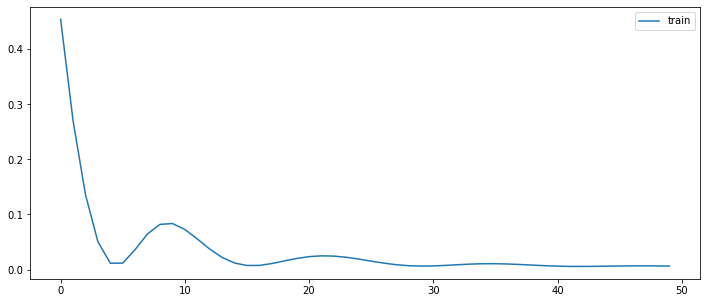

In [235]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

#### Predicción

In [236]:
test_X.shape

(114, 1, 84)

In [237]:
test_X.shape[2]

84

In [238]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [239]:
extra_features = semanal_st2.shape[1] - 1

In [240]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -extra_features:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]


In [241]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -extra_features:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [242]:
inv_y

array([48891.43 , 49309.15 , 47749.285, 48177.57 , 45283.85 , 48237.004,
       48276.14 , 53502.86 , 50571.28 , 51095.855, 52845.43 , 53975.996,
       48938.715, 52378.57 , 50563.855, 53663.434, 53894.715, 51293.285,
       53138.57 , 52141.57 , 52151.855, 46800.285, 44241.72 , 42891.715,
       45111.43 , 46908.43 , 46841.   , 48610.715, 49720.57 , 45533.285,
       46566.566, 49966.85 , 49500.85 , 50387.57 , 51637.855, 46506.43 ,
       46246.43 , 48465.   , 46557.715, 46022.   , 41067.145, 46302.145,
       46472.   , 44387.   , 43909.855, 44898.715, 42404.855, 41164.855,
       41151.715, 44287.426, 44619.285, 44931.004, 42038.57 , 42993.57 ,
       43058.145, 44043.855, 41562.855, 41919.43 , 42704.57 , 40701.855,
       42172.855, 39334.43 , 35426.57 , 44584.14 , 42340.145, 43556.71 ,
       43876.285, 42044.285, 43907.43 , 41276.285, 32825.855, 45783.004,
       45092.145, 44976.   , 35837.285, 35284.855, 35439.57 , 36088.145,
       37002.715, 39509.715, 36886.285, 39094.855, 

In [243]:
inv_yhat

array([47437.76 , 47112.906, 47574.71 , 47473.49 , 46812.363, 46863.395,
       45889.08 , 45613.492, 47406.375, 46711.28 , 48026.637, 47495.227,
       48035.562, 47838.176, 48712.066, 49296.39 , 50327.438, 50635.043,
       50730.867, 51074.496, 51158.43 , 50426.67 , 50083.668, 49075.863,
       48228.395, 48117.043, 47557.438, 47089.49 , 46801.582, 46512.99 ,
       45962.383, 45805.688, 45109.336, 45102.848, 45992.63 , 46120.047,
       47175.33 , 47424.723, 47341.098, 47126.86 , 46800.613, 46273.332,
       46369.367, 46723.312, 46346.99 , 46283.8  , 45806.938, 45766.582,
       46241.164, 45855.7  , 46334.81 , 46796.438, 46577.69 , 45899.26 ,
       46097.23 , 45550.23 , 45069.996, 44566.88 , 43780.508, 43429.27 ,
       44031.906, 43878.164, 44247.316, 43387.24 , 44923.176, 45136.14 ,
       45774.137, 46869.117, 47058.773, 46816.96 , 47187.105, 46143.71 ,
       46928.39 , 46633.965, 46712.81 , 45736.14 , 45180.65 , 43939.566,
       44422.484, 42924.805, 42274.184, 42385.934, 

In [244]:
rta = st_train.copy()
rta = rta.tail(inv_y.shape[0])
rta['Real'] = inv_y
rta['Predict'] = inv_yhat
rta['diff'] = inv_y - inv_yhat
rta

cantidad_pasos      Real   Predict     diff
fecha                                                  
2017-07-30        48891.43  48891.43  47437.76  1453.67
2017-08-06        49309.14  49309.15  47112.91  2196.24
2017-08-13        47749.29  47749.29  47574.71   174.57
2017-08-20        48177.57  48177.57  47473.49   704.08
2017-08-27        45283.86  45283.85  46812.36 -1528.51
...                    ...       ...       ...      ...
2019-09-01        39967.86  39967.86  42669.14 -2701.28
2019-09-08        39467.29  39467.29  42494.38 -3027.09
2019-09-15        38941.71  38941.71  42219.50 -3277.78
2019-09-22        39989.57  39989.57  42960.93 -2971.36
2019-09-29        41081.14  41081.14  42983.14 -1901.99

[114 rows x 4 columns]

In [245]:
rta.reset_index(inplace=True)

#### RMSE

In [246]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 4245.046


#### Graficamos

In [247]:
# Plot 
fig_predict = go.Figure()
fig_predict.add_trace(go.Scatter(x=rta['fecha'], y=rta['Real'],
                    mode='lines+markers',
                    name='Real'))
fig_predict.add_trace(go.Scatter(x=rta['fecha'], y=rta['Predict'],
                    mode='lines+markers',
                    name='Prediccion'))

fig_predict.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_predict.update_layout(
    title="LSTMV - AU Illia - Predicción Efectivo - Train / Test",
    width=800,
    height=500,
)
fig_predict.show()

### Tomando sólo el precio de la nafta

¿El modelo multivariable podría ser más eficiente si sólo tomaramos el precio de la nafta como variable extra? Veamos como se comporta en ese caso.

In [222]:
semanal_st3 = semanal_st2.copy()

#Quitamos las columnas que ya no vamos a utilizar
semanal_st3.drop(columns=['month', 'provincia','centro','liviano','pesado'], inplace=True)
semanal_st3

total  precio_nafta
fecha                             
2017-02-05  51343.00         21.95
2017-02-12  51967.71         21.95
2017-02-19  49125.29         21.95
2017-02-26  47913.57         21.27
2017-03-05  43558.29         21.27
...              ...           ...
2019-09-01  39967.86         50.82
2019-09-08  39467.29         50.82
2019-09-15  38941.71         50.82
2019-09-22  39989.57         53.15
2019-09-29  41081.14         53.15

[139 rows x 2 columns]

#### Preprocesado de los datos 

In [223]:
PASOS = 12

# load dataset
values = semanal_st3.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed

var1(t-12)  var2(t-12)  var1(t-11)  var2(t-11)  var1(t-10)  var2(t-10)  \
12         0.88        0.03        0.91        0.03        0.77        0.03   
13         0.91        0.03        0.77        0.03        0.72        0.01   
14         0.77        0.03        0.72        0.01        0.52        0.01   
15         0.72        0.01        0.52        0.01        0.63        0.01   
16         0.52        0.01        0.63        0.01        0.69        0.01   
..          ...         ...         ...         ...         ...         ...   
134        0.38        0.85        0.22        0.85        0.00        0.89   
135        0.22        0.85        0.00        0.89        0.30        0.89   
136        0.00        0.89        0.30        0.89        0.35        0.89   
137        0.30        0.89        0.35        0.89        0.32        0.89   
138        0.35        0.89        0.32        0.89        0.43        0.91   

     var1(t-9)  var2(t-9)  var1(t-8)  var2(t-8)  ...  var1(t-4)  var2(t-4)  \
12        0.72       0.01       0.52       0.01  ...       0.70       0.01   
13        0.52       0.01       0.63       0.01  ...       0.75       0.01   
14        0.63       0.01       0.69       0.01  ...       0.52       0.01   
15        0.69       0.01       0.61       0.01  ...       0.76       0.00   
16        0.61       0.01       0.70       0.01  ...       0.82       0.00   
..         ...        ...        ...        ...  ...        ...        ...   
134       0.30       0.89       0.35       0.89  ...       0.40       0.91   
135       0.35       0.89       0.32       0.89  ...       0.31       0.91   
136       0.32       0.89       0.43       0.91  ...       0.31       0.91   
137       0.43       0.91       0.38       0.91  ...       0.26       0.93   
138       0.38       0.91       0.40       0.91  ...       0.35       0.93   

     var1(t-3)  var2(t-3)  var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)  \
12        0.75       0.01       0.52       0.01       0.76       0.00   
13        0.52       0.01       0.76       0.00       0.82       0.00   
14        0.76       0.00       0.82       0.00       0.66       0.00   
15        0.82       0.00       0.66       0.00       0.54       0.00   
16        0.66       0.00       0.54       0.00       0.64       0.03   
..         ...        ...        ...        ...        ...        ...   
134       0.31       0.91       0.31       0.91       0.26       0.93   
135       0.31       0.91       0.26       0.93       0.35       0.93   
136       0.26       0.93       0.35       0.93       0.33       0.93   
137       0.35       0.93       0.33       0.93       0.30       0.93   
138       0.33       0.93       0.30       0.93       0.35       1.00   

     var1(t)  var2(t)  
12      0.82     0.00  
13      0.66     0.00  
14      0.54     0.00  
15      0.64     0.03  
16      0.53     0.03  
..       ...      ...  
134     0.35     0.93  
135     0.33     0.93  
136     0.30     0.93  
137     0.35     1.00  
138     0.40     1.00  

[127 rows x 26 columns]

In [224]:
# drop columns we don't want to predict
reframed.drop(['var2(t)'],axis=1, inplace=True)
reframed

var1(t-12)  var2(t-12)  var1(t-11)  var2(t-11)  var1(t-10)  var2(t-10)  \
12         0.88        0.03        0.91        0.03        0.77        0.03   
13         0.91        0.03        0.77        0.03        0.72        0.01   
14         0.77        0.03        0.72        0.01        0.52        0.01   
15         0.72        0.01        0.52        0.01        0.63        0.01   
16         0.52        0.01        0.63        0.01        0.69        0.01   
..          ...         ...         ...         ...         ...         ...   
134        0.38        0.85        0.22        0.85        0.00        0.89   
135        0.22        0.85        0.00        0.89        0.30        0.89   
136        0.00        0.89        0.30        0.89        0.35        0.89   
137        0.30        0.89        0.35        0.89        0.32        0.89   
138        0.35        0.89        0.32        0.89        0.43        0.91   

     var1(t-9)  var2(t-9)  var1(t-8)  var2(t-8)  ...  var2(t-5)  var1(t-4)  \
12        0.72       0.01       0.52       0.01  ...       0.01       0.70   
13        0.52       0.01       0.63       0.01  ...       0.01       0.75   
14        0.63       0.01       0.69       0.01  ...       0.01       0.52   
15        0.69       0.01       0.61       0.01  ...       0.01       0.76   
16        0.61       0.01       0.70       0.01  ...       0.00       0.82   
..         ...        ...        ...        ...  ...        ...        ...   
134       0.30       0.89       0.35       0.89  ...       0.91       0.40   
135       0.35       0.89       0.32       0.89  ...       0.91       0.31   
136       0.32       0.89       0.43       0.91  ...       0.91       0.31   
137       0.43       0.91       0.38       0.91  ...       0.91       0.26   
138       0.38       0.91       0.40       0.91  ...       0.93       0.35   

     var2(t-4)  var1(t-3)  var2(t-3)  var1(t-2)  var2(t-2)  var1(t-1)  \
12        0.01       0.75       0.01       0.52       0.01       0.76   
13        0.01       0.52       0.01       0.76       0.00       0.82   
14        0.01       0.76       0.00       0.82       0.00       0.66   
15        0.00       0.82       0.00       0.66       0.00       0.54   
16        0.00       0.66       0.00       0.54       0.00       0.64   
..         ...        ...        ...        ...        ...        ...   
134       0.91       0.31       0.91       0.31       0.91       0.26   
135       0.91       0.31       0.91       0.26       0.93       0.35   
136       0.91       0.26       0.93       0.35       0.93       0.33   
137       0.93       0.35       0.93       0.33       0.93       0.30   
138       0.93       0.33       0.93       0.30       0.93       0.35   

     var2(t-1)  var1(t)  
12        0.00     0.82  
13        0.00     0.66  
14        0.00     0.54  
15        0.00     0.64  
16        0.03     0.53  
..         ...      ...  
134       0.93     0.35  
135       0.93     0.33  
136       0.93     0.30  
137       0.93     0.35  
138       1.00     0.40  

[127 rows x 25 columns]

#### Train / Test Split

In [225]:
# split into train and test sets
values = reframed.values
n_train_weeks = st_test_obj1.shape[0]

# Tomo los datos de la serie semanal_st3 y le resto las últimas 13 semanas
train = values[:n_train_weeks, :]

# De la serie semanal_st2 me quedo sólo con las últimas 13 semanas 
test = values[n_train_weeks:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13, 1, 24) (13,) (114, 1, 24) (114,)


#### Creamos el Modelo
Utilizaremos una Red Feedforward. Como entradas tenemos 12 pasos por cantidad de variables variables.

In [226]:
# design network
model = Sequential()
model.add(LSTM(100, activation="tanh", input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

#### Entrenamos

In [227]:
EPOCHS = 50

# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=EPOCHS, 
    batch_size=72, 
    validation_data=(test_X, test_y), 
    verbose=2, 
    shuffle=False
)

Epoch 1/50
1/1 - 2s - loss: 0.5600 - val_loss: 0.3423
Epoch 2/50
1/1 - 0s - loss: 0.5078 - val_loss: 0.2957
Epoch 3/50
1/1 - 0s - loss: 0.4585 - val_loss: 0.2539
Epoch 4/50
1/1 - 0s - loss: 0.4120 - val_loss: 0.2165
Epoch 5/50
1/1 - 0s - loss: 0.3684 - val_loss: 0.1836
Epoch 6/50
1/1 - 0s - loss: 0.3274 - val_loss: 0.1551
Epoch 7/50
1/1 - 0s - loss: 0.2891 - val_loss: 0.1308
Epoch 8/50
1/1 - 0s - loss: 0.2535 - val_loss: 0.1107
Epoch 9/50
1/1 - 0s - loss: 0.2204 - val_loss: 0.0948
Epoch 10/50
1/1 - 0s - loss: 0.1899 - val_loss: 0.0831
Epoch 11/50
1/1 - 0s - loss: 0.1620 - val_loss: 0.0755
Epoch 12/50
1/1 - 0s - loss: 0.1366 - val_loss: 0.0719
Epoch 13/50
1/1 - 0s - loss: 0.1136 - val_loss: 0.0724
Epoch 14/50
1/1 - 0s - loss: 0.0932 - val_loss: 0.0768
Epoch 15/50
1/1 - 0s - loss: 0.0751 - val_loss: 0.0850
Epoch 16/50
1/1 - 0s - loss: 0.0595 - val_loss: 0.0968
Epoch 17/50
1/1 - 0s - loss: 0.0462 - val_loss: 0.1121
Epoch 18/50
1/1 - 0s - loss: 0.0353 - val_loss: 0.1305
Epoch 19/50
1/1 - 0

 #### Loss

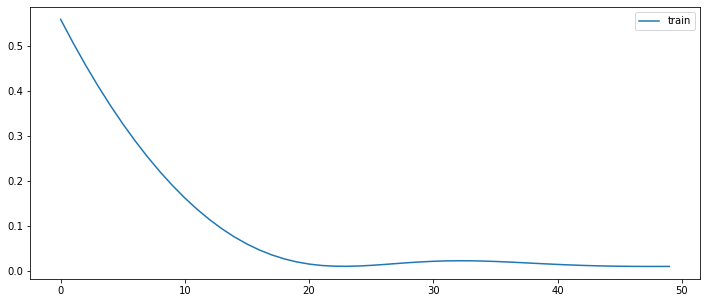

In [228]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

#### Predicción

In [229]:
test_X.shape

(114, 1, 24)

In [230]:
test_X.shape[2]

24

In [231]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [232]:
extra_features = semanal_st3.shape[1] - 1

In [233]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -extra_features:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [234]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -extra_features:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [235]:
inv_y

array([48891.43 , 49309.15 , 47749.285, 48177.57 , 45283.85 , 48237.004,
       48276.14 , 53502.86 , 50571.28 , 51095.855, 52845.43 , 53975.996,
       48938.715, 52378.57 , 50563.855, 53663.434, 53894.715, 51293.285,
       53138.57 , 52141.57 , 52151.855, 46800.285, 44241.72 , 42891.715,
       45111.43 , 46908.43 , 46841.   , 48610.715, 49720.57 , 45533.285,
       46566.566, 49966.85 , 49500.85 , 50387.57 , 51637.855, 46506.43 ,
       46246.43 , 48465.   , 46557.715, 46022.   , 41067.145, 46302.145,
       46472.   , 44387.   , 43909.855, 44898.715, 42404.855, 41164.855,
       41151.715, 44287.426, 44619.285, 44931.004, 42038.57 , 42993.57 ,
       43058.145, 44043.855, 41562.855, 41919.43 , 42704.57 , 40701.855,
       42172.855, 39334.43 , 35426.57 , 44584.14 , 42340.145, 43556.71 ,
       43876.285, 42044.285, 43907.43 , 41276.285, 32825.855, 45783.004,
       45092.145, 44976.   , 35837.285, 35284.855, 35439.57 , 36088.145,
       37002.715, 39509.715, 36886.285, 39094.855, 

In [236]:
inv_yhat

array([47429.33 , 47696.094, 48081.535, 48332.406, 48630.496, 48241.082,
       48571.46 , 48336.047, 49077.293, 49301.24 , 49771.18 , 50251.387,
       50491.56 , 50600.953, 50994.61 , 51408.914, 51477.688, 52438.977,
       52750.26 , 53176.26 , 53244.848, 53682.207, 52908.227, 52728.477,
       51516.848, 51171.207, 50807.33 , 50502.   , 50534.684, 50313.438,
       50124.402, 49854.164, 50261.34 , 50230.4  , 50642.684, 51597.133,
       51838.66 , 51836.195, 52377.406, 52296.016, 52044.867, 51662.445,
       51790.312, 51524.85 , 51470.56 , 51057.516, 50959.188, 50271.03 ,
       49729.523, 49984.156, 49543.19 , 49715.254, 49943.45 , 50121.016,
       50030.977, 50033.73 , 50192.812, 50251.6  , 50465.22 , 50849.62 ,
       50752.555, 51272.035, 51241.984, 50870.03 , 51188.863, 51891.203,
       52453.816, 53186.36 , 54038.926, 54091.42 , 54646.414, 54406.36 ,
       54738.457, 55726.598, 55811.984, 55672.01 , 55595.824, 54153.41 ,
       53588.31 , 53533.035, 52814.582, 52842.88 , 

In [237]:
rta = st_train.copy()
rta = rta.tail(inv_y.shape[0])
rta['Real'] = inv_y
rta['Predict'] = inv_yhat
rta['diff'] = inv_y - inv_yhat
rta

cantidad_pasos      Real   Predict      diff
fecha                                                   
2017-07-30        48891.43  48891.43  47429.33   1462.10
2017-08-06        49309.14  49309.15  47696.09   1613.05
2017-08-13        47749.29  47749.29  48081.54   -332.25
2017-08-20        48177.57  48177.57  48332.41   -154.84
2017-08-27        45283.86  45283.85  48630.50  -3346.64
...                    ...       ...       ...       ...
2019-09-01        39967.86  39967.86  56343.40 -16375.54
2019-09-08        39467.29  39467.29  56715.41 -17248.12
2019-09-15        38941.71  38941.71  56805.15 -17863.44
2019-09-22        39989.57  39989.57  57041.37 -17051.80
2019-09-29        41081.14  41081.14  57340.51 -16259.37

[114 rows x 4 columns]

In [238]:
rta.reset_index(inplace=True)

#### RMSE

In [239]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 10910.666


#### Graficamos

In [240]:
# Plot 
fig_predict = go.Figure()
fig_predict.add_trace(go.Scatter(x=rta['fecha'], y=rta['Real'],
                    mode='lines+markers',
                    name='Real'))
fig_predict.add_trace(go.Scatter(x=rta['fecha'], y=rta['Predict'],
                    mode='lines+markers',
                    name='Prediccion'))

fig_predict.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_predict.update_layout(
    title="LSTMV - AU Illia - Predicción Efectivo - Train / Test",
    width=800,
    height=500,
)
fig_predict.show()

La metrica ya nos indicó que el desempeño del modelo, era pésimo. Lo más llamativo es que ni si quiera logró aprender la tendencia. 
Seguramente le dió más importancia a la suba del precio de la nafta que a la disminución del tránsito vehicular.

### Conclusiones de LSTM Multivariable

La red LSTM Multivariable, es muy costosa a la hora de la preparación de los datos. Más allá de todas las combinaciones que hice, elegí plasmar las tres que creí más representativas.

Sólo la primera logró mejorar la métrica de la red LSTM univariable, la mejora no es lo suficientemente sustancial como para hacer las predicciones del último trimestre del 2019 y del 2020.

Tomando como objetivo principal el aprendizaje, decido invertir el tiempo de trabajo en aprender y experimentar con un nuevo modelo multicapa para evaluar su performance.

En lo personal, tenía muchas expectativas por este modelo, y no rindió lo esperado. El tiempo de preparado de datos es es alto. Como experiencia, tendré muy en cuenta esta cuestión, a la hora de decidir trabajar con un modelo de este tipo.

## LSTM con Autoencoders

Este modelo de LSTM, a diferencia de los anteriores tiene más capas de complejidad llamadas "encoders" o "decoders". 

El modelo que definimos para este caso utiliza como entrada la cantidad de pasos de vehículos, es decir, volvemos a una versión univariable. Pero agregamos agregamos 4 capas ocultas, con diferentes combinaciones y transformaciones previo a que pase por la capa Dense, que termina devolviendo los datos de salida.

Experimentemos con algunas capas y transformaciones.


### Preprocesado de datos

In [630]:
PASOS = 12

# load dataset
values = st_train.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  \
12         0.02        0.64        0.74       0.66       0.67       0.76   
13         0.64        0.74        0.66       0.67       0.76       0.58   
14         0.74        0.66        0.67       0.76       0.58       0.72   
15         0.66        0.67        0.76       0.58       0.72       0.72   
16         0.67        0.76        0.58       0.72       0.72       0.73   
..          ...         ...         ...        ...        ...        ...   
191        0.32        0.19        0.00       0.25       0.30       0.27   
192        0.19        0.00        0.25       0.30       0.27       0.36   
193        0.00        0.25        0.30       0.27       0.36       0.32   
194        0.25        0.30        0.27       0.36       0.32       0.34   
195        0.30        0.27        0.36       0.32       0.34       0.26   

     var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)  
12        0.58       0.72       0.72       0.73       0.79       0.82     0.49  
13        0.72       0.72       0.73       0.79       0.82       0.49     0.77  
14        0.72       0.73       0.79       0.82       0.49       0.77     0.75  
15        0.73       0.79       0.82       0.49       0.77       0.75     0.66  
16        0.79       0.82       0.49       0.77       0.75       0.66     0.75  
..         ...        ...        ...        ...        ...        ...      ...  
191       0.36       0.32       0.34       0.26       0.26       0.21     0.29  
192       0.32       0.34       0.26       0.26       0.21       0.29     0.27  
193       0.34       0.26       0.26       0.21       0.29       0.27     0.25  
194       0.26       0.26       0.21       0.29       0.27       0.25     0.29  
195       0.26       0.21       0.29       0.27       0.25       0.29     0.34  

[184 rows x 13 columns]

### Train/Test Split

In [631]:
# split into train and test sets
values = reframed.values
n_train_weeks = st_test_obj1.shape[0]


# Tomo la serie del 2016-01-03 al 2019-10-01 y le saco las semanas del test
train = values[:n_train_weeks, :]

# Tomo la serie del 2016-01-03 al 2019-10-01 y me quedo sólo con las últimas 13 semanas 
test = values[n_train_weeks:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13, 1, 12) (13,) (171, 1, 12) (171,)


### Creamos el Modelo

In [632]:
# design network
model = Sequential()
model.add(LSTM(50, activation='tanh', 
               input_shape=(train_X.shape[1],train_X.shape[2]),return_sequences=True))

model.add(LSTM(100, activation='relu', return_sequences=False))
model.add(RepeatVector(train_X.shape[1]))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(train_X.shape[2])))
model.compile(loss='mean_squared_error', optimizer='adam')

### Entrenamos

In [633]:
EPOCHS = 50

# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=EPOCHS, 
    batch_size=20, 
    validation_data=(test_X, test_y), 
    verbose=2
)


Epoch 1/50
1/1 - 6s - loss: 0.4902 - val_loss: 0.3341
Epoch 2/50
1/1 - 0s - loss: 0.4879 - val_loss: 0.3323
Epoch 3/50
1/1 - 0s - loss: 0.4855 - val_loss: 0.3305
Epoch 4/50
1/1 - 0s - loss: 0.4832 - val_loss: 0.3286
Epoch 5/50
1/1 - 0s - loss: 0.4807 - val_loss: 0.3267
Epoch 6/50
1/1 - 0s - loss: 0.4782 - val_loss: 0.3248
Epoch 7/50
1/1 - 0s - loss: 0.4757 - val_loss: 0.3228
Epoch 8/50
1/1 - 0s - loss: 0.4730 - val_loss: 0.3207
Epoch 9/50
1/1 - 0s - loss: 0.4703 - val_loss: 0.3186
Epoch 10/50
1/1 - 0s - loss: 0.4675 - val_loss: 0.3164
Epoch 11/50
1/1 - 0s - loss: 0.4645 - val_loss: 0.3141
Epoch 12/50
1/1 - 0s - loss: 0.4615 - val_loss: 0.3117
Epoch 13/50
1/1 - 0s - loss: 0.4583 - val_loss: 0.3092
Epoch 14/50
1/1 - 0s - loss: 0.4550 - val_loss: 0.3066
Epoch 15/50
1/1 - 0s - loss: 0.4515 - val_loss: 0.3039
Epoch 16/50
1/1 - 0s - loss: 0.4478 - val_loss: 0.3011
Epoch 17/50
1/1 - 0s - loss: 0.4439 - val_loss: 0.2980
Epoch 18/50
1/1 - 0s - loss: 0.4398 - val_loss: 0.2948
Epoch 19/50
1/1 - 0

### Loss

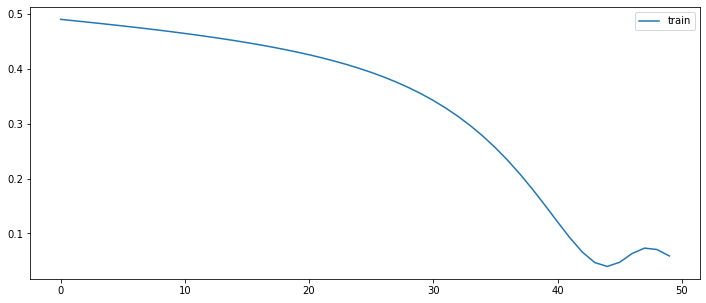

In [634]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

### Predicción

In [635]:
test_X.shape

(171, 1, 12)

In [636]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [637]:
yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))

In [638]:
test_X.shape

(171, 12)

In [639]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [640]:
inv_yhat.shape[0]

171

In [641]:
rta = st_train.copy()
rta = rta.tail(inv_y.shape[0])
rta['Real'] = inv_y
rta['Predict'] = inv_yhat
rta['diff'] = inv_y - inv_yhat
rta

cantidad_pasos      Real   Predict     diff
fecha                                                  
2016-06-26        48575.00  48575.00  47431.23  1143.77
2016-07-03        49060.86  49060.86  47168.03  1892.82
2016-07-10        50644.71  50644.71  47047.76  3596.96
2016-07-17        56011.14  56011.14  46878.21  9132.94
2016-07-24        54911.57  54911.57  47354.90  7556.67
...                    ...       ...       ...      ...
2019-09-01        39967.86  39967.86  39157.45   810.41
2019-09-08        39467.29  39467.29  39095.38   371.90
2019-09-15        38941.71  38941.71  39199.32  -257.60
2019-09-22        39989.57  39989.57  39435.56   554.01
2019-09-29        41081.14  41081.14  39426.98  1654.17

[171 rows x 4 columns]

In [642]:
rta.reset_index(inplace=True)

### RMSE

In [643]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3605.425


### Graficamos

In [644]:
# Plot 
fig_predict = go.Figure()
fig_predict.add_trace(go.Scatter(x=rta['fecha'], y=rta['Real'],
                    mode='lines+markers',
                    name='Real'))
fig_predict.add_trace(go.Scatter(x=rta['fecha'], y=rta['Predict'],
                    mode='lines+markers',
                    name='Prediccion'))

fig_predict.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_predict.update_layout(
    title="LSTMV - AU Illia - Predicción Efectivo - Train / Test",
    width=800,
    height=500,
)
fig_predict.show()

### Conclusiones de LSMT con autoencoders

Variantes para un modelo multicapa hay infinitos. Tengamos en cuenta que no sólo se pueden agregar capas, sino también aplicar transformaciones en cada capa.

De todos los modelos aprendidos, creo que este es a nivel costo-beneficio el que tiene más potencial. El costo de la preparación de los datos es baja. El mayor tiempo se invierte que probar diferentes capas ocultas y transformaciones intermedias. Tiempo que se vería reducido a mayor experiencia.

Si bien, mis resultados obtenidos no fueron buenos, entiendo que con más tiempo de aprendizaje, experiencia, mentoría... podría lograr un desempeño superior.


### Predicción 2019

A partir de las últimas 12 semanas previas, predigo el último trimestre del 2019.

In [645]:
ultimasSemanas_train_st = pd.DataFrame()
ultimasSemanas_train_st = dataset_illia_ef_st_w3_mean['2019-07-14':'2019-10-06']
ultimasSemanas_train_st

cantidad_pasos
fecha                     
2019-07-14        39264.57
2019-07-21        41633.00
2019-07-28        40688.86
2019-08-04        41110.43
2019-08-11        39123.86
2019-08-18        39216.14
2019-08-25        37942.00
2019-09-01        39967.86
2019-09-08        39467.29
2019-09-15        38941.71
2019-09-22        39989.57
2019-09-29        41081.14
2019-10-06        38926.14

In [646]:
# Tomo las ultimas 12 semanas 
values = ultimasSemanas_train_st.astype('float32')

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  \
12        0.36        1.00        0.74       0.86       0.32       0.35   

    var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)  
12       0.00       0.55       0.41       0.27       0.55       0.85     0.27

In [647]:
# Eliminamos el último valor que vamos a predecir
reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
reframed

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  \
12        0.36        1.00        0.74       0.86       0.32       0.35   

    var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  
12       0.00       0.55       0.41       0.27       0.55       0.85

In [648]:
reframed.shape

(1, 12)

In [649]:
reframed_values = reframed.values
x_test = reframed_values[0:, :]
x_test

array([[0.3583231 , 1.        , 0.74420357, 0.8584204 , 0.32019997,
        0.3452034 , 0.        , 0.5488634 , 0.41324425, 0.2708521 ,
        0.5547466 , 0.85048676]], dtype=float32)

In [650]:
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test.shape

(1, 1, 12)

In [651]:
x_test

array([[[0.3583231 , 1.        , 0.74420357, 0.8584204 , 0.32019997,
         0.3452034 , 0.        , 0.5488634 , 0.41324425, 0.2708521 ,
         0.5547466 , 0.85048676]]], dtype=float32)

In [652]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

In [653]:
results=[]
for i in range(13):
    parcial = model.predict(x_test)
    results.append(parcial[0][0])
    x_test=agregarNuevoValor(x_test,parcial[0][0][11])

#### Re-Convertimos los resultados

In [654]:
adimen = [x for x in results]    
inverted = scaler.inverse_transform(results)

results=[]
for i in range(13):
    results.append(inverted[i][11])

#### Visualizamos el pronóstico

In [655]:
prediccion = pd.DataFrame(results)
prediccion.columns = ['pronostico']

df_result_2019['Pred LSTMA'] = prediccion
df_result_2019

Fecha  Pred XGB      Real  Pred LSTM1  Pred LSTM Autoencoded  \
0  2019-10-06  38975.43  38926.14    40297.29               41457.42   
1  2019-10-13  39160.40  37262.86    40202.66               41583.97   
2  2019-10-20  39058.61  38163.86    39909.55               41769.72   
3  2019-10-27  38504.88  37564.29    39804.76               41965.06   
4  2019-11-03  38504.88  39018.43    39773.44               42217.94   
5  2019-11-10  37998.48  38648.00    39710.73               42466.80   
6  2019-11-17  38504.88  40255.71    39852.65               42765.77   
7  2019-11-24  38504.88  37785.71    40097.97               43059.66   
8  2019-12-01  37998.48  38079.29    40169.40               43381.19   
9  2019-12-08  38654.00  40413.00    40294.38               43720.69   
10 2019-12-15  37998.48  38994.29    40365.47               44081.64   
11 2019-12-22  37998.48  41840.14    40326.02               44447.77   
12 2019-12-29  37998.48  32341.43    40256.44               44849.01   

    Pred LSTM A  Pred LSTMA  
0      41457.42    39817.93  
1      41583.97    39822.02  
2      41769.72    39823.95  
3      41965.06    39703.47  
4      42217.94    39635.70  
5      42466.80    39677.87  
6      42765.77    39741.02  
7      43059.66    39813.50  
8      43381.19    39804.82  
9      43720.69    39821.74  
10     44081.64    39898.12  
11     44447.77    39875.25  
12     44849.01    39805.33

#### RMSE

In [656]:
rmse_lstma_2019 = np.sqrt(mean_squared_error(df_result_2019['Real'], df_result_2019['Pred LSTMA']))

print(f"LSTMA Predicción Último Trimestre del 2019")
print("-----------------------")
print(f"RMSE-Test: %.3f" %  rmse_lstma_2019)

LSTM1 Predicción Último Trimestre del 2019
-----------------------
RMSE-Test: 2545.126


#### Graficamos

In [657]:
# Plot 
fig_predict_2019.add_trace(go.Scatter(x=df_result_2019['Fecha'], y=df_result_2019['Pred LSTMA'],
                    mode='lines+markers',
                    name='Pred LSTM Autoencod'))
fig_predict_2019.show()

#### Conclusiones 2019

A nivel de predicción, es indiscutible que el XGBoost Regresor es el modelo de mejor performance. 
Comparando las redes neuronales, hay una mejora de métricas con el modelo LSTM con autoencoders.
E imagino que superaría la performance, el modelo multivariable que trabaja con las variables internas como inputs.

### Predicción 2020
A partir de las últimas 12 semanas del 2019 predigo el 2020

In [668]:
semanal_st = dataset_illia_ef_st_w_mean.copy()

ultimasSemanas_train_st = pd.DataFrame()
ultimasSemanas_train_st = semanal_st['2019-10-07':'2020-01-05']
ultimasSemanas_train_st

cantidad_pasos
fecha                     
2019-10-13        37262.86
2019-10-20        38163.86
2019-10-27        37564.29
2019-11-03        39018.43
2019-11-10        38648.00
2019-11-17        40255.71
2019-11-24        37785.71
2019-12-01        38079.29
2019-12-08        40413.00
2019-12-15        38994.29
2019-12-22        41840.14
2019-12-29        32341.43
2020-01-05        29513.29

In [678]:
# Tomo las ultimas 12 semanas 
values = ultimasSemanas_train_st.astype('float32')

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed

# Eliminamos el último valor que vamos a predecir
reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
reframed

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  \
12        0.63        0.70        0.65       0.77       0.74       0.87   

    var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  
12       0.67       0.69       0.88       0.77       1.00       0.23

In [679]:
reframed.shape

(1, 12)

In [680]:
reframed_values = reframed.values
x_test = reframed_values[0:, :]
x_test

array([[0.62867355, 0.701766  , 0.6531267 , 0.7710922 , 0.74104166,
        0.87146544, 0.6710899 , 0.6949055 , 0.8842249 , 0.76913357,
        1.0000002 , 0.22942948]], dtype=float32)

In [681]:
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test.shape

(1, 1, 12)

In [682]:
x_test

array([[[0.62867355, 0.701766  , 0.6531267 , 0.7710922 , 0.74104166,
         0.87146544, 0.6710899 , 0.6949055 , 0.8842249 , 0.76913357,
         1.0000002 , 0.22942948]]], dtype=float32)

In [683]:
results=[]
for i in range(52):
    parcial = model.predict(x_test)
    results.append(parcial[0][0])
    x_test=agregarNuevoValor(x_test,parcial[0][0][11])

#### Re-Convertimos los resultados

In [684]:
adimen = [x for x in results]    
inverted = scaler.inverse_transform(results)

results=[]
for i in range(52):
    results.append(inverted[i][11])

#### Visualizamos el pronóstico

In [685]:
prediccion = pd.DataFrame(results)
prediccion.columns = ['pronostico']

df_result_2020['Pred LSTMA'] = prediccion
df_result_2020

Fecha  Pred XGB      Real  Pred LSTM1  Pred LSTMA
0  2020-01-05  38611.94  29513.29    38637.04    38636.30
1  2020-01-12  39565.01  34765.57    39425.43    38581.55
2  2020-01-19  37998.48  35259.71    38900.50    38630.23
3  2020-01-26  37998.48  34456.00    39606.42    38683.26
4  2020-02-02  38504.88  36190.71    39275.38    38757.00
5  2020-02-09  37998.48  35306.43    39565.15    38758.52
6  2020-02-16  38504.88  37351.14    39874.59    38370.86
7  2020-02-23  36318.31  36728.00    39309.86    38729.53
8  2020-03-01  38654.00  33641.00    39394.87    38628.74
9  2020-03-08  38504.88  36415.71    39355.70    38686.86
10 2020-03-15  37998.48  31827.57    39283.24    38486.24
11 2020-03-22  37998.48  26196.71    39507.11    38343.10
12 2020-03-29  37998.48  25174.00    39986.33    38801.57
13 2020-04-05  37998.48  25174.00    40116.06    38805.12
14 2020-04-12  37998.48  25174.00    40234.01    38835.07
15 2020-04-19  37998.48  25174.00    40306.78    38852.54
16 2020-04-26  37998.48  11616.00    40348.65    38883.79
17 2020-05-03  37998.48  11616.00    40405.92    38880.30
18 2020-05-10  37998.48  11616.00    40416.06    38903.11
19 2020-05-17  37998.48  11616.00    40454.43    38960.17
20 2020-05-24  37998.48  10211.14    40566.80    38982.48
21 2020-05-31  37998.48  10655.86    40687.28    39018.93
22 2020-06-07  37998.48  10408.71    40827.20    39044.67
23 2020-06-14  37998.48  11421.14    40968.46    39100.37
24 2020-06-21  37998.48  11883.29    41081.83    39163.43
25 2020-06-28  37998.48  12070.00    41170.39    39198.95
26 2020-07-05  37998.48  12964.71    41246.44    39237.47
27 2020-07-12  37998.48  13868.43    41316.29    39276.89
28 2020-07-19  37998.48  11667.14    41390.55    39317.93
29 2020-07-26  37998.48  12521.29    41471.10    39359.11
30 2020-08-02  37998.48  13750.29    41560.93    39405.93
31 2020-08-09  37998.48  13879.00    41661.85    39453.83
32 2020-08-16  37998.48  14010.29    41766.65    39500.95
33 2020-08-23  37998.48  12162.43    41868.77    39550.08
34 2020-08-30  37998.48  12143.14    41965.66    39600.51
35 2020-09-06  37998.48  11446.86    42055.55    39653.46
36 2020-09-13  37998.48  11162.43    42139.93    39706.07
37 2020-09-20  37998.48  10248.86    42221.81    39758.38
38 2020-09-27  37998.48  10283.14    42303.81    39812.21
39 2020-10-04  37998.48   9149.71    42387.96    39867.50
40 2020-10-11  37998.48   6709.00    42474.76    39924.23
41 2020-10-18  37998.48   6766.43    42563.47    39982.49
42 2020-10-25  37998.48   6875.86    42652.91    40042.41
43 2020-11-01  37998.48   6509.86    42741.49    40103.54
44 2020-11-08  37998.48   6977.14    42827.94    40165.98
45 2020-11-15  37998.48   7577.14    42911.94    40229.91
46 2020-11-22  37998.48   8740.14    42993.82    40295.31
47 2020-11-29  37998.48   8290.00    43074.34    40362.18
48 2020-12-06  37998.48   9797.14    43154.30    40430.43
49 2020-12-13  37998.48   9347.86    43234.26    40500.22
50 2020-12-20  37998.48  10511.14    43314.41    40571.68
51 2020-12-27  37998.48   9633.43    43394.56    40644.82

#### RMSE

In [686]:
rmse_lstma_2020 = np.sqrt(mean_squared_error(df_result_2020['Real'], df_result_2020['Pred LSTMA']))

print(f"LSTMA Predicción 2020")
print("-----------------------")
print(f"RMSE-Test: %.3f" %  rmse_lstma_2020)

LSTMA Predicción 2020
-----------------------
RMSE-Test: 24721.646


#### Graficamos

In [687]:
# Plot 
fig_predict_2020.add_trace(go.Scatter(x=df_result_2020['Fecha'], y=df_result_2020['Pred LSTMA'],
                    mode='lines+markers',
                    name='Pred LSTM Autoencod'))
fig_predict_2020.show()

#### Conclusiones 2020

Para el año 2020, a pesar de ser pésimo, el más acertado el es xgboost. Si bien en mi camino recorrido, no logré mejorar las métricas, en año atípico como este, imagino que alguien con más experiencia eligiría una red neuronal o, prophets.

**¿Por qué digo esto?**
Si hablamos de redes neuronales, como hemos visto en este recorrido, estos modelos permiten incluir otras variables y generar capas de transformación de datos en donde la red aprende a través de diferentes capas hasta devolver el resultado. 
Seguramente una combinación de multivariable con autoencoders (con mucha practica y más conocimiento), seria el modelo más oportuno.


## Conclusiones Finales

¿Cuál será la curva de aprendizaje de este tipo de tecnología? ¿Cuánto tiempo se demora en encontrar, y entrenar un modelo óptimo? ¿Son modelos aplicables para ser implementados a corto plazo o es conveniente elegirlos cuando la proyección del resultado es a largo plazo?



No nos olvidemos que a su vez, se puede entrenar N cantidad de épocas y darle como entrada M cantidad de semanas. Esto sólo si consideramos un resampleo semanal. 

En fin, ahora comprendo como se puede tardar años en entrenar una red, hasta obtener la performance deseada. Las posibilidades son infinitas.

Por último, recordemos que las redes LSTM no son las únicas.


Una muy buena práctica sería incluso, generar un set de hiperparámetros y obtener el 